## Peak-Base, raw SCR value

### Phase 1 

In [319]:
import os

path = '/Volumes/Seagate Desktop Drive/NARSAD/SCR'
os.chdir(path)

import pandas as pd
import numpy as np

# Parameters
trialnumber = range(1, 25)  # Can adjust to first half of trials: range(1, 13)
excludeparticipants = 1  # Set to 0 to include all participants
rejtrials_threshold = 24  # Adjust the threshold as needed

# Load the table
peakstatstable = pd.read_csv('peak_stats_table-phase1.csv')

# Extract unique participant IDs and trial types
participants = peakstatstable['sid'].unique()
trial_types = peakstatstable['stTy'].unique()

# Group data by participant
participant_groups = peakstatstable.groupby('sid')
dat = []

for participant_id in participants:
    data = participant_groups.get_group(participant_id)
    subject_data = {'subID': participant_id}

    # Process data if there are 24 trials
    if len(data) == 24:
        phase1_data = data[data['stNum'].isin(trialnumber)]

        # Rejected trials (based on "Publication recommendations for electrodermal measurements")
        rejTrials = phase1_data[phase1_data['phaBase2Peak'] < 0].index
        phase1_data.loc[rejTrials, 'phaBase2Peak'] = 0  # Mark non-response trials as 0

        subject_data['rejTrials1'] = len(rejTrials)

        # Separate data by stim type
        stim_groups = phase1_data.groupby('stTy')

        try:
            # Calculate mean, SE, and count for CSS, CSR, and CS-
            css_data = stim_groups.get_group('CS+S')
            subject_data['meanCSS1'] = css_data['phaBase2Peak'].mean()
            subject_data['seCSS1'] = css_data['phaBase2Peak'].std() / np.sqrt(len(css_data))
            subject_data['nCSS1'] = len(css_data)

            csr_data = stim_groups.get_group('CS+R')
            subject_data['meanCSR1'] = csr_data['phaBase2Peak'].mean()
            subject_data['seCSR1'] = csr_data['phaBase2Peak'].std() / np.sqrt(len(css_data))
            subject_data['nCSR1'] = len(csr_data)

            csminus_data = stim_groups.get_group('CS-')
            subject_data['meanCSminus1'] = csminus_data['phaBase2Peak'].mean()
            subject_data['seCSminus1'] = csminus_data['phaBase2Peak'].std() / np.sqrt(len(css_data))
            subject_data['nCSminus1'] = len(csminus_data)

        except KeyError:
            print(f"Missing stim type data for participant {participant_id}")
        
    dat.append(subject_data)

# Convert to a DataFrame if you need a structured output
dat_df = pd.DataFrame(dat)
print(dat_df)


    subID  rejTrials1  meanCSS1    seCSS1  nCSS1  meanCSR1    seCSR1  nCSR1  \
0    N101           4  0.034000  0.020075      8  0.010125  0.007352      8   
1    N102           0  0.003625  0.001558      8  0.000875  0.000295      8   
2    N103           1  0.117500  0.020816      8  0.132125  0.025778      8   
3    N104           5  0.001625  0.000944      8  0.001125  0.000581      8   
4    N105           2  0.004625  0.001945      8  0.001625  0.000981      8   
..    ...         ...       ...       ...    ...       ...       ...    ...   
99   N255           6  0.001000  0.000681      8  0.001250  0.000750      8   
100  N257           4  0.031875  0.010315      8  0.041125  0.021445      8   
101  N258           0  0.034000  0.006980      8  0.029000  0.007533      8   
102  N259           2  0.015000  0.004706      8  0.020875  0.008941      8   
103  N260           1  0.081750  0.025366      8  0.068750  0.014820      8   

     meanCSminus1  seCSminus1  nCSminus1  
0       

In [259]:
#### filtering by contigency q = correct: 
path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

import pandas as pd

# Load your contingency data
cont_df = pd.read_excel('contingencies.xlsx')

# Define correct response pattern
correct_pattern = np.array([1, 1, 1, 1, 0])

# Identify relevant columns (excluding ID)
cont_cols = cont_df.columns[1:6]

# Ensure numeric values (in case there are strings)
cont_values = cont_df[cont_cols].apply(pd.to_numeric, errors='coerce').values

# Compare each row to the correct pattern
mask = np.all(cont_values == correct_pattern, axis=1)

# Get IDs of correct learners
learned_ids = cont_df.loc[mask, 'login_participantid'].astype(str)

# Filter your main dataframe
dat_df_filtered = dat_df[dat_df['subID'].astype(str).isin(learned_ids)]

# ---- Summary stats ----
total_n = len(dat_df)
included_n = len(dat_df_filtered)
excluded_n = total_n - included_n
excluded_pct = (excluded_n / total_n) * 100

# Define patient/control subsets
dat_df['group'] = dat_df['subID'].astype(str).str[1:4].astype(int).apply(
    lambda x: 'patient' if 100 <= x < 200 else ('control' if 200 <= x < 300 else 'other')
)

# Count by group before filtering
group_counts_before = dat_df['group'].value_counts()

# Count by group after filtering
group_counts_after = dat_df_filtered.merge(dat_df[['subID', 'group']], on='subID', how='left')['group'].value_counts()

# Calculate exclusions per group
for group in ['patient', 'control']:
    before = group_counts_before.get(group, 0)
    after = group_counts_after.get(group, 0)
    excluded = before - after
    pct_excluded = (excluded / before * 100) if before > 0 else 0
    print(f"{group.capitalize()}s excluded: {excluded} / {before} ({pct_excluded:.1f}%)")

# ---- Overall summary ----
print("\n=== Summary ===")
print(f"Total subjects before filtering: {total_n}")
print(f"Subjects included (learned correctly): {included_n}")
print(f"Subjects excluded: {excluded_n} ({excluded_pct:.1f}%)")

dat_df = dat_df_filtered

path = '/Volumes/Seagate Desktop Drive/NARSAD/SCR'
os.chdir(path)

Patients excluded: 17 / 51 (33.3%)
Controls excluded: 10 / 53 (18.9%)

=== Summary ===
Total subjects before filtering: 104
Subjects included (learned correctly): 77
Subjects excluded: 27 (26.0%)


#### CSR and CSS kept separate 

In [25]:
# intercept included cs- data, control data, placebo data see specific effect of drug, css, csr, etc. 

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 'CSR', 
    'meanCSS1': 'CSS', 
    'meanCSminus1': 'CSminus'
})

long_data['stim_type'] = long_data['stim_type'].astype('category')
long_data['stim_type'] = long_data['stim_type'].cat.reorder_categories(['CSminus', 'CSR', 'CSS'], ordered=True)

# Model formula including main effect of stim_type
model_formula = 'response ~ C(patient_group) + C(stim_type) + C(gender)'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.078
Date:                Fri, 17 Oct 2025   Prob (F-statistic):             0.0680
Time:                        15:47:18   Log-Likelihood:                 187.04
No. Observations:                 312   AIC:                            -362.1
Df Residuals:                     306   BIC:                            -339.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [337]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 1, 
    'meanCSS1': 2, 
    'meanCSminus1': 3
})

# Specify the model without intercept
model_formula = 'response ~ patient_group + stim_type + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.962
Date:                Thu, 11 Sep 2025   Prob (F-statistic):             0.0324
Time:                        15:40:37   Log-Likelihood:                 186.27
No. Observations:                 312   AIC:                            -364.5
Df Residuals:                     308   BIC:                            -349.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.1044      0.023      4.619

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_82286/1997776968.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


ValueError: too many values to unpack (expected 2)

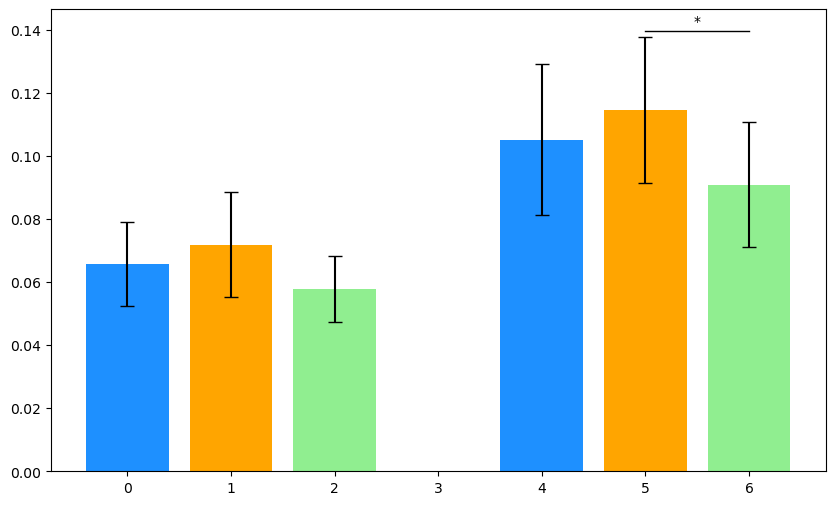

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 'CSR', 
    'meanCSS1': 'CSS', 
    'meanCSminus1': 'CSminus'
})

# Calculate means and errors
group_means = long_data.groupby(['patient_group', 'stim_type'])['response'].mean().reset_index()
group_sems = long_data.groupby(['patient_group', 'stim_type'])['response'].sem().reset_index()

# Set up custom x positions for the bars (grouped with a gap between patients and controls)
x_positions = {
    ('patient', 'CSR'): 0, ('patient', 'CSS'): 1, ('patient', 'CSminus'): 2,
    ('control', 'CSR'): 4, ('control', 'CSS'): 5, ('control', 'CSminus'): 6
}

# Map x positions to data
group_means['x'] = group_means.apply(lambda row: x_positions[(row['patient_group'], row['stim_type'])], axis=1)
group_sems['x'] = group_means['x']

# Define colors for each stimulus type
stimulus_colors = {
    'CSR': 'dodgerblue',
    'CSS': 'orange',
    'CSminus': 'lightgreen'
}

# Plot bar chart
plt.figure(figsize=(10, 6))

for group in ['patient', 'control']:
    for stim in ['CSR', 'CSS', 'CSminus']:
        group_data = group_means[(group_means['patient_group'] == group) & (group_means['stim_type'] == stim)]
        group_errors = group_sems[(group_sems['patient_group'] == group) & (group_sems['stim_type'] == stim)]
        plt.bar(group_data['x'], group_data['response'], 
                color=stimulus_colors[stim], 
                label=stim if group == 'patient' else "",  # Label only for patients
                yerr=group_errors['response'], capsize=5)

# Initialize table for storing t-test results
t_test_results = []

# Add significance markers
def add_significance_markers(ax, comparisons, y_offset=0.02, bar_height=0.02):
    for (group1, stim1), (group2, stim2) in comparisons:
        if group1 == group2:
            # Paired t-test within the same group
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_rel(data1['response'], data2['response'])
        else:
            # Independent t-test between groups
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group2) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_ind(data1['response'], data2['response'], equal_var=False)
        
        # Store results in table
        t_test_results.append({
            'Comparison': f"{group1}-{stim1} vs {group2}-{stim2}",
            't-statistic': result.statistic,
            'p-value': result.pvalue,
            'df': result.df
        })
        
        # Add markers if significant
        if result.pvalue < 0.05:  # Customize significance level if needed
            x1 = x_positions[(group1, stim1)]
            x2 = x_positions[(group2, stim2)]
            max_y = group_means['response'].max() + 0.025  # Adjust this if needed
            ax.plot([x1, x2], [max_y, max_y], 'k-', lw=1)
            ax.text((x1 + x2) / 2, max_y + 0.001, '*', ha='center', va='bottom')

# Define comparisons
comparisons = [
    (('patient', 'CSR'), ('patient', 'CSS')),   # Patient CSR vs CSS
    (('patient', 'CSR'), ('patient', 'CSminus')),  # Patient CSR vs CSminus
    (('patient', 'CSS'), ('patient', 'CSminus')),  # Patient CSS vs CSminus
    (('control', 'CSR'), ('control', 'CSS')),   # Control CSR vs CSS
    (('control', 'CSR'), ('control', 'CSminus')),  # Control CSR vs CSminus
    (('control', 'CSS'), ('control', 'CSminus')),  # Control CSS vs CSminus
    (('patient', 'CSR'), ('control', 'CSR')),    # Between-group CSR
    (('patient', 'CSS'), ('control', 'CSS')),    # Between-group CSS
    (('patient', 'CSminus'), ('control', 'CSminus')), # Between-group CSminus
]

add_significance_markers(plt.gca(), comparisons)
# Add x-axis labels to indicate groups
plt.text(0.5, -0.01, 'Patients', ha='center', va='top', fontsize=12)
plt.text(5, -0.01, 'Controls', ha='center', va='top', fontsize=12)

# Labeling and finalizing plot
plt.xticks([0, 1, 2, 4, 5, 6], ['CSR', 'CSS', 'CSminus', 'CSR', 'CSS', 'CSminus'])
plt.xlabel('Stimulus Type')
plt.ylabel('Mean Response')
plt.title('Mean Response by Stimulus Type and Group')
plt.legend(title='Group')
plt.show()

# Display the table of t-test results
t_test_df = pd.DataFrame(t_test_results)
print(t_test_df)


In [343]:
stats = ttest_rel(merged_data['meanCSR1'],merged_data['meanCSS1'])
stats

TtestResult(statistic=-1.0805746587046585, pvalue=0.2824100124831842, df=103)

#### CS+ vs CS-

In [298]:
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# -------------------------
# Load trial-wise data
# -------------------------
path = '/Volumes/Seagate Desktop Drive/NARSAD/SCR'
os.chdir(path)

peakstatstable = pd.read_csv('peak_stats_table-phase1.csv')

# Parameters
trialnumber = range(1, 13)     # use first 12 trials
expected_trials = 24           # must have all 24 trials for inclusion

# -------------------------
# Load drug assignment + gender
# -------------------------
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# -------------------------
# CLEAN TRIAL-WISE DATA
# -------------------------

# Only keep subjects with full 24-trial datasets
complete_subjects = (
    peakstatstable.groupby("sid")
    .filter(lambda df: len(df) == expected_trials)
)

# Keep only phase 1 trials (your chosen 12 trials)
phase1_data = complete_subjects[
    complete_subjects["stNum"].isin(trialnumber)
].copy()

# ----------------------------------------------
# Reject trials based on base-to-peak negativity
# ----------------------------------------------
# (Publication recommendations: treat < 0 as non-response)
phase1_data.loc[phase1_data["phaBase2Peak"] < 0, "phaBase2Peak"] = 0

# -------------------------
# Merge subject-level variables
# -------------------------
phase1_data = pd.merge(
    phase1_data,
    drug_order,
    left_on="sid",
    right_on="subID",
    how="inner"
)

# -------------------------
# Derive predictors
# -------------------------
phase1_data["patient_group"] = np.where(phase1_data["sid"].str.startswith("N1"), 1, 0)
phase1_data["gender"] = phase1_data["gender_code"]
phase1_data["drug"] = phase1_data["drug_condition"]

# stim_type coding (numeric categorical)
phase1_data["stim_type"] = phase1_data["stTy"].replace({
    "CS+R": 1,
    "CS+S": 2,
    "CS-":  0
})

# -------------------------
# Fit the trial-wise mixed-effects model
# -------------------------

model_formula = (
    "phaBase2Peak ~ patient_group + gender + stim_type"

)

# Random intercept model
model = smf.mixedlm(
    formula=model_formula,
    data=phase1_data,
    groups=phase1_data["sid"]
).fit()

print(model.summary())


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: phaBase2Peak
No. Observations: 1248    Method:             REML        
No. Groups:       104     Scale:              0.0121      
Min. group size:  12      Log-Likelihood:     825.4792    
Max. group size:  12      Converged:          Yes         
Mean group size:  12.0                                    
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.084    0.022  3.872 0.000  0.041  0.126
patient_group   -0.038    0.025 -1.493 0.135 -0.087  0.012
gender           0.021    0.024  0.876 0.381 -0.026  0.069
stim_type        0.009    0.004  2.473 0.013  0.002  0.017
Group Var        0.015    0.022                           



/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_37432/1674557242.py:63: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  phase1_data["stim_type"] = phase1_data["stTy"].replace({


In [260]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)  # 1 for patient, 0 for control
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Calculate the mean of CSR and CSS for each subject and create a new column for CS+
merged_data['CS_plus'] = merged_data[['meanCSR1', 'meanCSS1']].mean(axis=1)

# Count total, patient, and control subjects before filtering
total_subjects_before = len(merged_data)
patients_before = merged_data['patient_group'].sum()
controls_before = total_subjects_before - patients_before

# # Filter subjects where CS_plus - meanCSminus1 > 0
# filtered_data = merged_data[merged_data['CS_plus'] - merged_data['meanCSminus1'] > 0]

# # Count total, patient, and control subjects after filtering
# total_subjects_after = len(filtered_data)
# patients_after = filtered_data['patient_group'].sum()
# controls_after = total_subjects_after - patients_after

# # Calculate exclusions
# excluded_total = total_subjects_before - total_subjects_after
# excluded_patients = patients_before - patients_after
# excluded_controls = controls_before - controls_after

# # Calculate exclusion percentages
# excluded_total_pct = (excluded_total / total_subjects_before) * 100
# excluded_patients_pct = (excluded_patients / patients_before) * 100 if patients_before > 0 else 0
# excluded_controls_pct = (excluded_controls / controls_before) * 100 if controls_before > 0 else 0

# print(f"Total subjects excluded: {excluded_total} ({excluded_total_pct:.2f}%)")
# print(f"Patients excluded: {excluded_patients} ({excluded_patients_pct:.2f}%)")
# print(f"Controls excluded: {excluded_controls} ({excluded_controls_pct:.2f}%)")

# Proceed with the analysis on filtered_data
# Reshape data to stack CS_plus and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['CS_plus', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'CS_plus': 1, 
    'meanCSminus1': 0
})

# Specify the model without intercept
model_formula = 'response ~ patient_group + stim_type + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.910
Date:                Mon, 17 Nov 2025   Prob (F-statistic):              0.130
Time:                        11:48:53   Log-Likelihood:                 86.767
No. Observations:                 154   AIC:                            -165.5
Df Residuals:                     150   BIC:                            -153.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0862      0.022      3.863

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_37432/587633215.py:55: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


In [299]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order'
merged_data = pd.merge(dat_df, drug_order, on='subID', how='inner')

# Prepare columns for analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']
merged_data['drug'] = merged_data['drug_condition']

# Create CS+ as average of CSR and CSS
merged_data['CS_plus'] = merged_data[['meanCSR1', 'meanCSS1']].mean(axis=1)

# Long format (CS+ vs CS−)
long_data = pd.melt(
    merged_data,
    id_vars=['subID', 'patient_group', 'drug', 'gender'],
    value_vars=['CS_plus', 'meanCSminus1'],
    var_name='stim_type',
    value_name='response'
)

# Set stim_type to categorical indicator
long_data['stim_type'] = long_data['stim_type'].replace({
    'CS_plus': 1,
    'meanCSminus1': 0
})

# Mixed-effects model: random intercept per subject
model_formula = 'response ~ patient_group + stim_type + gender'

model = smf.mixedlm(
    formula=model_formula,
    data=long_data,
    groups=long_data['subID'],     # random intercept
).fit()

print(model.summary())


/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_37432/584571324.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: response
No. Observations:   208     Method:             REML    
No. Groups:         104     Scale:              0.0007  
Min. group size:    2       Log-Likelihood:     286.6075
Max. group size:    2       Converged:          Yes     
Mean group size:    2.0                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.054    0.014  3.786 0.000  0.026  0.082
patient_group -0.026    0.017 -1.545 0.122 -0.059  0.007
stim_type      0.010    0.004  2.765 0.006  0.003  0.018
gender         0.018    0.016  1.091 0.275 -0.014  0.049
Group Var      0.007    0.053                           



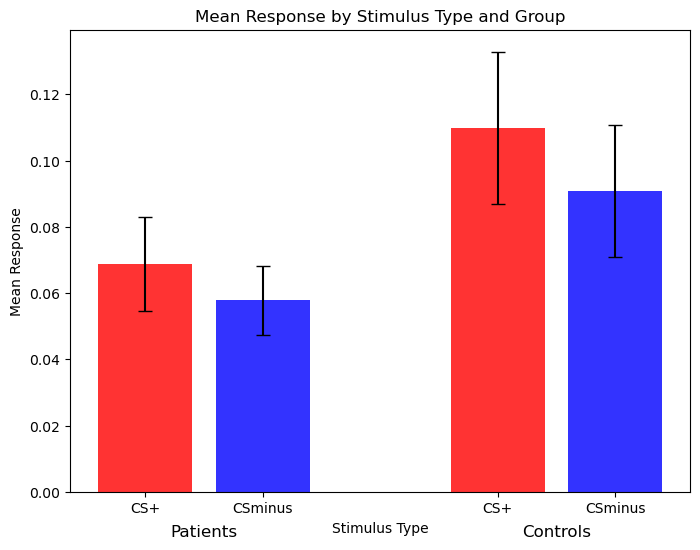

           Group 1          Group 2  t-statistic   p-value  \
0      patient CS+  patient CSminus     1.271687  0.209368   
1      control CS+  control CSminus     2.196095  0.032569   
2      patient CS+      control CS+    -1.524251  0.131100   
3  patient CSminus  control CSminus    -1.476443  0.143862   

            Test Type         df  
0       Paired t-test  50.000000  
1       Paired t-test  52.000000  
2  Independent t-test  86.362887  
3  Independent t-test  77.789268  


In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Calculate the mean of CSR and CSS for each subject to create CS+
merged_data['CS_plus'] = merged_data[['meanCSR1', 'meanCSS1']].mean(axis=1)

# Filter subjects where CS_plus - meanCSminus1 > 0
#filtered_data = merged_data[merged_data['CS_plus'] - merged_data['meanCSminus1'] > 0]

# # Count total, patient, and control subjects after filtering
# total_subjects_after = len(filtered_data)
# patients_after = filtered_data['patient_group'].sum()
# controls_after = total_subjects_after - patients_after

# # Calculate exclusions
# excluded_total = total_subjects_before - total_subjects_after
# excluded_patients = patients_before - patients_after
# excluded_controls = controls_before - controls_after

# # Calculate exclusion percentages
# excluded_total_pct = (excluded_total / total_subjects_before) * 100
# excluded_patients_pct = (excluded_patients / patients_before) * 100 if patients_before > 0 else 0
# excluded_controls_pct = (excluded_controls / controls_before) * 100 if controls_before > 0 else 0

# print(f"Total subjects excluded: {excluded_total} ({excluded_total_pct:.2f}%)")
# print(f"Patients excluded: {excluded_patients} ({excluded_patients_pct:.2f}%)")
# print(f"Controls excluded: {excluded_controls} ({excluded_controls_pct:.2f}%)")

# Reshape data to stack CS_plus and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group'], 
                    value_vars=['CS_plus', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'CS_plus': 'CS+', 
    'meanCSminus1': 'CSminus'
})

# Calculate means and errors
group_means = long_data.groupby(['patient_group', 'stim_type'])['response'].mean().reset_index()
group_sems = long_data.groupby(['patient_group', 'stim_type'])['response'].sem().reset_index()

# Set up custom x positions for the bars (grouped with a gap between patients and controls)
x_positions = {
    ('patient', 'CS+'): 0, ('patient', 'CSminus'): 1,
    ('control', 'CS+'): 3, ('control', 'CSminus'): 4
}

# Map x positions to data
group_means['x'] = group_means.apply(lambda row: x_positions[(row['patient_group'], row['stim_type'])], axis=1)
group_sems['x'] = group_means['x']

# Define colors for each stimulus type
stimulus_colors = {
    'CS+': 'red',
    'CSminus': 'blue'
}

# Plot bar chart
plt.figure(figsize=(8, 6), alpha=0.8)

for group in ['patient', 'control']:
    for stim in ['CS+', 'CSminus']:
        group_data = group_means[(group_means['patient_group'] == group) & (group_means['stim_type'] == stim)]
        group_errors = group_sems[(group_sems['patient_group'] == group) & (group_sems['stim_type'] == stim)]
        plt.bar(group_data['x'], group_data['response'], 
                color=stimulus_colors[stim], 
                label=stim if group == 'patient' else "",  # Label only for patients
                yerr=group_errors['response'], capsize=5, alpha=0.8)

# Initialize DataFrame to store t-test results
ttest_results = []

# Add significance markers and collect t-test results
def add_significance_markers(ax, comparisons, y_offset=0.02, bar_height=0.02):
    for (group1, stim1), (group2, stim2) in comparisons:
        if group1 == group2:
            # Paired t-test within the same group
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_rel(data1['response'], data2['response'])
            test_type = 'Paired t-test'
        else:
            # Independent t-test between groups
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group2) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_ind(data1['response'], data2['response'], equal_var=False)
            test_type = 'Independent t-test'
        
        # Store t-test results
        ttest_results.append({
            'Group 1': f"{group1} {stim1}",
            'Group 2': f"{group2} {stim2}",
            't-statistic': result.statistic,
            'p-value': result.pvalue,
            'Test Type': test_type, 
            'df': result.df,
        })
        
        # if result.pvalue < 0.05:  # Customize significance level if needed
        #     x1 = x_positions[(group1, stim1)]
        #     x2 = x_positions[(group2, stim2)]
        #     max_y = group_means['response'].max() + 0.025  # Adjust this if needed
        #     ax.plot([x1, x2], [max_y, max_y], 'k-', lw=1)
        #     ax.text((x1 + x2) / 2, max_y + 0.001, '*', ha='center', va='bottom')

# Define comparisons
comparisons = [
    (('patient', 'CS+'), ('patient', 'CSminus')),   # Patient CS+ vs CSminus
    (('control', 'CS+'), ('control', 'CSminus')),   # Control CS+ vs CSminus
    (('patient', 'CS+'), ('control', 'CS+')),       # Between-group CS+
    (('patient', 'CSminus'), ('control', 'CSminus')) # Between-group CSminus
]

add_significance_markers(plt.gca(), comparisons)

# Labeling and finalizing plot
plt.xticks([0, 1, 3, 4], ['CS+', 'CSminus', 'CS+', 'CSminus'])
plt.xlabel('Stimulus Type')
plt.ylabel('Mean Response')
plt.title('Mean Response by Stimulus Type and Group')

# Add x-axis labels to indicate groups
plt.text(0.5, -0.01, 'Patients', ha='center', va='top', fontsize=12)
plt.text(3.5, -0.01, 'Controls', ha='center', va='top', fontsize=12)

plt.savefig('cs+vscs-_phase1.png', format='png', dpi=300)

# plt.legend(title='Stimulus Type',loc='left')
plt.show()

# Create DataFrame from t-test results and print
ttest_results_df = pd.DataFrame(ttest_results)
print(ttest_results_df)


Paired t-test CS+ vs CS−
TtestResult(statistic=2.7648715170948415, pvalue=0.006748807478652748, df=103)


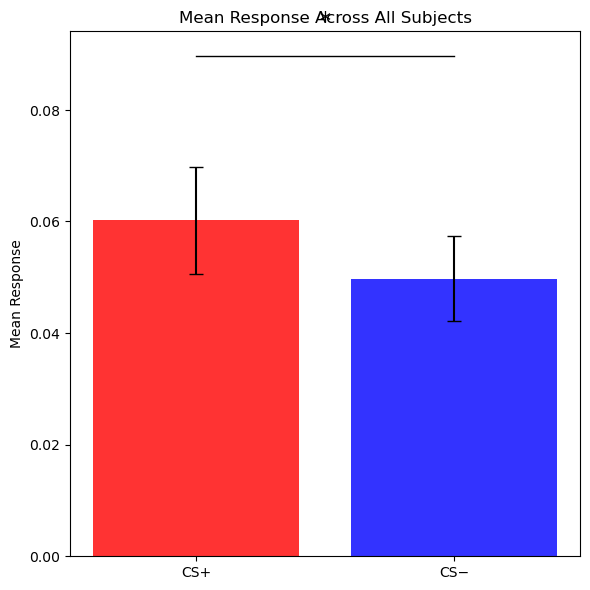

In [320]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Assuming 'dat' is a list of dictionaries created previously
dat_df = pd.DataFrame(dat)

# Load drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order'
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Compute CS+
merged_data['CS_plus'] = merged_data[['meanCSR1', 'meanCSS1']].mean(axis=1)

# Reshape to long format (but without patient/control)
long_data = pd.melt(
    merged_data,
    id_vars=['subID'],
    value_vars=['CS_plus', 'meanCSminus1'],
    var_name='stim_type',
    value_name='response'
)

# Rename stim types
long_data['stim_type'] = long_data['stim_type'].replace({
    'CS_plus': 'CS+',
    'meanCSminus1': 'CS−'
})

# ---- GROUP STATISTICS ----
group_means = long_data.groupby('stim_type')['response'].mean()
group_sems  = long_data.groupby('stim_type')['response'].sem()

# ---- PAIRED T-TEST ----
cs_plus_vals  = long_data[long_data['stim_type'] == 'CS+']['response']
cs_minus_vals = long_data[long_data['stim_type'] == 'CS−']['response']

ttest_result = stats.ttest_rel(cs_plus_vals, cs_minus_vals)

print("Paired t-test CS+ vs CS−")
print(ttest_result)

# ---- CREATE BAR PLOT ----
plt.figure(figsize=(6, 6))

x_positions = [0, 1]
plt.bar(
    x_positions,
    group_means.values,
    yerr=group_sems.values,
    capsize=5,
    color=['red', 'blue'],
    alpha=0.8
)

plt.xticks(x_positions, ['CS+', 'CS−'])
plt.ylabel('Mean Response')
plt.title('Mean Response Across All Subjects')

# ---- Significance Star ----
if ttest_result.pvalue < 0.05:
    y_max = group_means.max() + group_sems.max() + 0.02
    plt.plot([0, 1], [y_max, y_max], 'k-', lw=1)
    plt.text(0.5, y_max + 0.005, '*', ha='center', fontsize=16)

plt.tight_layout()
plt.savefig('csplus_vs_csminus_all_subjects.png', dpi=300)
plt.show()


In [227]:
# Calculate the mean of CSR and CSS for each subject to create CS+
merged_data['CS_combo'] = merged_data[['CS_plus', 'meanCSminus1']].mean(axis=1)
# Calculate means and errors
group_means = merged_data.groupby('patient_group')['CS_combo'].mean().reset_index()
group_sems = merged_data.groupby('patient_group')['CS_combo'].sem().reset_index()

In [229]:
group_means

,patient_group,CS_combo
0,control,0.067999
1,patient,0.041384


Patients (CSplus - CSminus) t-test: t = 0.224, p = 0.824
Controls (CSplus - CSminus) t-test: t = 2.197, p = 0.033
Between-group t-test (CSplus - CSminus): t = -1.747, p = 0.084


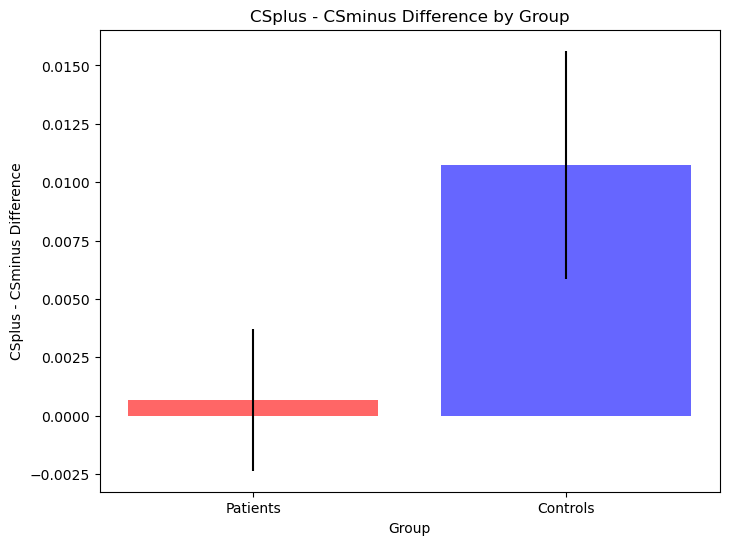

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Calculate the mean of CSR and CSS for each subject to create CS+
merged_data['CS_plus'] = merged_data[['meanCSR1', 'meanCSS1']].mean(axis=1)

# Calculate CSplus - CSminus for each participant
merged_data['CS_diff'] = merged_data['CS_plus'] - merged_data['meanCSminus1']

# Separate data for each group
patient_data = merged_data[merged_data['patient_group'] == 'patient']['CS_diff']
control_data = merged_data[merged_data['patient_group'] == 'control']['CS_diff']

# Plot the CSplus - CSminus difference for each group
plt.figure(figsize=(8, 6))

# Define bar positions and colors
positions = [0, 1]
colors = ['red', 'blue']

# Plot bars
plt.bar(positions[0], patient_data.mean(), yerr=stats.sem(patient_data), color=colors[0],alpha=0.6, label='Patients')
plt.bar(positions[1], control_data.mean(), yerr=stats.sem(control_data), color=colors[1],alpha=0.6, label='Controls')

# Add t-test results to the plot
# One-sample t-tests for each group
t_patient, p_patient = stats.ttest_1samp(patient_data, 0)
t_control, p_control = stats.ttest_1samp(control_data, 0)

# Independent t-test between groups
t_between, p_between = stats.ttest_ind(patient_data, control_data, equal_var=False)

# Print t-test results
print(f"Patients (CSplus - CSminus) t-test: t = {t_patient:.3f}, p = {p_patient:.3f}")
print(f"Controls (CSplus - CSminus) t-test: t = {t_control:.3f}, p = {p_control:.3f}")
print(f"Between-group t-test (CSplus - CSminus): t = {t_between:.3f}, p = {p_between:.3f}")

# # Annotate significance on the plot if p < 0.05
# max_y = max(patient_data.mean(), control_data.mean()) + 0.1
# if p_patient < 0.05:
#     plt.text(positions[0], max_y, '*', ha='center', fontsize=14)
# if p_control < 0.05:
#     plt.text(positions[1], max_y, '*', ha='center', fontsize=14)
# if p_between < 0.05:
#     plt.plot(positions, [max_y + 0.05, max_y + 0.05], 'k-', lw=1)
#     plt.text(sum(positions)/2, max_y + 0.06, '*', ha='center', fontsize=14)

# Finalize the plot
plt.xticks(positions, ['Patients', 'Controls'])
plt.xlabel('Group')
plt.ylabel('CSplus - CSminus Difference')
plt.title('CSplus - CSminus Difference by Group')
# plt.legend()
plt.savefig('cs+-cs-_phase1.png', format='png', dpi=300)

plt.show()


Patients (CSplus - CSminus) t-test: t = 1.111, p = 0.272
Controls (CSplus - CSminus) t-test: t = 2.150, p = 0.036
Between-group t-test (CSplus - CSminus): t = -0.709, p = 0.480


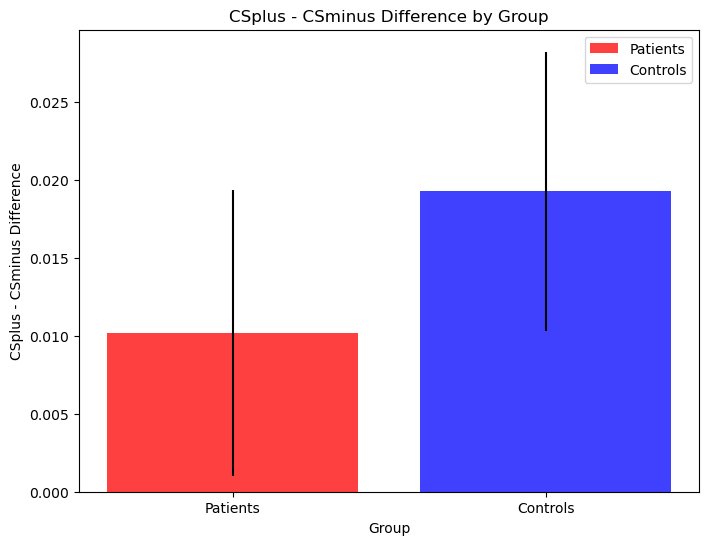

In [ ]:
### excluding sub-clinical LSAS (removing 3 SAD, 2 HC) 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Exclude specific subjects
excluded_subjects = ['N114', 'N118', 'N121', 'N238', 'N251']
merged_data = merged_data[~merged_data['subID'].isin(excluded_subjects)]

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Calculate the mean of CSR and CSS for each subject to create CS+
merged_data['CS_plus'] = merged_data[['meanCSR1', 'meanCSS1']].mean(axis=1)

# Calculate CSplus - CSminus for each participant
merged_data['CS_diff'] = merged_data['CS_plus'] - merged_data['meanCSminus1']

# Separate data for each group
patient_data = merged_data[merged_data['patient_group'] == 'patient']['CS_diff']
control_data = merged_data[merged_data['patient_group'] == 'control']['CS_diff']

# Plot the CSplus - CSminus difference for each group
plt.figure(figsize=(8, 6))

# Define bar positions and colors
positions = [0, 1]
colors = ['red', 'blue']

# Plot bars
plt.bar(positions[0], patient_data.mean(), yerr=stats.sem(patient_data), color=colors[0],alpha = 0.75, label='Patients')
plt.bar(positions[1], control_data.mean(), yerr=stats.sem(control_data), color=colors[1], alpha = 0.75, label='Controls')

# Add t-test results to the plot
# One-sample t-tests for each group
t_patient, p_patient = stats.ttest_1samp(patient_data, 0)
t_control, p_control = stats.ttest_1samp(control_data, 0)

# Independent t-test between groups
t_between, p_between = stats.ttest_ind(patient_data, control_data, equal_var=False)

# Print t-test results
print(f"Patients (CSplus - CSminus) t-test: t = {t_patient:.3f}, p = {p_patient:.3f}")
print(f"Controls (CSplus - CSminus) t-test: t = {t_control:.3f}, p = {p_control:.3f}")
print(f"Between-group t-test (CSplus - CSminus): t = {t_between:.3f}, p = {p_between:.3f}")

# # Annotate significance on the plot if p < 0.05
# max_y = max(patient_data.mean(), control_data.mean()) + 0.1
# if p_patient < 0.05:
#     plt.text(positions[0], max_y, '*', ha='center', fontsize=14)
# if p_control < 0.05:
#     plt.text(positions[1], max_y, '*', ha='center', fontsize=14)
# if p_between < 0.05:
#     plt.plot(positions, [max_y + 0.05, max_y + 0.05], 'k-', lw=1)
#     plt.text(sum(positions)/2, max_y + 0.06, '*', ha='center', fontsize=14)

# Finalize the plot
plt.xticks(positions, ['Patients', 'Controls'])
plt.xlabel('Group')
plt.ylabel('CSplus - CSminus Difference')
plt.title('CSplus - CSminus Difference by Group')
plt.legend()
plt.savefig('cs+-cs-_phase1.png', format='png', dpi=300)
plt.show()


In [ ]:
### also w outlier removal 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Exclude specific subjects
excluded_subjects = ['N114', 'N118', 'N121', 'N238', 'N251']
merged_data = merged_data[~merged_data['subID'].isin(excluded_subjects)]

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Calculate the mean of CSR and CSS for each subject to create CS+
merged_data['CS_plus'] = merged_data[['meanCSR1', 'meanCSS1']].mean(axis=1)

# Calculate CSplus - CSminus for each participant
merged_data['CS_diff'] = merged_data['CS_plus'] - merged_data['meanCSminus1']

# Define a function to remove outliers using IQR and return outlier-free data along with count of exclusions
def remove_outliers(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]
    exclusions = len(data) - len(filtered_data)
    return filtered_data, exclusions

# Apply outlier removal to each group and calculate exclusions
initial_patient_count = len(merged_data[merged_data['patient_group'] == 'patient'])
initial_control_count = len(merged_data[merged_data['patient_group'] == 'control'])

patient_data, patient_exclusions = remove_outliers(merged_data[merged_data['patient_group'] == 'patient']['CS_diff'])
control_data, control_exclusions = remove_outliers(merged_data[merged_data['patient_group'] == 'control']['CS_diff'])

# Calculate exclusion percentages
patient_exclusion_pct = (patient_exclusions / initial_patient_count) * 100
control_exclusion_pct = (control_exclusions / initial_control_count) * 100

# Print exclusion stats
print(f"Patients excluded due to outliers: {patient_exclusions} ({patient_exclusion_pct:.2f}%) out of {initial_patient_count}")
print(f"Controls excluded due to outliers: {control_exclusions} ({control_exclusion_pct:.2f}%) out of {initial_control_count}")

# Plot the CSplus - CSminus difference for each group
plt.figure(figsize=(8, 6))

# Define bar positions and colors
positions = [0, 1]
colors = ['red', 'blue']

# Plot bars
plt.bar(positions[0], patient_data.mean(), yerr=stats.sem(patient_data), color=colors[0],alpha = 0.75, label='Patients')
plt.bar(positions[1], control_data.mean(), yerr=stats.sem(control_data), color=colors[1], alpha=0.75, label='Controls')

# Add t-test results to the plot
# One-sample t-tests for each group
t_patient, p_patient = stats.ttest_1samp(patient_data, 0)
t_control, p_control = stats.ttest_1samp(control_data, 0)

# Independent t-test between groups
t_between, p_between = stats.ttest_ind(patient_data, control_data, equal_var=False)

# Print t-test results
print(f"Patients (CSplus - CSminus) t-test: t = {t_patient:.3f}, p = {p_patient:.3f}")
print(f"Controls (CSplus - CSminus) t-test: t = {t_control:.3f}, p = {p_control:.3f}")
print(f"Between-group t-test (CSplus - CSminus): t = {t_between:.3f}, p = {p_between:.3f}")

# # Annotate significance on the plot if p < 0.05
# max_y = max(patient_data.mean(), control_data.mean()) + 0.1
# if p_patient < 0.05:
#     plt.text(positions[0], max_y, '*', ha='center', fontsize=14)
# if p_control < 0.05:
#     plt.text(positions[1], max_y, '*', ha='center', fontsize=14)
# if p_between < 0.05:
#     plt.plot(positions, [max_y + 0.05, max_y + 0.05], 'k-', lw=1)
#     plt.text(sum(positions)/2, max_y + 0.06, '*', ha='center', fontsize=14)

# Finalize the plot
plt.xticks(positions, ['Patients', 'Controls'])
plt.xlabel('Group')
plt.ylabel('CSplus - CSminus Difference')
plt.title('CSplus - CSminus Difference by Group (Outliers Removed)')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# # Exclude specific subjects
# excluded_subjects = ['N114', 'N118', 'N121', 'N238', 'N251']
# merged_data = merged_data[~merged_data['subID'].isin(excluded_subjects)]

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Calculate the mean of CSR and CSS for each subject to create CS+
merged_data['CS_plus'] = merged_data[['meanCSR1', 'meanCSS1']].mean(axis=1)

# Calculate CSplus - CSminus for each participant
merged_data['CS_diff'] = merged_data['CS_plus'] - merged_data['meanCSminus1']

### Outlier removal
def remove_outliers(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (data >= lower_bound) & (data <= upper_bound)

# Apply outlier removal to each group
filtered_data = merged_data.groupby('patient_group').apply(
    lambda x: x[remove_outliers(x['CS_diff']).values]
).reset_index(drop=True)

# Calculate exclusions
initial_counts = merged_data.groupby('patient_group').size()
final_counts = filtered_data.groupby('patient_group').size()
exclusions = initial_counts - final_counts
exclusion_pct = (exclusions / initial_counts * 100).round(2)

# Print exclusion stats
print(f"Patients excluded due to outliers: {exclusions['patient']} ({exclusion_pct['patient']}%) out of {initial_counts['patient']}")
print(f"Controls excluded due to outliers: {exclusions['control']} ({exclusion_pct['control']}%) out of {initial_counts['control']}")

# Plot using Seaborn catplot
# sns.catplot(
#     data=merged_data,
#     # data=filtered_data, #uncomment for outlier removal
#     x='patient_group',
#     y='CS_diff',
#     kind='strip',
#     hue='patient_group',
#     dodge=True,
#     palette={'patient': 'red', 'control': 'blue'}
# )

sns.violinplot(
    data=merged_data,
    # data=filtered_data, #uncomment for outlier removal
    x='patient_group',
    y='CS_diff',
    hue='patient_group',
    palette={'patient': 'red', 'control': 'blue'}
)
plt.xlabel('Group')
plt.ylabel('CSplus - CSminus Difference')
plt.title('CSplus - CSminus Difference by Group')

# Run t-tests on the filtered data
patient_data = filtered_data[filtered_data['patient_group'] == 'patient']['CS_diff']
control_data = filtered_data[filtered_data['patient_group'] == 'control']['CS_diff']

# One-sample t-tests for each group
t_patient, p_patient = stats.ttest_1samp(patient_data, 0)
t_control, p_control = stats.ttest_1samp(control_data, 0)

# Independent t-test between groups
t_between, p_between = stats.ttest_ind(patient_data, control_data, equal_var=False)

# Display t-test results
print(f"Patients (CSplus - CSminus) t-test: t = {t_patient:.3f}, p = {p_patient:.3f}")
print(f"Controls (CSplus - CSminus) t-test: t = {t_control:.3f}, p = {p_control:.3f}")
print(f"Between-group t-test (CSplus - CSminus): t = {t_between:.3f}, p = {p_between:.3f}")

plt.show()


### Phase 2 / 3 - averaged across the whole phase

In [368]:
## RUN TO RELOAD DATA (RESET WHETHER EXCLUDING FIRST TRIAL OR NOT)

import pandas as pd
import numpy as np

excludefirstrial = []
excludefirstrial = 1

if excludefirstrial == 0: 
# Parameters to adjust:
    trialnumber2 = range(1, 25)  # Adjust this range to analyze specific trials (e.g., first half = range(1, 13))
    trialnumber3 = range(25, 37) # Adjust this range for phase 3 analysis (e.g., range(25, 37) for first half)
    #trialnumber3 = range(37,48) # second half of reinstatement only
else: 
    trialnumber2 = range(1, 25)
    trialnumber3 = range(26, 37) #excluding first 3 trials 
    #trialnumber3 = range(37,48) # second half of reinstatement only 

excludeparticipants = 1  # Set to 0 to include all subjects; if set to 1, participants with rejected trials >= rejtrials_threshold are excluded
rejtrials_threshold = 24  # Threshold for trial rejection; adjust according to trial number

# Load data
peakstatstable = pd.read_csv('peak_stats_table-phase2.3.csv')
participants = peakstatstable['sid'].unique()
trial_types = peakstatstable['stTy'].unique()

# Separate data by participant, phase, and stim type
grouped_data = peakstatstable.groupby('sid')
dat = []

for participant in participants:
    data = grouped_data.get_group(participant)
    participant_data = {'subID': participant}

    # Ensuring consistent data structure
    if data.shape[0] > 1:
        
        # Phase 2 processing: stims numbered in trialnumber2
        phase2_data = data[data['stNum'].isin(trialnumber2)]
        rejTrials = phase2_data[phase2_data['phaBase2Peak'] < 0.02].index
        phase2_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials2'] = len(rejTrials)

        # Separate out stim types
        data2 = {key: value for key, value in phase2_data.groupby('stTy')}
        try:
            participant_data['meanCSS2'] = data2['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS2'] = data2['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data2['CS+S']))
            participant_data['nCSS2'] = len(data2['CS+S'])
            participant_data['meanCSR2'] = data2['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR2'] = data2['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data2['CS+R']))
            participant_data['nCSR2'] = len(data2['CS+R'])
            participant_data['meanCSminus2'] = data2['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus2'] = data2['CS-']['phaBase2Peak'].std() / np.sqrt(len(data2['CS-']))
            participant_data['nCSminus2'] = len(data2['CS-'])
        except KeyError:
            # Handle missing data if any stimulus type is not present for a participant
            print(f"Missing data for participant {participant} in Phase 2.")

        # Phase 3 processing: stims numbered in trialnumber3
        phase3_data = data[data['stNum'].isin(trialnumber3)]
        rejTrials = phase3_data[phase3_data['phaBase2Peak'] < 0.02].index
        phase3_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials3'] = len(rejTrials)

        # Separate out stim types
        data3 = {key: value for key, value in phase3_data.groupby('stTy')}
        try:
            participant_data['meanCSS3'] = data3['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS3'] = data3['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data3['CS+S']))
            participant_data['nCSS3'] = len(data3['CS+S'])
            participant_data['meanCSR3'] = data3['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR3'] = data3['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data3['CS+R']))
            participant_data['nCSR3'] = len(data3['CS+R'])
            participant_data['meanCSminus3'] = data3['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus3'] = data3['CS-']['phaBase2Peak'].std() / np.sqrt(len(data3['CS-']))
            participant_data['nCSminus3'] = len(data3['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 3.")

    # Add participant data to the main list
    dat.append(participant_data)

# Convert dat list to a DataFrame for easier viewing and export
dat_df = pd.DataFrame(dat)
print(dat_df)


    subID  rejTrials2  meanCSS2    seCSS2  nCSS2  meanCSR2    seCSR2  nCSR2  \
0    N101           3  0.020250  0.002957      8  0.031750  0.010813      8   
1    N103           4  0.032625  0.003105      8  0.024875  0.013315      8   
2    N104           4  0.016125  0.003543      8  0.016000  0.003505      8   
3    N105           5  0.018000  0.003973      8  0.020000  0.002928      8   
4    N106           0  0.025000  0.001000      8  0.027625  0.002104      8   
..    ...         ...       ...       ...    ...       ...       ...    ...   
96   N255           0  0.032500  0.002228      8  0.034625  0.004263      8   
97   N257           3  0.020500  0.002958      8  0.020125  0.002900      8   
98   N258           0  0.029625  0.000885      8  0.029500  0.000945      8   
99   N259           0  0.032250  0.000590      8  0.031375  0.000420      8   
100  N260          11  0.023125  0.009516      8  0.054875  0.022743      8   

     meanCSminus2  seCSminus2  ...  rejTrials3  mea

In [99]:
#### filtering by contigency q = correct: 
path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

import pandas as pd

# Load your contingency data
cont_df = pd.read_excel('contingencies.xlsx')

# Define correct response pattern
correct_pattern = np.array([1, 1, 1, 1, 0])

# Identify relevant columns (excluding ID)
cont_cols = cont_df.columns[1:6]

# Ensure numeric values (in case there are strings)
cont_values = cont_df[cont_cols].apply(pd.to_numeric, errors='coerce').values

# Compare each row to the correct pattern
mask = np.all(cont_values == correct_pattern, axis=1)

# Get IDs of correct learners
learned_ids = cont_df.loc[mask, 'login_participantid'].astype(str)

# Filter your main dataframe
dat_df_filtered = dat_df[dat_df['subID'].astype(str).isin(learned_ids)]

# ---- Summary stats ----
total_n = len(dat_df)
included_n = len(dat_df_filtered)
excluded_n = total_n - included_n
excluded_pct = (excluded_n / total_n) * 100

# Define patient/control subsets
dat_df['group'] = dat_df['subID'].astype(str).str[1:4].astype(int).apply(
    lambda x: 'patient' if 100 <= x < 200 else ('control' if 200 <= x < 300 else 'other')
)

# Count by group before filtering
group_counts_before = dat_df['group'].value_counts()

# Count by group after filtering
group_counts_after = dat_df_filtered.merge(dat_df[['subID', 'group']], on='subID', how='left')['group'].value_counts()

# Calculate exclusions per group
for group in ['patient', 'control']:
    before = group_counts_before.get(group, 0)
    after = group_counts_after.get(group, 0)
    excluded = before - after
    pct_excluded = (excluded / before * 100) if before > 0 else 0
    print(f"{group.capitalize()}s excluded: {excluded} / {before} ({pct_excluded:.1f}%)")

# ---- Overall summary ----
print("\n=== Summary ===")
print(f"Total subjects before filtering: {total_n}")
print(f"Subjects included (learned correctly): {included_n}")
print(f"Subjects excluded: {excluded_n} ({excluded_pct:.1f}%)")

dat_df = dat_df_filtered

path = '/Volumes/Seagate Desktop Drive/NARSAD/SCR'
os.chdir(path)

Patients excluded: 16 / 49 (32.7%)
Controls excluded: 9 / 52 (17.3%)

=== Summary ===
Total subjects before filtering: 101
Subjects included (learned correctly): 76
Subjects excluded: 25 (24.8%)


#### Extinction

In [362]:
import os
import pandas as pd
import numpy as np

# -------------------------
# PARAMETERS
# -------------------------
excludefirstrial = 1

if excludefirstrial == 0: 
    trialnumber2 = range(1, 25)
    trialnumber3 = range(25, 49)
else: 
    trialnumber2 = range(1, 25)
    trialnumber3 = range(26, 49)   # excludes first 3 trials of phase 3

rej_threshold = 0.02        # treat < 0.02 SCR as non-response (set to 0)

path = '/Volumes/Seagate Desktop Drive/NARSAD/SCR'
os.chdir(path)

peakstatstable = pd.read_csv('peak_stats_table-phase2.3.csv')

# -------------------------
# TRIAL-WISE CLEANING
# -------------------------

# Mark rejected SCR trials
peakstatstable['phaBase2Peak'] = np.where(
    peakstatstable['phaBase2Peak'] < rej_threshold,
    0,
    peakstatstable['phaBase2Peak']
)

# Annotate phase variable
peakstatstable['phase'] = np.where(
    peakstatstable['stNum'].isin(trialnumber2), 2,
    np.where(peakstatstable['stNum'].isin(trialnumber3), 3, np.nan)
)

# Keep trials belonging to phase 2 or 3 ranges
trialwise = peakstatstable[peakstatstable['phase'].notna()].copy()

# Keep only the trial numbers we want
trialwise = trialwise[
     trialwise['stNum'].isin(trialnumber2) 
    # #| 
    #trialwise['stNum'].isin(trialnumber3)
].copy()

# Rename for consistency
trialwise.rename(columns={'sid': 'subID'}, inplace=True)

print(trialwise.head())
print("Trial-wise rows:", len(trialwise))


  subID  stTy  stNum  bTime  tonBase  phaBase  phaMax  phaBase2Peak  \
0  N101   CS-      1  728.3    3.765   -0.014   0.009         0.023   
1  N101  CS+R      2  747.3    3.735   -0.016   0.022         0.037   
2  N101  CS+S      3  766.3    3.708   -0.018   0.002         0.020   
3  N101  CS+S      4  786.3    3.849    0.001   0.015         0.000   
4  N101  CS+R      5  804.3    3.791   -0.061   0.041         0.103   

   phaPeakLatency  phaMinLatency  USPeakLatency  phaMaxUS  USminLatency  \
0           732.6          732.1          734.6  0.009600         734.3   
1           750.6          747.7          753.3  0.012400         753.3   
2           768.6          768.1          772.9 -0.001971         772.5   
3           788.6          787.4          794.6  0.009572         793.4   
4           809.8          807.8          810.6  0.066508         810.3   

   phaMinUS  USbase2peak  bad  phase  
0  0.002594        0.007    0    2.0  
1  0.012400        0.000    0    2.0  
2 -0.

In [367]:
### placebo:
# 
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Load drug assignment + gender table
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge with trial-wise data
merged = pd.merge(trialwise, drug_order, on='subID', how='inner')

# -------------------------
# KEEP ONLY PLACEBO SUBJECTS
# -------------------------
# drug_condition is the column from drug_order, so we must filter before renaming it:
merged = merged[merged['drug_condition'] == 0].copy()

# -------------------------
# Add predictors
# -------------------------
merged['patient_group'] = np.where(merged['subID'].str.startswith('N1'), 1, 0)
merged['gender'] = merged['gender_code']
merged['drug'] = merged['drug_condition']  # still set it, but will all be 0

# Stim type numerical coding
merged['stim_type'] = merged['stTy'].replace({
    'CS+R': 1,
    'CS+S': 2,
    'CS-':  0
})

# -------------------------
# FIXED EFFECTS MODEL FORMULA
# -------------------------
model_formula = (
    "phaBase2Peak ~ patient_group + gender + stim_type "
)

# -------------------------
# TRIAL-WISE MIXED MODEL
# -------------------------
model = smf.mixedlm(
    formula=model_formula,
    data=merged,
    groups=merged["subID"],  # random intercept
).fit()

print(model.summary())
 

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: phaBase2Peak
No. Observations: 1200    Method:             REML        
No. Groups:       50      Scale:              0.0053      
Min. group size:  24      Log-Likelihood:     1364.2593   
Max. group size:  24      Converged:          Yes         
Mean group size:  24.0                                    
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.034    0.014  2.535 0.011  0.008  0.061
patient_group   -0.016    0.016 -1.026 0.305 -0.048  0.015
gender           0.007    0.016  0.436 0.663 -0.024  0.038
stim_type        0.006    0.003  2.154 0.031  0.000  0.011
Group Var        0.003    0.009                           



/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_37432/106310101.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged['stim_type'] = merged['stTy'].replace({
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [364]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Load drug assignment + gender table
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge with trial-wise data
merged = pd.merge(trialwise, drug_order, on='subID', how='inner')

# -------------------------
# Add predictors
# -------------------------
merged['patient_group'] = np.where(merged['subID'].str.startswith('N1'), 1, 0)
merged['gender'] = merged['gender_code']
merged['drug'] = merged['drug_condition']

# Stim type numerical coding
merged['stim_type'] = merged['stTy'].replace({
    'CS+R': 1,
    'CS+S': 2,
    'CS-':  0
})


# -------------------------
# FIXED EFFECTS MODEL FORMULA
# (Equivalent to your request but trial-level)
# -------------------------
model_formula = (
    "phaBase2Peak ~ patient_group + drug + gender + stim_type "
    " + patient_group:drug"
    " + drug:gender"
    " + stim_type:drug:gender"
)

# -------------------------
# TRIAL-WISE MIXED MODEL
# -------------------------
model = smf.mixedlm(
    formula=model_formula,
    data=merged,
    groups=merged["subID"],          # random intercept
).fit()

print(model.summary())


/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_37432/2500947771.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged['stim_type'] = merged['stTy'].replace({
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   phaBase2Peak
No. Observations:   2424      Method:               REML        
No. Groups:         101       Scale:                0.0035      
Min. group size:    24        Log-Likelihood:       3247.6118   
Max. group size:    24        Converged:            Yes         
Mean group size:    24.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.037    0.010  3.665 0.000  0.017  0.057
patient_group         -0.016    0.012 -1.366 0.172 -0.040  0.007
drug                  -0.016    0.014 -1.111 0.267 -0.044  0.012
gender                 0.007    0.012  0.580 0.562 -0.017  0.030
stim_type              0.003    0.002  1.641 0.101 -0.001  0.006
patient_group:drug     0.024    0.017  

In [271]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR2', 'meanCSS2', 'meanCSminus2'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR2': 1, 
    'meanCSS2': 2, 
    'meanCSminus2': 3
})

# Specify the model without intercept
model_formula = (
    'response ~ patient_group + drug + gender + stim_type'
 #   ' + patient_group:drug'
 #   ' + gender:drug'
    ' + drug:stim_type'
 #   ' + gender:drug:stim_type'
)

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9072
Date:                Mon, 17 Nov 2025   Prob (F-statistic):              0.477
Time:                        15:38:45   Log-Likelihood:                 507.77
No. Observations:                 303   AIC:                            -1004.
Df Residuals:                     297   BIC:                            -981.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0404      0.010      3.

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_37432/91207257.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


In [268]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Load drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']
merged_data['drug'] = merged_data['drug_condition']

# Create the new response variable: difference score
merged_data['response'] = merged_data['meanCSR2'] - merged_data['meanCSS2']

# Model formula with main effects + specified interactions
model_formula = (
    'response ~ patient_group + drug + gender'
    ' + patient_group:drug'
    ' + gender:drug'
 #   ' + patient_group:drug:gender'
)

# Fit model
model = smf.ols(formula=model_formula, data=merged_data).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     1.707
Date:                Mon, 17 Nov 2025   Prob (F-statistic):              0.140
Time:                        15:15:09   Log-Likelihood:                 229.59
No. Observations:                 101   AIC:                            -447.2
Df Residuals:                      95   BIC:                            -431.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0107      0

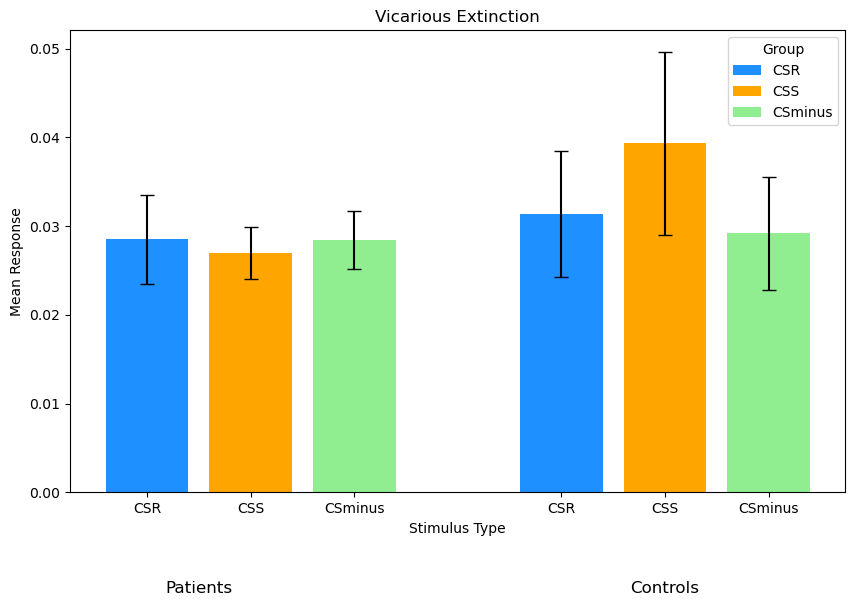

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group'], 
                    value_vars=['meanCSR2', 'meanCSS2', 'meanCSminus2'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR2': 'CSR', 
    'meanCSS2': 'CSS', 
    'meanCSminus2': 'CSminus'
})

# Calculate means and errors
group_means = long_data.groupby(['patient_group', 'stim_type'])['response'].mean().reset_index()
group_sems = long_data.groupby(['patient_group', 'stim_type'])['response'].sem().reset_index()

# Set up custom x positions for the bars (grouped with a gap between patients and controls)
x_positions = {
    ('patient', 'CSR'): 0, ('patient', 'CSS'): 1, ('patient', 'CSminus'): 2,
    ('control', 'CSR'): 4, ('control', 'CSS'): 5, ('control', 'CSminus'): 6
}

# Map x positions to data
group_means['x'] = group_means.apply(lambda row: x_positions[(row['patient_group'], row['stim_type'])], axis=1)
group_sems['x'] = group_means['x']

# Define colors for each stimulus type
stimulus_colors = {
    'CSR': 'dodgerblue',
    'CSS': 'orange',
    'CSminus': 'lightgreen'
}

# Plot bar chart
plt.figure(figsize=(10, 6))

for group in ['patient', 'control']:
    for stim in ['CSR', 'CSS', 'CSminus']:
        group_data = group_means[(group_means['patient_group'] == group) & (group_means['stim_type'] == stim)]
        group_errors = group_sems[(group_sems['patient_group'] == group) & (group_sems['stim_type'] == stim)]
        plt.bar(group_data['x'], group_data['response'], 
                color=stimulus_colors[stim], 
                label=stim if group == 'patient' else "",  # Label only for patients
                yerr=group_errors['response'], capsize=5)

# Add significance markers
def add_significance_markers(ax, comparisons, y_offset=0.02, bar_height=0.02):
    for (group1, stim1), (group2, stim2) in comparisons:
        if group1 == group2:
            # Paired t-test within the same group
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_rel(data1['response'], data2['response'])
        else:
            # Independent t-test between groups
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group2) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_ind(data1['response'], data2['response'], equal_var=False)
        
        if result.pvalue < 0.05:  # Customize significance level if needed
            x1 = x_positions[(group1, stim1)]
            x2 = x_positions[(group2, stim2)]
            max_y = group_means['response'].max() + 0.025  # Adjust this if needed
            ax.plot([x1, x2], [max_y, max_y], 'k-', lw=1)
            ax.text((x1 + x2) / 2, max_y + 0.001, '*', ha='center', va='bottom')

# Define comparisons
comparisons = [
    (('patient', 'CSR'), ('patient', 'CSS')),   # Patient CSR vs CSS
    (('patient', 'CSR'), ('patient', 'CSminus')),  # Patient CSR vs CSminus
    (('patient', 'CSS'), ('patient', 'CSminus')),  # Patient CSS vs CSminus
    (('control', 'CSR'), ('control', 'CSS')),   # Control CSR vs CSS
    (('control', 'CSR'), ('control', 'CSminus')),  # Control CSR vs CSminus
    (('control', 'CSS'), ('control', 'CSminus')),  # Control CSS vs CSminus
    (('patient', 'CSR'), ('control', 'CSR')),    # Between-group CSR
    (('patient', 'CSS'), ('control', 'CSS')),    # Between-group CSS
    (('patient', 'CSminus'), ('control', 'CSminus')) # Between-group CSminus
]

add_significance_markers(plt.gca(), comparisons)
# Add x-axis labels to indicate groups
plt.text(0.5, -0.01, 'Patients', ha='center', va='top', fontsize=12)
plt.text(5, -0.01, 'Controls', ha='center', va='top', fontsize=12)

# Labeling and finalizing plot
plt.xticks([0, 1, 2, 4, 5, 6], ['CSR', 'CSS', 'CSminus', 'CSR', 'CSS', 'CSminus'])
plt.xlabel('Stimulus Type')
plt.ylabel('Mean Response')
plt.title('Vicarious Extinction')
plt.legend(title='Group')
plt.show()


In [100]:
#### just placebo condition! 

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Filter to include only individuals in the placebo condition (drug_order = 0)
merged_data = merged_data[merged_data['drug_condition'] == 0]

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group',  'gender'], 
                    value_vars=['meanCSR2', 'meanCSS2', 'meanCSminus2'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR2': 1, 
    'meanCSS2': 2, 
    'meanCSminus2': 3
})

# Specify the model without intercept
model_formula = 'response ~ patient_group + stim_type + gender'  # Removed 'drug' from model since all are placebo

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.7649
Date:                Mon, 10 Nov 2025   Prob (F-statistic):              0.516
Time:                        10:14:23   Log-Likelihood:                 147.53
No. Observations:                 114   AIC:                            -287.1
Df Residuals:                     110   BIC:                            -276.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0506      0.019      2.703

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_37432/2098309525.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


Patient group CSR-CSS vs 0: t = -0.05, p = 0.964, df=21.000
Control group CSR-CSS vs 0: t = -2.10, p = 0.045, df=27.000
Between-group CSR-CSS comparison: t = 1.84, p = 0.074, df=40.293


/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_37432/2456544314.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='patient_group', y='CSR_CSS', errorbar='se', palette=['red', 'blue'],alpha = 0.75)


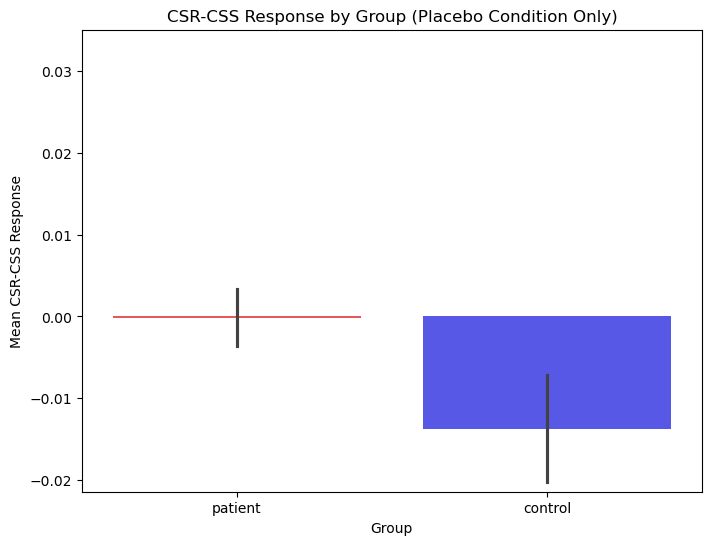

In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Filter to include only individuals in the placebo condition (drug_order = 0)
merged_data = merged_data[merged_data['drug_condition'] == 0]

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Calculate CSR-CSS difference
merged_data['CSR_CSS'] = merged_data['meanCSR2'] - merged_data['meanCSS2']

# Extract data for plotting
plot_data = merged_data[['subID', 'patient_group', 'CSR_CSS']]

# Plot the CSR-CSS response by group
plt.figure(figsize=(8, 6))
sns.barplot(data=plot_data, x='patient_group', y='CSR_CSS', errorbar='se', palette=['red', 'blue'],alpha = 0.75)

# Add labels
plt.xlabel('Group')
plt.ylabel('Mean CSR-CSS Response')
plt.ylim(top=0.035)
plt.title('CSR-CSS Response by Group (Placebo Condition Only)')

# Perform post-hoc t-tests
# Test if CSR-CSS is different from 0 within each group
patient_data = plot_data[plot_data['patient_group'] == 'patient']['CSR_CSS']
control_data = plot_data[plot_data['patient_group'] == 'control']['CSR_CSS']

# One-sample t-test within each group
patient_ttest = stats.ttest_1samp(patient_data, 0)
control_ttest = stats.ttest_1samp(control_data, 0)

print("Patient group CSR-CSS vs 0: t = {:.2f}, p = {:.3f}, df={:.3f}".format(patient_ttest.statistic, patient_ttest.pvalue, patient_ttest.df))
print("Control group CSR-CSS vs 0: t = {:.2f}, p = {:.3f}, df={:.3f}".format(control_ttest.statistic, control_ttest.pvalue, control_ttest.df))

# Independent t-test between groups
between_groups_ttest = stats.ttest_ind(patient_data, control_data, equal_var=False)
print("Between-group CSR-CSS comparison: t = {:.2f}, p = {:.3f}, df={:.3f}".format(between_groups_ttest.statistic, between_groups_ttest.pvalue, between_groups_ttest.df))

# Display plot
plt.show()


#### Reinstatement

In [272]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR3', 'meanCSS3', 'meanCSminus3'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR3': 1, 
    'meanCSS3': 2, 
    'meanCSminus3': 3
})

# Specify the model without intercept
# model_formula = 'response ~ patient_group * drug + drug * gender + stim_type'
model_formula = (
    'response ~ patient_group + drug + gender + stim_type'
 #   ' + patient_group:drug'
 #   ' + gender:drug'
 #   ' + drug:stim_type'
   ' + gender:drug:stim_type'
)

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     3.289
Date:                Mon, 17 Nov 2025   Prob (F-statistic):            0.00660
Time:                        15:46:07   Log-Likelihood:                 285.24
No. Observations:                 303   AIC:                            -558.5
Df Residuals:                     297   BIC:                            -536.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.08

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_37432/1091853128.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


In [370]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order'
merged_data = pd.merge(dat_df, drug_order, on='subID', how='inner')
merged_data = merged_data[merged_data['drug_condition'] == 0].copy()

# Prepare variables
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']
merged_data['drug'] = merged_data['drug_condition']

# Long format
long_data = pd.melt(
    merged_data,
    id_vars=['subID', 'patient_group', 'drug', 'gender'],
    value_vars=['meanCSR3', 'meanCSS3', 'meanCSminus3'],
    var_name='stim_type',
    value_name='response'
)

# Map stim types
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR3': 1,
    'meanCSS3': 2,
    'meanCSminus3': 3
})

# Mixed-effects model (random intercept for subjects)
model_formula = (
    'response ~ patient_group + gender + stim_type'
)

model = smf.mixedlm(
    formula=model_formula,
    data=long_data,
    groups=long_data['subID'],        # random intercept for each subject
).fit()

# model = smf.mixedlm(
#     formula=model_formula,
#     data=long_data,
#     groups=long_data['subID'],
#     re_formula="~ stim_type"   # random slope
# ).fit()


print(model.summary())


         Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: response
No. Observations:   150     Method:             REML    
No. Groups:         50      Scale:              0.0026  
Min. group size:    3       Log-Likelihood:     169.8199
Max. group size:    3       Converged:          Yes     
Mean group size:    3.0                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.096    0.022  4.300 0.000  0.052  0.140
patient_group  0.001    0.024  0.057 0.955 -0.046  0.049
gender         0.043    0.024  1.800 0.072 -0.004  0.091
stim_type     -0.026    0.005 -5.122 0.000 -0.036 -0.016
Group Var      0.006    0.035                           



/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_37432/3334502233.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [344]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order'
merged_data = pd.merge(dat_df, drug_order, on='subID', how='inner')

# Prepare variables
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']
merged_data['drug'] = merged_data['drug_condition']

# Long format
long_data = pd.melt(
    merged_data,
    id_vars=['subID', 'patient_group', 'drug', 'gender'],
    value_vars=['meanCSR3', 'meanCSS3', 'meanCSminus3'],
    var_name='stim_type',
    value_name='response'
)

# Map stim types
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR3': 1,
    'meanCSS3': 2,
    'meanCSminus3': 3
})

# Mixed-effects model (random intercept for subjects)
model_formula = (
    'response ~ patient_group + drug + gender + stim_type'
   ' + patient_group:drug'
    ' + gender:drug'
    ' + stim_type:drug:gender'
)

model = smf.mixedlm(
    formula=model_formula,
    data=long_data,
    groups=long_data['subID'],        # random intercept for each subject
).fit()

# model = smf.mixedlm(
#     formula=model_formula,
#     data=long_data,
#     groups=long_data['subID'],
#     re_formula="~ stim_type"   # random slope
# ).fit()


print(model.summary())


/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_37432/2692911945.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    response
No. Observations:     303        Method:                REML    
No. Groups:           101        Scale:                 0.0026  
Min. group size:      3          Log-Likelihood:        340.2617
Max. group size:      3          Converged:             Yes     
Mean group size:      3.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.089    0.022  4.012 0.000  0.046  0.132
patient_group          0.001    0.025  0.055 0.956 -0.048  0.050
drug                   0.024    0.030  0.793 0.428 -0.035  0.082
gender                 0.043    0.025  1.745 0.081 -0.005  0.092
stim_type             -0.022    0.004 -5.471 0.000 -0.030 -0.014
patient_group:drug     0.001    0.035  

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Load drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']
merged_data['drug'] = merged_data['drug_condition']

# Create the new response variable: difference score
merged_data['response'] = merged_data['meanCSR3'] - merged_data['meanCSS3']

# Model formula with main effects + specified interactions
model_formula = (
    'response ~ patient_group + drug + gender'
    ' + patient_group:drug'
    ' + gender:drug'
    ' + patient_group:drug:gender'
)

# Fit model
model = smf.ols(formula=model_formula, data=merged_data).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     1.612
Date:                Mon, 17 Nov 2025   Prob (F-statistic):              0.164
Time:                        15:15:51   Log-Likelihood:                 135.34
No. Observations:                 101   AIC:                            -258.7
Df Residuals:                      95   BIC:                            -243.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0015      0

CSR vs CSS: t=2.468, p=0.0153
CSR vs CS−: t=5.171, p=0.0000
CSS vs CS−: t=4.258, p=0.0000


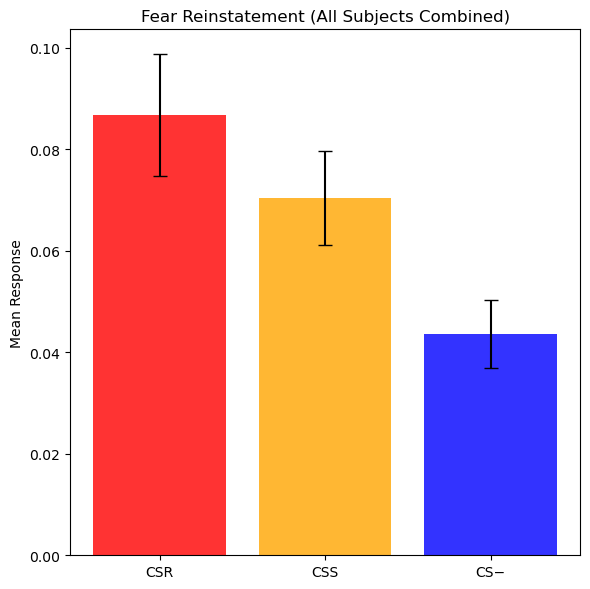

In [372]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Filter for drug_condition == 0
#merged_data = merged_data[merged_data['drug_condition'] == 0]

# Compute long format for CSR3, CSS3, CSminus3
long_data = pd.melt(
    merged_data,
    id_vars=['subID'],  # no patient_group now
    value_vars=['meanCSR3', 'meanCSS3', 'meanCSminus3'],
    var_name='stim_type',
    value_name='response'
)

# Map stim types to readable labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR3': 'CSR', 
    'meanCSS3': 'CSS', 
    'meanCSminus3': 'CS−'
})

# ---- Calculate mean and SEM per stim type ----
group_means = long_data.groupby('stim_type')['response'].mean()
group_sems  = long_data.groupby('stim_type')['response'].sem()

# ---- Paired t-tests between conditions ----
comparisons = [('CSR', 'CSS'), ('CSR', 'CS−'), ('CSS', 'CS−')]
for stim1, stim2 in comparisons:
    vals1 = long_data[long_data['stim_type'] == stim1]['response']
    vals2 = long_data[long_data['stim_type'] == stim2]['response']
    result = stats.ttest_rel(vals1, vals2)
    print(f"{stim1} vs {stim2}: t={result.statistic:.3f}, p={result.pvalue:.4f}")

# ---- Plot ----
plt.figure(figsize=(6, 6))
x_positions = [0, 1, 2]
colors = ['red', 'orange', 'blue']

plt.bar(x_positions, group_means.values, yerr=group_sems.values, color=colors, capsize=5, alpha=0.8)
plt.xticks(x_positions, ['CSR', 'CSS', 'CS−'])
plt.ylabel('Mean Response')
plt.title('Fear Reinstatement (All Subjects Combined)')
plt.savefig('csr_vs_css_vs_csminus_all_subjects_reinstatement.png', dpi=300)

# # ---- Add significance stars ----
# y_max = group_means.max() + group_sems.max() + 0.02
# for i, (stim1, stim2) in enumerate(comparisons):
#     vals1 = long_data[long_data['stim_type'] == stim1]['response']
#     vals2 = long_data[long_data['stim_type'] == stim2]['response']
#     result = stats.ttest_rel(vals1, vals2)
#     if result.pvalue < 0.05:
#         x1, x2 = x_positions[['CSR','CSS','CS−'].index(stim1)], x_positions[['CSR','CSS','CS−'].index(stim2)]
#         plt.plot([x1, x2], [y_max + i*0.02, y_max + i*0.02], 'k-', lw=1)
#         plt.text((x1 + x2)/2, y_max + i*0.02 + 0.005, '*', ha='center', fontsize=16)

plt.tight_layout()
plt.show()


In [174]:
#### just placebo condition! 

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Filter to include only individuals in the placebo condition (drug_order = 0)
merged_data = merged_data[merged_data['drug_condition'] == 0]

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group',  'gender'], 
                    value_vars=['meanCSR3', 'meanCSS3', 'meanCSminus3'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR3': 1, 
    'meanCSS3': 2, 
    'meanCSminus3': 3
})

# Specify the model without intercept
model_formula = 'response ~ patient_group * gender + stim_type'  # Removed 'drug' from model since all are placebo

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     3.954
Date:                Wed, 12 Nov 2025   Prob (F-statistic):            0.00447
Time:                        13:58:03   Log-Likelihood:                 145.47
No. Observations:                 150   AIC:                            -280.9
Df Residuals:                     145   BIC:                            -265.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0980 

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_37432/327783515.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_37432/864077555.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='patient_group', y='CSR_CSS', errorbar='se', palette=['red', 'blue'],alpha = 0.75)


Patient group CSR-CSS vs 0: t = 3.45, p = 0.002, df = 21.000
Control group CSR-CSS vs 0: t = 2.41, p = 0.023, df = 27.000
Between-group CSR-CSS comparison: t = -0.04, p = 0.970


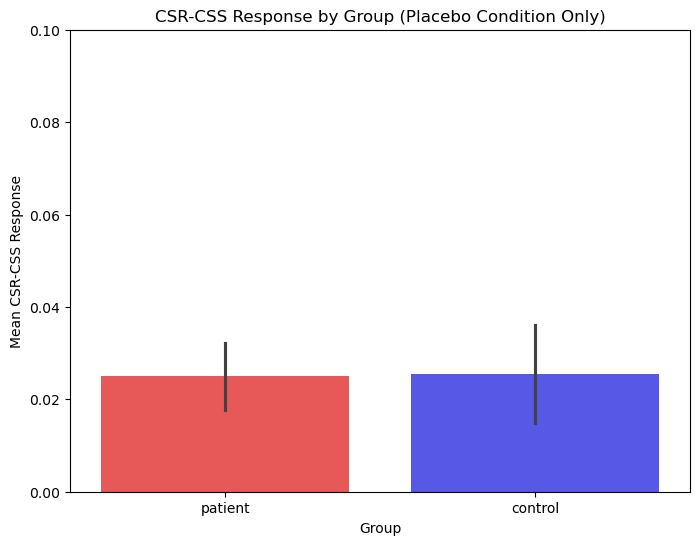

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Filter to include only individuals in the placebo condition (drug_order = 0)
merged_data = merged_data[merged_data['drug_condition'] == 0]

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Calculate CSR-CSS difference
merged_data['CSR_CSS'] = merged_data['meanCSS3'] - merged_data['meanCSminus3']

# Extract data for plotting
plot_data = merged_data[['subID', 'patient_group', 'CSR_CSS']]

# Plot the CSR-CSS response by group
plt.figure(figsize=(8, 6))
sns.barplot(data=plot_data, x='patient_group', y='CSR_CSS', errorbar='se', palette=['red', 'blue'],alpha = 0.75)

# Add labels
plt.xlabel('Group')
plt.ylabel('Mean CSR-CSS Response')
plt.ylim(top=0.1)
plt.title('CSR-CSS Response by Group (Placebo Condition Only)')

# Perform post-hoc t-tests
# Test if CSR-CSS is different from 0 within each group
patient_data = plot_data[plot_data['patient_group'] == 'patient']['CSR_CSS']
control_data = plot_data[plot_data['patient_group'] == 'control']['CSR_CSS']

# One-sample t-test within each group
patient_ttest = stats.ttest_1samp(patient_data, 0)
control_ttest = stats.ttest_1samp(control_data, 0)

print("Patient group CSR-CSS vs 0: t = {:.2f}, p = {:.3f}, df = {:.3f}".format(patient_ttest.statistic, patient_ttest.pvalue, patient_ttest.df))
print("Control group CSR-CSS vs 0: t = {:.2f}, p = {:.3f}, df = {:.3f}".format(control_ttest.statistic, control_ttest.pvalue, control_ttest.df))

# Independent t-test between groups
between_groups_ttest = stats.ttest_ind(patient_data, control_data, equal_var=False)
print("Between-group CSR-CSS comparison: t = {:.2f}, p = {:.3f}".format(between_groups_ttest.statistic, between_groups_ttest.pvalue))

# Display plot
filename = 'early_trials_phase3_SCR_patientsvcontrols_placeboonly.png'
plt.savefig(filename, format='png', dpi=300)
plt.show()


#### extinction (drug vs group graph)

In [243]:
import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx",'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID', 'drug_condition']], on='subID', how='left')

# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        'patients_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
        'patients_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
        'controls_drug' if row['subID'].startswith('N2') and row['drug_condition'] == 1 else
        'controls_placebo'
    ), axis=1
)

# Initialize dictionary to store means and SEs
all_stats = {}

# Calculate means and SEs for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Early stage statistics for CSS2
    mean = group_data['meanCSS2'].mean()
    se = group_data['meanCSS2'].sem()
    all_stats[f'CSS_{group}'] = (mean, se)
    

    # Early stage statistics for CSS2
    mean = group_data['meanCSR2'].mean()
    se = group_data['meanCSR2'].sem()
    all_stats[f'CSR_{group}'] = (mean, se)
    
    # Early stage statistics for CSS2
    mean = group_data['meanCSminus2'].mean()
    se = group_data['meanCSminus2'].sem()
    all_stats[f'CSminus_{group}'] = (mean, se)

    
import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx", 'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID', 'drug_condition']], on='subID', how='left')

# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        'patients_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
        'patients_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
        'controls_drug' if row['subID'].startswith('N2') and row['drug_condition'] == 1 else
        'controls_placebo'
    ), axis=1
)

# Initialize dictionary to store all data
all_data = {}

# Populate all_data with raw data for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Store early and late stage data for each stimulus type
    all_data[f'CSS_{group}'] = group_data['meanCSS2'].values
    all_data[f'CSR_{group}'] = group_data['meanCSR2'].values
    all_data[f'CSminus_{group}'] = group_data['meanCSminus2'].values


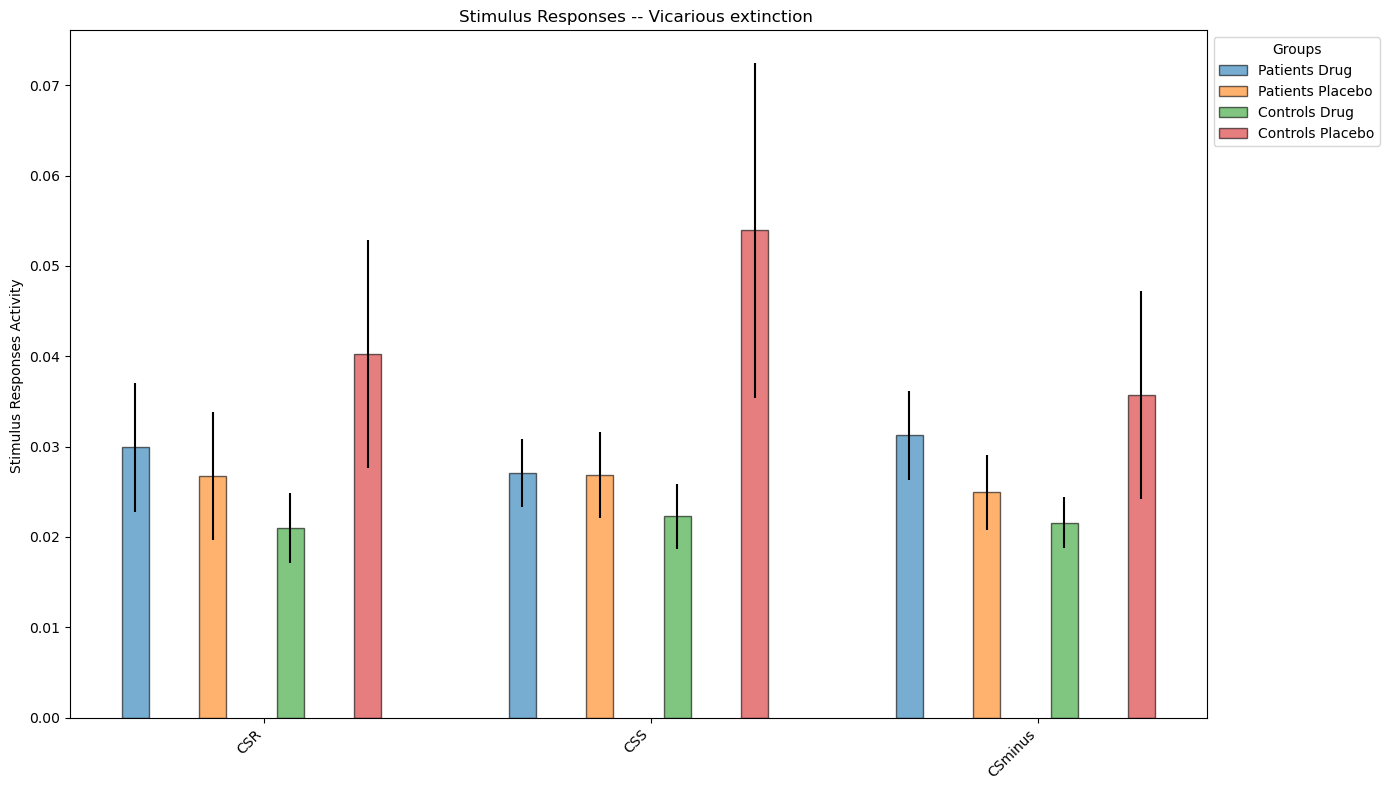

Statistical Test Results:


,Comparison,T-Stat,P-Value
0,Patients Drug vs Placebo (CSR),0.315254,0.753964
1,Control Drug vs Placebo (CSR),-1.363629,0.178793
2,Patients vs Controls Drug (CSR),1.064467,0.292335
3,Patients vs Controls Placebo (CSR),-0.865660,0.390983
4,Patients Drug vs Placebo (CSS),0.034401,0.972703
5,Control Drug vs Placebo (CSS),-1.556750,0.125838
6,Patients vs Controls Drug (CSS),0.914839,0.364757
7,Patients vs Controls Placebo (CSS),-1.264939,0.212000
8,Patients Drug vs Placebo (CSminus),0.954619,0.344655
9,Control Drug vs Placebo (CSminus),-1.105652,0.274169


In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            mean, se = all_stats[f'{stimulus}_{group}']
            data.append({
                'Stimulus': stimulus,
                'Group': group.replace('_', ' ').title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(data)

# Function to perform post-hoc t-tests using raw data in all_data
def calculate_posthoc_tests(all_data):
    results = []
    
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        patient_drug = all_data[f'{stimulus}_patients_drug']
        patient_placebo = all_data[f'{stimulus}_patients_placebo']
        control_drug = all_data[f'{stimulus}_controls_drug']
        control_placebo = all_data[f'{stimulus}_controls_placebo']

        for group_pair, (data1, data2) in {
            'Patients Drug vs Placebo': (patient_drug, patient_placebo),
            'Control Drug vs Placebo': (control_drug, control_placebo),
            'Patients vs Controls Drug': (patient_drug, control_drug),
            'Patients vs Controls Placebo': (patient_placebo, control_placebo)
        }.items():
            t_stat, p_value = ttest_ind(data1, data2) if len(data1) > 1 and len(data2) > 1 else (np.nan, np.nan)
            results.append({'Comparison': f'{group_pair} ({stimulus})', 'T-Stat': t_stat, 'P-Value': p_value})

    return pd.DataFrame(results)

# Function to plot a multibar plot with error bars and significant annotations
def plot_multibar_with_error_bars(all_stats, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)  # Use all_data for post-hoc tests
    
    plt.figure(figsize=(14, 8))
    stimuli = df['Stimulus'].unique()
    groups = df['Group'].unique()
    width = 0.35  # Width of each bar
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each group

    # Plotting for each stimulus category
    for i, stimulus in enumerate(stimuli):
        x_pos = np.arange(len(groups)) + i * (len(groups) + 1)  # Set x position for each stimulus group
        
        for j, group in enumerate(groups):
            group_data_early = df[(df['Stimulus'] == stimulus) & (df['Group'] == group)]
            
            # Plot bars with error bars
            plt.bar(x_pos[j] - width/2, group_data_early['Mean'].values[0], yerr=group_data_early['SE'].values[0],
                    width=width, color=colors[j], alpha=0.6, edgecolor='black', label=f'{group}' if i == 0 else "")

            # # Annotate significant differences
            # comparison_early_late = f'{group.replace(" ", "_").lower()}_early_vs_late_{stimulus.lower()}'
            # if not stats_df[stats_df['Comparison'] == comparison_early_late].empty:
            #     p_value = stats_df[stats_df['Comparison'] == comparison_early_late]['P-Value'].values[0]
            #     if p_value < 0.05:
            #         y = max(group_data_early['Mean'].values[0] + group_data_early['SE'].values[0],
            #                 group_data_late['Mean'].values[0] + group_data_late['SE'].values[0]) + 0.1
            #         plt.plot([x_pos[j] - width/2, x_pos[j] + width/2], [y, y], color='black')
            #         plt.text(x_pos[j], y + 0.05, '*', ha='center', va='bottom', color='black')

    # Customize the plot
    tick_pos = [x + width * 4.25 for x in range(0, len(stimuli) * (len(groups) + 1), len(groups) + 1)]
    plt.xticks(tick_pos, stimuli, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity ')
    plt.title(f'{title} -- Vicarious extinction ')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups')
    plt.tight_layout()
    plt.show()

    # Display statistical table below the plot
    print("Statistical Test Results:")
    display(stats_df)

# Plot combined multibar plot for all stimulus categories
title = 'Stimulus Responses'
plot_multibar_with_error_bars(all_stats, title)


In [245]:
from scipy.stats import ttest_ind, ttest_1samp

# ✅ Function to prepare data for multibar plot
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for contrast in ['CSR-CSS','CSR-CSminus','CSS-CSminus']:
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            mean, se = all_stats[f'{contrast}_{group}']
            data.append({
                'Contrast': contrast,
                'Group': group.replace('_', ' ').title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(data)


# ✅ Function to perform post-hoc tests
def calculate_posthoc_tests(all_data):
    results = []
    
    for contrast in ['CSR-CSS','CSR-CSminus','CSS-CSminus']:
        patient_drug = all_data[f'{contrast}_patients_drug']
        patient_placebo = all_data[f'{contrast}_patients_placebo']
        control_drug = all_data[f'{contrast}_controls_drug']
        control_placebo = all_data[f'{contrast}_controls_placebo']

        # --- 1) Within-group tests vs 0
        for group_name, data in {
            'Patients Drug': patient_drug,
            'Patients Placebo': patient_placebo,
            'Controls Drug': control_drug,
            'Controls Placebo': control_placebo
        }.items():
            if len(data) > 1:
                t_stat, p_value = ttest_1samp(data, 0)
            else:
                t_stat, p_value = (np.nan, np.nan)
            results.append({'Comparison': f'{group_name} vs 0 ({contrast})',
                            'T-Stat': t_stat, 'P-Value': p_value})

        # --- 2) Between-group comparisons
        for group_pair, (data1, data2) in {
            'Patients Drug vs Placebo': (patient_drug, patient_placebo),
            'Controls Drug vs Placebo': (control_drug, control_placebo),
            'Patients vs Controls Drug': (patient_drug, control_drug),
            'Patients vs Controls Placebo': (patient_placebo, control_placebo)
        }.items():
            if len(data1) > 1 and len(data2) > 1:
                t_stat, p_value = ttest_ind(data1, data2)
            else:
                t_stat, p_value = (np.nan, np.nan)
            results.append({'Comparison': f'{group_pair} ({contrast})',
                            'T-Stat': t_stat, 'P-Value': p_value})

    return pd.DataFrame(results)


# ✅ Plot function
def plot_multibar_with_error_bars(all_stats, all_data, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)
    
    plt.figure(figsize=(12, 7))
    contrasts = df['Contrast'].unique()
    groups = df['Group'].unique()
    width = 0.9
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    # Plot each contrast
    for i, contrast in enumerate(contrasts):
        x_pos = np.arange(len(groups)) + i * (len(groups) + 1)
        
        for j, group in enumerate(groups):
            group_data = df[(df['Contrast'] == contrast) & (df['Group'] == group)]
            
            plt.bar(x_pos[j], group_data['Mean'].values[0],
                    yerr=group_data['SE'].values[0],
                    width=width, color=colors[j], alpha=0.7,
                    edgecolor='black', label=f'{group}' if i == 0 else "")

    # Customize plot
    tick_pos = [x + width for x in range(0, len(contrasts) * (len(groups) + 1), len(groups) + 1)]
    plt.xticks(tick_pos, contrasts, rotation=45, ha='right')
    plt.ylabel(f'{title} Difference Score (vs CSminus)')
    plt.title(f'{title} -- CSR & CSS contrasts with CSminus')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups')
    plt.tight_layout()
    plt.show()

    print("Statistical Test Results:")
    display(stats_df)



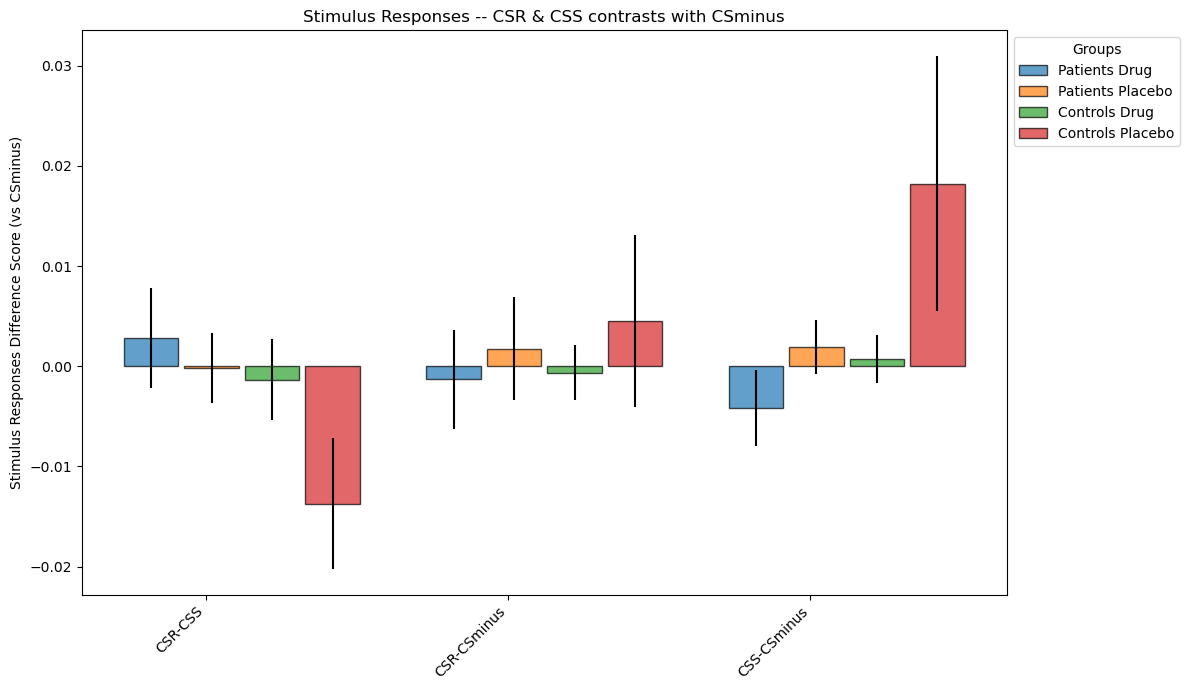

Statistical Test Results:


,Comparison,T-Stat,P-Value
0,Patients Drug vs 0 (CSR-CSS),0.569620,0.573824
1,Patients Placebo vs 0 (CSR-CSS),-0.045901,0.963823
2,Controls Drug vs 0 (CSR-CSS),-0.330082,0.744326
3,Controls Placebo vs 0 (CSR-CSS),-2.103422,0.044884
4,Patients Drug vs Placebo (CSR-CSS),0.472109,0.639033
5,Controls Drug vs Placebo (CSR-CSS),1.555180,0.126211
6,Patients vs Controls Drug (CSR-CSS),0.640306,0.524956
7,Patients vs Controls Placebo (CSR-CSS),1.697803,0.096020
8,Patients Drug vs 0 (CSR-CSminus),-0.266741,0.791773
9,Patients Placebo vs 0 (CSR-CSminus),0.345275,0.733322


In [246]:
# ✅ Build contrast data from raw all_data and all_stats
def build_contrast_data(all_data):
    contrast_all_data = {}
    contrast_all_stats = {}

    # Define contrasts
    contrasts = {
        "CSR-CSS": ("CSR", "CSS"),
        "CSR-CSminus": ("CSR", "CSminus"),
       "CSS-CSminus": ("CSS", "CSminus")
    }

    for contrast_name, (stim1, stim2) in contrasts.items():
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            # Compute raw difference scores for each subject
            data1 = np.array(all_data[f"{stim1}_{group}"])
            data2 = np.array(all_data[f"{stim2}_{group}"])
            diff_scores = data1 - data2

            # Store in contrast_all_data
            contrast_all_data[f"{contrast_name}_{group}"] = diff_scores

            # Compute mean and SE
            mean = np.nanmean(diff_scores)
            se = np.nanstd(diff_scores, ddof=1) / np.sqrt(len(diff_scores))
            contrast_all_stats[f"{contrast_name}_{group}"] = (mean, se)

    return contrast_all_data, contrast_all_stats


# ✅ Example usage before plotting
contrast_all_data, contrast_all_stats = build_contrast_data(all_data)

# Now run plotting function with contrast data
title = 'Stimulus Responses'
plot_multibar_with_error_bars(contrast_all_stats, contrast_all_data, title)


#### Reinstatement (drug vs group graph)

In [247]:
import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx",'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID', 'drug_condition']], on='subID', how='left')

# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        'patients_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
        'patients_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
        'controls_drug' if row['subID'].startswith('N2') and row['drug_condition'] == 1 else
        'controls_placebo'
    ), axis=1
)

# Initialize dictionary to store means and SEs
all_stats = {}

# Calculate means and SEs for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Early stage statistics for CSS2
    mean = group_data['meanCSS3'].mean()
    se = group_data['meanCSS3'].sem()
    all_stats[f'CSS_{group}'] = (mean, se)
    

    # Early stage statistics for CSS2
    mean = group_data['meanCSR3'].mean()
    se = group_data['meanCSR3'].sem()
    all_stats[f'CSR_{group}'] = (mean, se)
    
    # Early stage statistics for CSS2
    mean = group_data['meanCSminus3'].mean()
    se = group_data['meanCSminus3'].sem()
    all_stats[f'CSminus_{group}'] = (mean, se)

    
import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx", 'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID', 'drug_condition']], on='subID', how='left')

# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        'patients_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
        'patients_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
        'controls_drug' if row['subID'].startswith('N2') and row['drug_condition'] == 1 else
        'controls_placebo'
    ), axis=1
)

# Initialize dictionary to store all data
all_data = {}

# Populate all_data with raw data for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Store early and late stage data for each stimulus type
    all_data[f'CSS_{group}'] = group_data['meanCSS3'].values
    all_data[f'CSR_{group}'] = group_data['meanCSR3'].values
    all_data[f'CSminus_{group}'] = group_data['meanCSminus3'].values


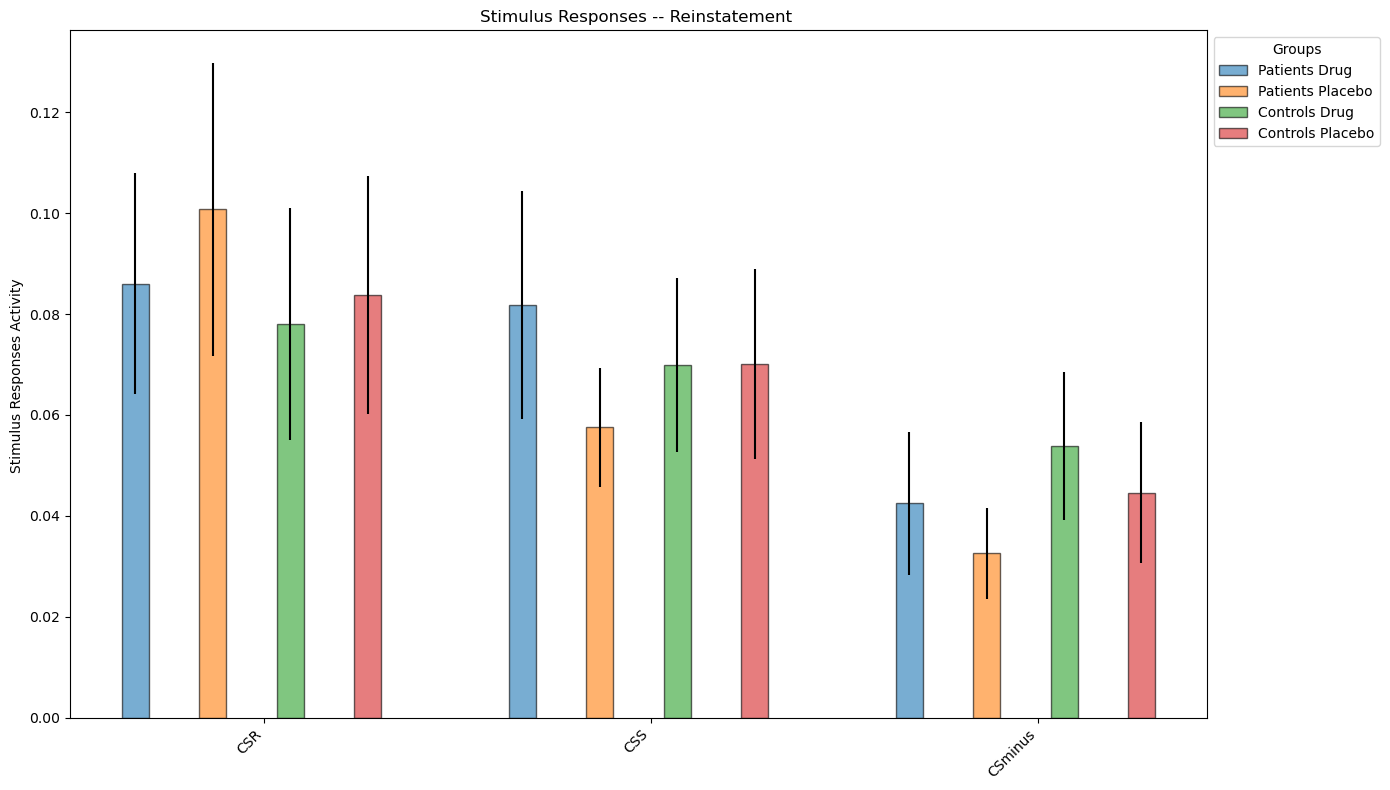

Statistical Test Results:


,Comparison,T-Stat,P-Value,df
0,patients_placebo (CSR-CSS),2.149456,0.043408,NaN
1,patients_drug (CSR-CSS),0.371583,0.713215,NaN
2,controls_placebo (CSR-CSS),1.682054,0.104090,NaN
3,controls_drug (CSR-CSS),0.631972,0.533637,NaN
4,Patients Drug vs Placebo (CSR),-0.412869,0.681580,47.0
5,Control Drug vs Placebo (CSR),-0.175390,0.861482,50.0
6,Patients vs Controls Drug (CSR),0.252599,0.801635,49.0
7,Patients vs Controls Placebo (CSR),0.456768,0.649899,48.0
8,Patients Drug vs Placebo (CSS),0.893836,0.375964,47.0
9,Control Drug vs Placebo (CSS),-0.009894,0.992145,50.0


In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_rel, ttest_ind

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            mean, se = all_stats[f'{stimulus}_{group}']
            data.append({
                'Stimulus': stimulus,
                'Group': group.replace('_', ' ').title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(data)

# Function to perform post-hoc t-tests using raw data in all_data
def calculate_posthoc_tests(all_data):
    results = []
    for group in ['patients_placebo','patients_drug', 'controls_placebo','controls_drug']:
        csr_css = all_data[f'CSR_{group}']-all_data[f'CSS_{group}']
        t_stat, p_value = stats.ttest_1samp(a=csr_css,popmean=0)
        results.append({'Comparison': f'{group} (CSR-CSS)', 'T-Stat': t_stat, 'P-Value': p_value})

    for stimulus in ['CSR', 'CSS', 'CSminus']:
        patient_drug = all_data[f'{stimulus}_patients_drug']
        patient_placebo = all_data[f'{stimulus}_patients_placebo']
        control_drug = all_data[f'{stimulus}_controls_drug']
        control_placebo = all_data[f'{stimulus}_controls_placebo']

        for group_pair, (data1, data2) in {
            'Patients Drug vs Placebo': (patient_drug, patient_placebo),
            'Control Drug vs Placebo': (control_drug, control_placebo),
            'Patients vs Controls Drug': (patient_drug, control_drug),
            'Patients vs Controls Placebo': (patient_placebo, control_placebo)
        }.items():
            stats1 = ttest_ind(data1, data2) if len(data1) > 1 and len(data2) > 1 else (np.nan, np.nan)
            results.append({'Comparison': f'{group_pair} ({stimulus})','T-Stat': stats1.statistic, 'P-Value': stats1.pvalue,'df': stats1.df})
    
    patients_placebo_csr_css = csr_css = all_data[f'CSR_patients_placebo']-all_data[f'CSS_patients_placebo']
    patients_drug_csr_css = csr_css = all_data[f'CSR_patients_drug']-all_data[f'CSS_patients_drug']
    stats1 = stats.ttest_ind(patients_placebo_csr_css,patients_drug_csr_css)
    results.append({'Comparison': f'patients drug vs placebo (CSR-CSS)','T-Stat': stats1.statistic, 'P-Value': stats1.pvalue,'df': stats1.df})

    controls_placebo_csr_css = csr_css = all_data[f'CSR_controls_placebo']-all_data[f'CSS_controls_placebo']
    controls_drug_csr_css = csr_css = all_data[f'CSR_controls_drug']-all_data[f'CSS_controls_drug']
    stats1 = stats.ttest_ind(controls_placebo_csr_css,controls_drug_csr_css)
    results.append({'Comparison': f'controls drug vs placebo (CSR-CSS)','T-Stat': stats1.statistic, 'P-Value': stats1.pvalue,'df': stats1.df})
    
    patients_placebo_csr_css = csr_css = all_data[f'CSR_patients_placebo']-all_data[f'CSS_patients_placebo']
    controls_placebo_csr_css = csr_css = all_data[f'CSR_controls_placebo']-all_data[f'CSS_controls_placebo']
    stats1 = stats.ttest_ind(patients_placebo_csr_css,controls_placebo_csr_css)
    results.append({'Comparison': f'placebo controls vs patients (CSR-CSS)','T-Stat': stats1.statistic, 'P-Value': stats1.pvalue,'df': stats1.df})

    patients_drug_csr_css = csr_css = all_data[f'CSR_patients_drug']-all_data[f'CSS_patients_drug']
    controls_drug_csr_css = csr_css = all_data[f'CSR_controls_drug']-all_data[f'CSS_controls_drug']
    stats1 = stats.ttest_ind(patients_drug_csr_css,controls_drug_csr_css)
    results.append({'Comparison': f'drug controls vs patients (CSR-CSS)','T-Stat': stats1.statistic, 'P-Value': stats1.pvalue,'df': stats1.df})

    return pd.DataFrame(results)

# Function to plot a multibar plot with error bars and significant annotations
def plot_multibar_with_error_bars(all_stats, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)  # Use all_data for post-hoc tests
    
    plt.figure(figsize=(14, 8))
    stimuli = df['Stimulus'].unique()
    groups = df['Group'].unique()
    width = 0.35  # Width of each bar
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each group

    # Plotting for each stimulus category
    for i, stimulus in enumerate(stimuli):
        x_pos = np.arange(len(groups)) + i * (len(groups) + 1)  # Set x position for each stimulus group
        
        for j, group in enumerate(groups):
            group_data_early = df[(df['Stimulus'] == stimulus) & (df['Group'] == group)]
            
            # Plot bars with error bars
            plt.bar(x_pos[j] - width/2, group_data_early['Mean'].values[0], yerr=group_data_early['SE'].values[0],
                    width=width, color=colors[j], alpha=0.6, edgecolor='black', label=f'{group}' if i == 0 else "")

            # # Annotate significant differences
            # comparison_early_late = f'{group.replace(" ", "_").lower()}_early_vs_late_{stimulus.lower()}'
            # if not stats_df[stats_df['Comparison'] == comparison_early_late].empty:
            #     p_value = stats_df[stats_df['Comparison'] == comparison_early_late]['P-Value'].values[0]
            #     if p_value < 0.05:
            #         y = max(group_data_early['Mean'].values[0] + group_data_early['SE'].values[0],
            #                 group_data_late['Mean'].values[0] + group_data_late['SE'].values[0]) + 0.1
            #         plt.plot([x_pos[j] - width/2, x_pos[j] + width/2], [y, y], color='black')
            #         plt.text(x_pos[j], y + 0.05, '*', ha='center', va='bottom', color='black')

    # Customize the plot
    tick_pos = [x + width * 4.25 for x in range(0, len(stimuli) * (len(groups) + 1), len(groups) + 1)]
    plt.xticks(tick_pos, stimuli, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity ')
    plt.title(f'{title} -- Reinstatement ')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups')
    plt.tight_layout()
    plt.show()

    # Display statistical table below the plot
    print("Statistical Test Results:")
    display(stats_df)

# Plot combined multibar plot for all stimulus categories
title = 'Stimulus Responses'
plot_multibar_with_error_bars(all_stats, title)


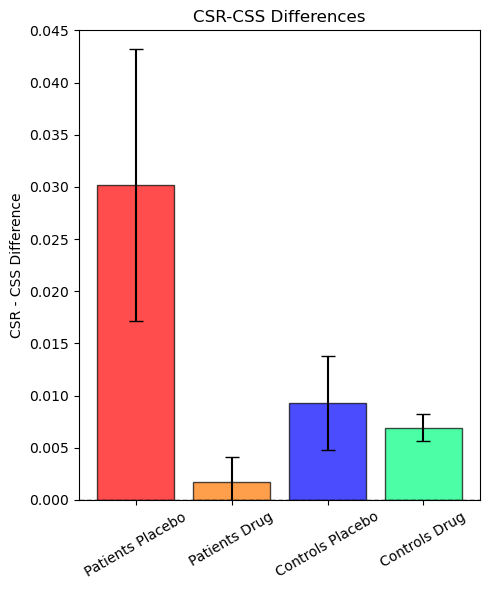

Statistical Test Results:


,Comparison,T-Stat,P-Value
0,patients_placebo vs 0,2.149456,0.043408
1,patients_drug vs 0,0.371583,0.713215
2,controls_placebo vs 0,1.682054,0.104090
3,controls_drug vs 0,0.631972,0.533637
4,patients_placebo vs patients_drug,1.778481,0.081794
5,controls_placebo vs controls_drug,0.373907,0.710055
6,patients_placebo vs controls_placebo,1.470409,0.147976
7,patients_drug vs controls_drug,-0.236534,0.814004


In [191]:
# CSR-CSS graph 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, ttest_ind

# ✅ Prepare data for CSR-CSS difference plot
def prepare_csr_css_data(all_data):
    data = []
    for group in ['patients_placebo', 'patients_drug', 'controls_placebo', 'controls_drug']:
        csr = np.array(all_data[f'CSR_{group}'])
        css = np.array(all_data[f'CSS_{group}'])
        diff = csr - css
        mean = np.mean(diff)
        se = np.std(diff, ddof=1) / np.sqrt(len(diff))
        data.append({
            'Group': group.replace('_', ' ').title(),
            'Mean': mean,
            'SE': se
        })
    return pd.DataFrame(data)

# ✅ Perform t-tests on raw CSR-CSS data
def calculate_csr_css_tests(all_data):
    results = []
    # One-sample t-test for each group against 0
    for group in ['patients_placebo','patients_drug','controls_placebo','controls_drug']:
        csr_css = all_data[f'CSR_{group}'] - all_data[f'CSS_{group}']
        t_stat, p_value = ttest_1samp(csr_css, popmean=0)
        results.append({'Comparison': f'{group} vs 0', 'T-Stat': t_stat, 'P-Value': p_value})

    # Between-group comparisons
    group_pairs = [
        ('patients_placebo', 'patients_drug'),
        ('controls_placebo', 'controls_drug'),
        ('patients_placebo', 'controls_placebo'),
        ('patients_drug', 'controls_drug')
    ]
    for g1, g2 in group_pairs:
        diff1 = all_data[f'CSR_{g1}'] - all_data[f'CSS_{g1}']
        diff2 = all_data[f'CSR_{g2}'] - all_data[f'CSS_{g2}']
        t_stat, p_value = ttest_ind(diff1, diff2)
        results.append({'Comparison': f'{g1} vs {g2}', 'T-Stat': t_stat, 'P-Value': p_value})

    return pd.DataFrame(results)

# ✅ Plot grouped bar chart for CSR-CSS
def plot_csr_css(all_stats, all_data, title='CSR-CSS Differences'):
    df = prepare_csr_css_data(all_stats)
    stats_df = calculate_csr_css_tests(all_data)

    plt.figure(figsize=(5, 6))
    colors = ["red", "#ff7700", "blue", "#00ff80"]
    x = np.arange(len(df['Group']))
    width = 0.6

    plt.bar(x, df['Mean'], yerr=df['SE'], color=colors, alpha=0.7, capsize=5, edgecolor='black')
    plt.xticks(x, df['Group'], rotation=30)
    plt.ylabel('CSR - CSS Difference')
    plt.ylim(0, 0.045)
    plt.title(title)
    plt.axhline(0, color='black', linewidth=1, linestyle='--')
    plt.tight_layout()
    plt.savefig('csr-css_phase3.png', format='png', dpi=300)
    plt.show()

    print("Statistical Test Results:")
    display(stats_df)

# ✅ Example usage:
# all_stats should include keys like 'CSR-CSS_patients_placebo' with (mean, SE)
# all_data should include raw arrays for 'CSR_patients_placebo' and 'CSS_patients_placebo'

plot_csr_css(all_stats, all_data)


In [181]:
drug_order

,subID,Drug,drug_condition,Gender,gender_code
0,N101,Placebo,0,Female,0
1,N102,Oxytocin,1,Male,1
2,N103,Oxytocin,1,Female,0
3,N104,Oxytocin,1,Male,1
4,N105,Oxytocin,1,Female,0
...,...,...,...,...,...
99,N255,Oxytocin,1,Female,0
100,N257,Placebo,0,Female,0
101,N258,Placebo,0,Female,0
102,N259,Oxytocin,1,Female,0


In [249]:
import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx",'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID', 'drug_condition', 'gender_code']], on='subID', how='left')

# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        'women_drug' if row['gender_code'] == 0 and row['drug_condition'] == 1 else
        'women_placebo' if row['gender_code'] == 0 and row['drug_condition'] == 0 else
        'men_drug' if row['gender_code'] == 1 and row['drug_condition'] == 1 else
        'men_placebo'
    ), axis=1
)

# Initialize dictionary to store means and SEs
all_stats = {}

# Calculate means and SEs for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Early stage statistics for CSS2
    mean = group_data['meanCSS3'].mean()
    se = group_data['meanCSS3'].sem()
    all_stats[f'CSS_{group}'] = (mean, se)
    

    # Early stage statistics for CSS2
    mean = group_data['meanCSR3'].mean()
    se = group_data['meanCSR3'].sem()
    all_stats[f'CSR_{group}'] = (mean, se)
    
    # Early stage statistics for CSS2
    mean = group_data['meanCSminus3'].mean()
    se = group_data['meanCSminus3'].sem()
    all_stats[f'CSminus_{group}'] = (mean, se)

    


# Initialize dictionary to store all data
all_data = {}

# Populate all_data with raw data for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Store early and late stage data for each stimulus type
    all_data[f'CSS_{group}'] = group_data['meanCSS3'].values
    all_data[f'CSR_{group}'] = group_data['meanCSR3'].values
    all_data[f'CSminus_{group}'] = group_data['meanCSminus3'].values


In [251]:
all_data

{'CSS_women_placebo': array([0.02  , 0.0418, 0.0428, 0.0176, 0.0906, 0.0332, 0.0404, 0.1074,
        0.042 , 0.02  , 0.0916, 0.0056, 0.0482, 0.    , 0.0142, 0.0252,
        0.0598, 0.0134, 0.0308, 0.0134, 0.0798, 0.0196, 0.0524, 0.3018,
        0.021 , 0.0312, 0.0512]),
 'CSR_women_placebo': array([0.023  , 0.1165 , 0.08725, 0.02675, 0.1675 , 0.00575, 0.044  ,
        0.027  , 0.06175, 0.02325, 0.09925, 0.02275, 0.122  , 0.     ,
        0.0055 , 0.02375, 0.10525, 0.07275, 0.0325 , 0.01775, 0.13675,
        0.043  , 0.05625, 0.2705 , 0.0265 , 0.03425, 0.0415 ]),
 'CSminus_women_placebo': array([0.011 , 0.    , 0.025 , 0.01  , 0.0475, 0.0105, 0.037 , 0.    ,
        0.0455, 0.0115, 0.0565, 0.    , 0.0435, 0.    , 0.    , 0.0215,
        0.026 , 0.0385, 0.0275, 0.0115, 0.0115, 0.0115, 0.0125, 0.053 ,
        0.0475, 0.0365, 0.054 ]),
 'CSS_women_drug': array([0.32  , 0.0292, 0.028 , 0.0698, 0.024 , 0.0292, 0.0682, 0.2022,
        0.0112, 0.0392, 0.0334, 0.0298, 0.0108, 0.0176, 0.0238, 0.

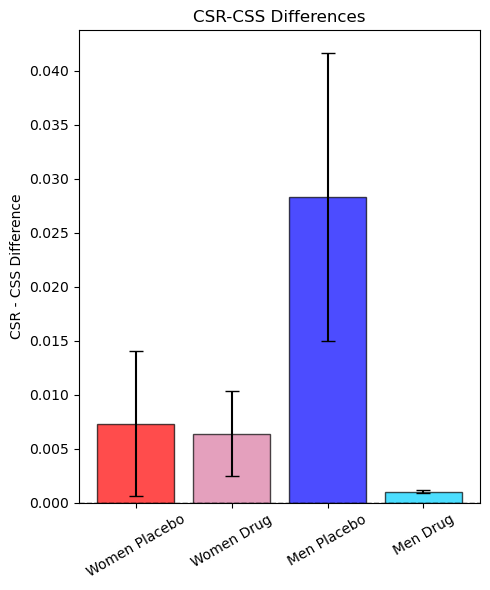

Statistical Test Results:


,Comparison,T-Stat,P-Value
0,women_placebo vs 0,2.063698,0.049161
1,women_drug vs 0,0.956851,0.347132
2,men_placebo vs 0,2.063288,0.051082
3,men_drug vs 0,0.066616,0.947489
4,women_placebo vs women_drug,0.288927,0.773764
5,men_placebo vs men_drug,1.677778,0.100481
6,women_placebo vs men_placebo,-1.382644,0.173173
7,women_drug vs men_drug,0.551008,0.584132


In [250]:
# CSR-CSS graph 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, ttest_ind

# ✅ Prepare data for CSR-CSS difference plot
def prepare_csr_css_data(all_data):
    data = []
    for group in ['women_placebo', 'women_drug', 'men_placebo', 'men_drug']:
        csr = np.array(all_data[f'CSR_{group}'])
        css = np.array(all_data[f'CSS_{group}'])
        diff = csr - css
        mean = np.mean(diff)
        se = np.std(diff, ddof=1) / np.sqrt(len(diff))
        data.append({
            'Group': group.replace('_', ' ').title(),
            'Mean': mean,
            'SE': se
        })
    return pd.DataFrame(data)

# ✅ Perform t-tests on raw CSR-CSS data
def calculate_csr_css_tests(all_data):
    results = []
    # One-sample t-test for each group against 0
    for group in ['women_placebo','women_drug','men_placebo','men_drug']:
        csr_css = all_data[f'CSR_{group}'] - all_data[f'CSS_{group}']
        t_stat, p_value = ttest_1samp(csr_css, popmean=0)
        results.append({'Comparison': f'{group} vs 0', 'T-Stat': t_stat, 'P-Value': p_value})

    # Between-group comparisons
    group_pairs = [
        ('women_placebo', 'women_drug'),
        ('men_placebo', 'men_drug'),
        ('women_placebo', 'men_placebo'),
        ('women_drug', 'men_drug')
    ]
    for g1, g2 in group_pairs:
        diff1 = all_data[f'CSR_{g1}'] - all_data[f'CSS_{g1}']
        diff2 = all_data[f'CSR_{g2}'] - all_data[f'CSS_{g2}']
        t_stat, p_value = ttest_ind(diff1, diff2)
        results.append({'Comparison': f'{g1} vs {g2}', 'T-Stat': t_stat, 'P-Value': p_value})

    return pd.DataFrame(results)

# ✅ Plot grouped bar chart for CSR-CSS
def plot_csr_css(all_stats, all_data, title='CSR-CSS Differences'):
    df = prepare_csr_css_data(all_stats)
    stats_df = calculate_csr_css_tests(all_data)

    plt.figure(figsize=(5, 6))
    colors = ["red", "#d978a2", "blue", "#00d0ff"]
    x = np.arange(len(df['Group']))
    width = 0.6

    plt.bar(x, df['Mean'], yerr=df['SE'], color=colors, alpha=0.7, capsize=5, edgecolor='black')
    plt.xticks(x, df['Group'], rotation=30)
    plt.ylabel('CSR - CSS Difference')
    plt.title(title)
    plt.axhline(0, color='black', linewidth=1, linestyle='--')
    plt.tight_layout()
    plt.savefig('csr-css_phase3.png', format='png', dpi=300)
    plt.show()

    print("Statistical Test Results:")
    display(stats_df)

# ✅ Example usage:
# all_stats should include keys like 'CSR-CSS_patients_placebo' with (mean, SE)
# all_data should include raw arrays for 'CSR_patients_placebo' and 'CSS_patients_placebo'

plot_csr_css(all_stats, all_data)


In [118]:
from scipy.stats import ttest_ind, ttest_1samp

# ✅ Function to prepare data for multibar plot
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for contrast in ['CSR-CSS','CSR-CSminus','CSS-CSminus']:
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            mean, se = all_stats[f'{contrast}_{group}']
            data.append({
                'Contrast': contrast,
                'Group': group.replace('_', ' ').title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(data)


# ✅ Function to perform post-hoc tests
def calculate_posthoc_tests(all_data):
    results = []
    
    for contrast in ['CSR-CSS','CSR-CSminus','CSS-CSminus']:
        patient_drug = all_data[f'{contrast}_patients_drug']
        patient_placebo = all_data[f'{contrast}_patients_placebo']
        control_drug = all_data[f'{contrast}_controls_drug']
        control_placebo = all_data[f'{contrast}_controls_placebo']

        # --- 1) Within-group tests vs 0
        for group_name, data in {
            'Patients Drug': patient_drug,
            'Patients Placebo': patient_placebo,
            'Controls Drug': control_drug,
            'Controls Placebo': control_placebo
        }.items():
            if len(data) > 1:
                t_stat, p_value = ttest_1samp(data, 0)
            else:
                t_stat, p_value = (np.nan, np.nan)
            results.append({'Comparison': f'{group_name} vs 0 ({contrast})',
                            'T-Stat': t_stat, 'P-Value': p_value})

        # --- 2) Between-group comparisons
        for group_pair, (data1, data2) in {
            'Patients Drug vs Placebo': (patient_drug, patient_placebo),
            'Controls Drug vs Placebo': (control_drug, control_placebo),
            'Patients vs Controls Drug': (patient_drug, control_drug),
            'Patients vs Controls Placebo': (patient_placebo, control_placebo)
        }.items():
            if len(data1) > 1 and len(data2) > 1:
                t_stat, p_value = ttest_ind(data1, data2)
            else:
                t_stat, p_value = (np.nan, np.nan)
            results.append({'Comparison': f'{group_pair} ({contrast})',
                            'T-Stat': t_stat, 'P-Value': p_value})

    return pd.DataFrame(results)


# ✅ Plot function
def plot_multibar_with_error_bars(all_stats, all_data, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)
    
    plt.figure(figsize=(12, 7))
    contrasts = df['Contrast'].unique()
    groups = df['Group'].unique()
    width = 0.9
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    # Plot each contrast
    for i, contrast in enumerate(contrasts):
        x_pos = np.arange(len(groups)) + i * (len(groups) + 1)
        
        for j, group in enumerate(groups):
            group_data = df[(df['Contrast'] == contrast) & (df['Group'] == group)]
            
            plt.bar(x_pos[j], group_data['Mean'].values[0],
                    yerr=group_data['SE'].values[0],
                    width=width, color=colors[j], alpha=0.7,
                    edgecolor='black', label=f'{group}' if i == 0 else "")

    # Customize plot
    tick_pos = [x + width for x in range(0, len(contrasts) * (len(groups) + 1), len(groups) + 1)]
    plt.xticks(tick_pos, contrasts, rotation=45, ha='right')
    plt.ylabel(f'{title} Difference Score (vs CSminus)')
    plt.title(f'{title} -- CSR & CSS contrasts with CSminus')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups')
    plt.tight_layout()
    plt.show()

    print("Statistical Test Results:")
    display(stats_df)



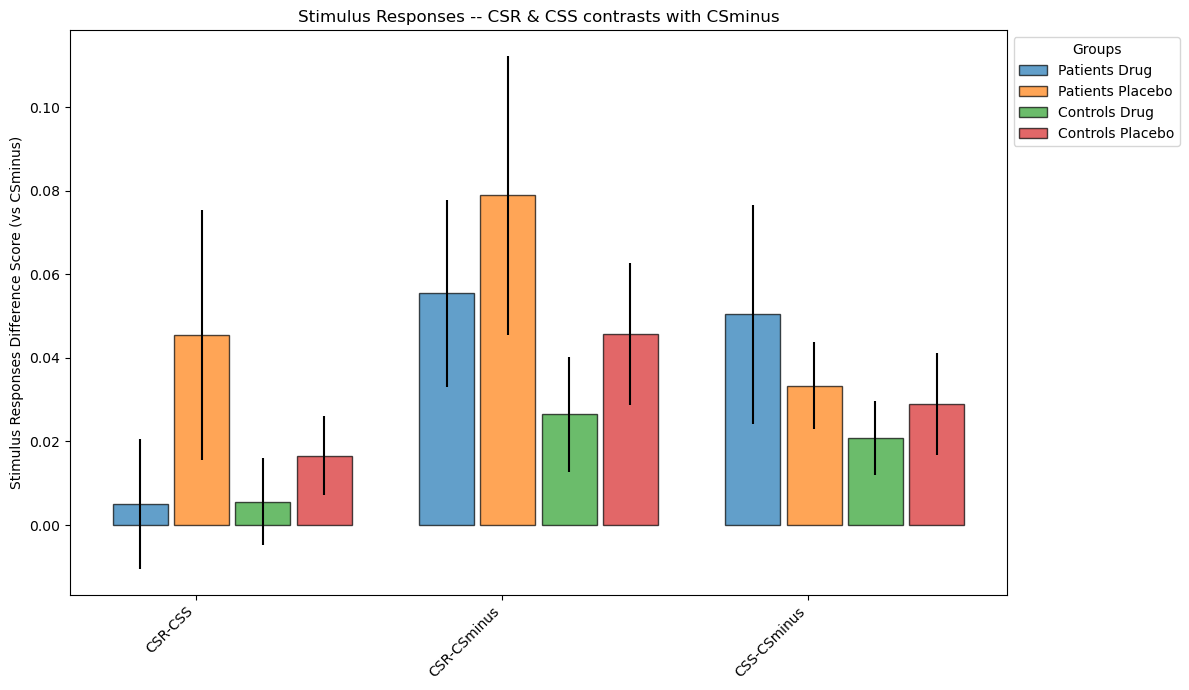

Statistical Test Results:


,Comparison,T-Stat,P-Value
0,Patients Drug vs 0 (CSR-CSS),0.322915,0.750481
1,Patients Placebo vs 0 (CSR-CSS),1.517137,0.153168
2,Controls Drug vs 0 (CSR-CSS),0.536459,0.598210
3,Controls Placebo vs 0 (CSR-CSS),1.752429,0.093023
4,Patients Drug vs Placebo (CSR-CSS),-1.291570,0.206054
5,Controls Drug vs Placebo (CSR-CSS),-0.774586,0.443029
6,Patients vs Controls Drug (CSR-CSS),-0.032827,0.973994
7,Patients vs Controls Placebo (CSR-CSS),1.119288,0.270430
8,Patients Drug vs 0 (CSR-CSminus),2.482351,0.023141
9,Patients Placebo vs 0 (CSR-CSminus),2.362729,0.034400


In [119]:
# ✅ Build contrast data from raw all_data and all_stats
def build_contrast_data(all_data):
    contrast_all_data = {}
    contrast_all_stats = {}

    # Define contrasts
    contrasts = {
        "CSR-CSS": ("CSR", "CSS"),
        "CSR-CSminus": ("CSR", "CSminus"),
       "CSS-CSminus": ("CSS", "CSminus")
    }

    for contrast_name, (stim1, stim2) in contrasts.items():
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            # Compute raw difference scores for each subject
            data1 = np.array(all_data[f"{stim1}_{group}"])
            data2 = np.array(all_data[f"{stim2}_{group}"])
            diff_scores = data1 - data2

            # Store in contrast_all_data
            contrast_all_data[f"{contrast_name}_{group}"] = diff_scores

            # Compute mean and SE
            mean = np.nanmean(diff_scores)
            se = np.nanstd(diff_scores, ddof=1) / np.sqrt(len(diff_scores))
            contrast_all_stats[f"{contrast_name}_{group}"] = (mean, se)

    return contrast_all_data, contrast_all_stats


# ✅ Example usage before plotting
contrast_all_data, contrast_all_stats = build_contrast_data(all_data)

# Now run plotting function with contrast data
title = 'Stimulus Responses'
plot_multibar_with_error_bars(contrast_all_stats, contrast_all_data, title)


#### reinstatement: gender post-hoc

In [123]:
import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx",'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID','drug_condition', 'gender_code']], on='subID', how='left')

# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        'female_drug' if row['gender_code'] == 0 and row['drug_condition'] == 1 else
        'female_placebo' if row['gender_code'] == 0 and row['drug_condition'] == 0 else
        'male_drug' if row['gender_code'] == 1 and row['drug_condition'] == 1 else
        'male_placebo'
    ), axis=1
    # lambda row: (
    #     'female_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
    #     'female_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
    #     'male_drug' if row['subID'].startswith('N2')and row['drug_condition'] == 1 else
    #     'male_placebo'
    # ), axis=1
)


# Initialize dictionary to store means and SEs
all_stats = {}

# Calculate means and SEs for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Early stage statistics for CSS2
    mean = group_data['meanCSS3'].mean()
    se = group_data['meanCSS3'].sem()
    all_stats[f'CSS_{group}'] = (mean, se)
    

    # Early stage statistics for CSS2
    mean = group_data['meanCSR3'].mean()
    se = group_data['meanCSR3'].sem()
    all_stats[f'CSR_{group}'] = (mean, se)
    
    # Early stage statistics for CSS2
    mean = group_data['meanCSminus3'].mean()
    se = group_data['meanCSminus3'].sem()
    all_stats[f'CSminus_{group}'] = (mean, se)

    
import pandas as pd


# Initialize dictionary to store all data
all_data = {}

# Populate all_data with raw data for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Store early and late stage data for each stimulus type
    all_data[f'CSS_{group}'] = group_data['meanCSS3'].values
    all_data[f'CSR_{group}'] = group_data['meanCSR3'].values
    all_data[f'CSminus_{group}'] = group_data['meanCSminus3'].values


In [124]:
from scipy.stats import ttest_ind, ttest_1samp

# ✅ Function to prepare data for multibar plot
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for contrast in ['CSR-CSS','CSR-CSminus','CSS-CSminus']:
        for group in ['female_drug', 'female_placebo', 'male_drug', 'male_placebo']:
            mean, se = all_stats[f'{contrast}_{group}']
            data.append({
                'Contrast': contrast,
                'Group': group.replace('_', ' ').title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(data)


# ✅ Function to perform post-hoc tests
def calculate_posthoc_tests(all_data):
    results = []
    
    for contrast in ['CSR-CSS','CSR-CSminus','CSS-CSminus']:
        female_drug = all_data[f'{contrast}_female_drug']
        female_placebo = all_data[f'{contrast}_female_placebo']
        male_drug = all_data[f'{contrast}_male_drug']
        male_placebo = all_data[f'{contrast}_male_placebo']

        # --- 1) Within-group tests vs 0
        for group_name, data in {
            'Female Drug': female_drug,
            'Female Placebo': female_placebo,
            'Male Drug': male_drug,
            'Male Placebo': male_placebo
        }.items():
            if len(data) > 1:
                t_stat, p_value = ttest_1samp(data, 0)
            else:
                t_stat, p_value = (np.nan, np.nan)
            results.append({'Comparison': f'{group_name} vs 0 ({contrast})',
                            'T-Stat': t_stat, 'P-Value': p_value})

        # --- 2) Between-group comparisons
        for group_pair, (data1, data2) in {
            'Female Drug vs Placebo': (female_drug, female_placebo),
            'Male Drug vs Placebo': (male_drug, male_placebo),
            'Female vs Male Drug': (female_drug, male_drug),
            'Female vs Male Placebo': (female_placebo, male_placebo)
        }.items():
            if len(data1) > 1 and len(data2) > 1:
                t_stat, p_value = ttest_ind(data1, data2)
            else:
                t_stat, p_value = (np.nan, np.nan)
            results.append({'Comparison': f'{group_pair} ({contrast})',
                            'T-Stat': t_stat, 'P-Value': p_value})

    return pd.DataFrame(results)


# ✅ Plot function
def plot_multibar_with_error_bars(all_stats, all_data, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)
    
    plt.figure(figsize=(12, 7))
    contrasts = df['Contrast'].unique()
    groups = df['Group'].unique()
    width = 0.9
    colors = ["#db6060", "#e22525", "#6e94db", "#272dd5"]

    # Plot each contrast
    for i, contrast in enumerate(contrasts):
        x_pos = np.arange(len(groups)) + i * (len(groups) + 1)
        
        for j, group in enumerate(groups):
            group_data = df[(df['Contrast'] == contrast) & (df['Group'] == group)]
            
            plt.bar(x_pos[j], group_data['Mean'].values[0],
                    yerr=group_data['SE'].values[0],
                    width=width, color=colors[j], alpha=0.9,
                    edgecolor='black', label=f'{group}' if i == 0 else "")

    # Customize plot
    tick_pos = [x + width for x in range(0, len(contrasts) * (len(groups) + 1), len(groups) + 1)]
    plt.xticks(tick_pos, contrasts, rotation=45, ha='right')
    plt.ylabel(f'{title} Difference Score (vs CSminus)')
    plt.title(f'{title} -- CSR & CSS contrasts with CSminus')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups')
    plt.tight_layout()
    plt.show()

    print("Statistical Test Results:")
    display(stats_df)



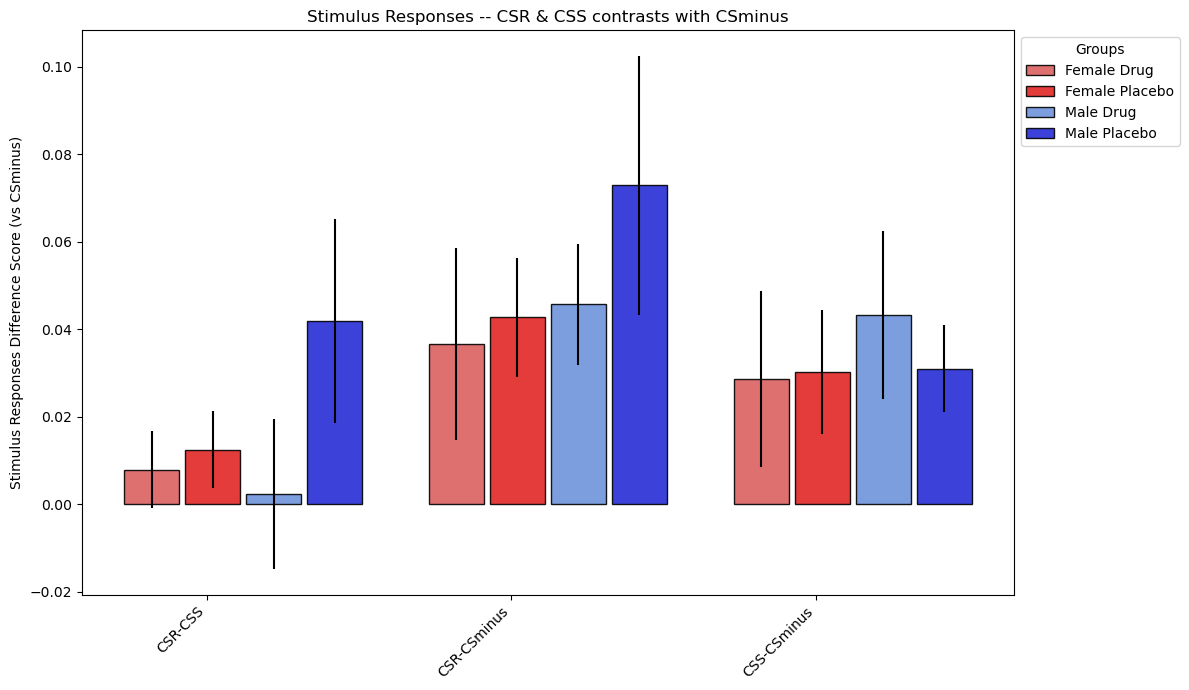

Statistical Test Results:


,Comparison,T-Stat,P-Value
0,Female Drug vs 0 (CSR-CSS),0.905749,0.376412
1,Female Placebo vs 0 (CSR-CSS),1.416164,0.173800
2,Male Drug vs 0 (CSR-CSS),0.138325,0.891609
3,Male Placebo vs 0 (CSR-CSS),1.800884,0.088500
4,Female Drug vs Placebo (CSR-CSS),-0.364804,0.717335
5,Male Drug vs Placebo (CSR-CSS),-1.356281,0.183695
6,Female vs Male Drug (CSR-CSS),0.298454,0.767072
7,Female vs Male Placebo (CSR-CSS),-1.182571,0.244731
8,Female Drug vs 0 (CSR-CSminus),1.665030,0.112311
9,Female Placebo vs 0 (CSR-CSminus),3.148016,0.005562


In [125]:
# ✅ Build contrast data from raw all_data and all_stats
def build_contrast_data(all_data):
    contrast_all_data = {}
    contrast_all_stats = {}

    # Define contrasts
    contrasts = {
        "CSR-CSS": ("CSR", "CSS"),
        "CSR-CSminus": ("CSR", "CSminus"),
       "CSS-CSminus": ("CSS", "CSminus")
    }

    for contrast_name, (stim1, stim2) in contrasts.items():
        for group in ['female_drug', 'female_placebo', 'male_drug', 'male_placebo']:
            # Compute raw difference scores for each subject
            data1 = np.array(all_data[f"{stim1}_{group}"])
            data2 = np.array(all_data[f"{stim2}_{group}"])
            diff_scores = data1 - data2

            # Store in contrast_all_data
            contrast_all_data[f"{contrast_name}_{group}"] = diff_scores

            # Compute mean and SE
            mean = np.nanmean(diff_scores)
            se = np.nanstd(diff_scores, ddof=1) / np.sqrt(len(diff_scores))
            contrast_all_stats[f"{contrast_name}_{group}"] = (mean, se)

    return contrast_all_data, contrast_all_stats


# ✅ Example usage before plotting
contrast_all_data, contrast_all_stats = build_contrast_data(all_data)

# Now run plotting function with contrast data
title = 'Stimulus Responses'
plot_multibar_with_error_bars(contrast_all_stats, contrast_all_data, title)


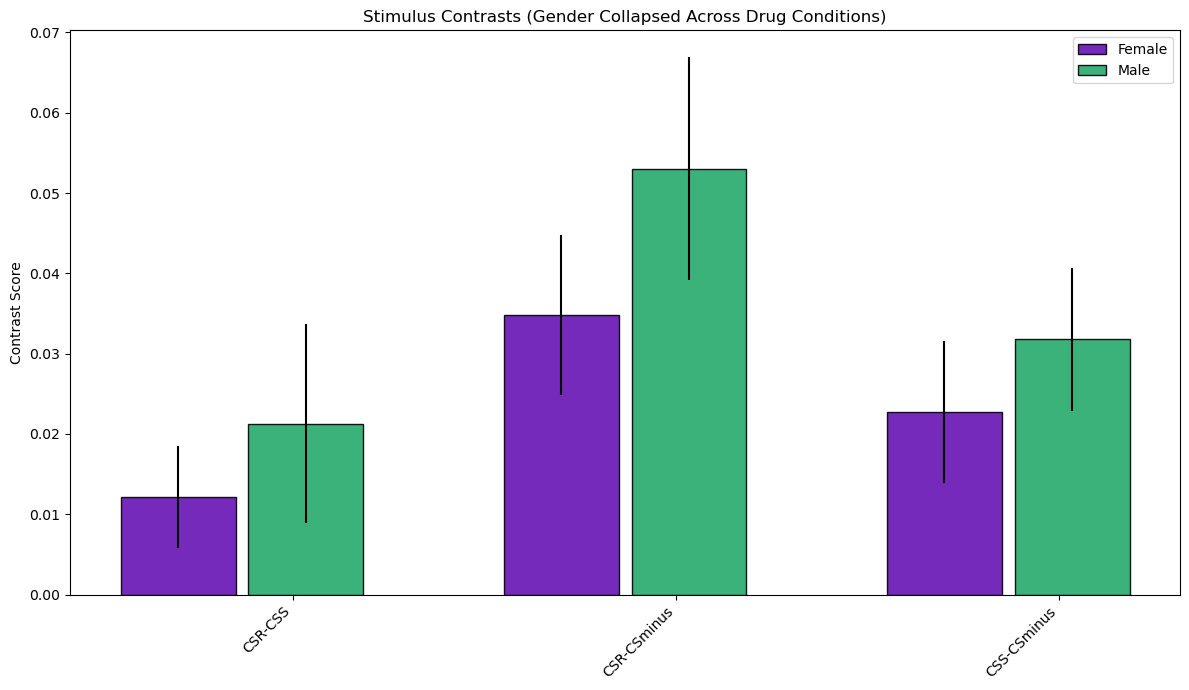


Statistical Test Results:


,Comparison,T-Stat,P-Value
0,Female vs 0 (CSR-CSS),1.905689,0.062020
1,Male vs 0 (CSR-CSS),1.717574,0.092750
2,Female vs Male (CSR-CSS),-0.689944,0.491844
3,Female vs 0 (CSR-CSminus),3.487068,0.000979
4,Male vs 0 (CSR-CSminus),3.826574,0.000398
5,Female vs Male (CSR-CSminus),-1.089272,0.278678
6,Female vs 0 (CSS-CSminus),2.559497,0.013316
7,Male vs 0 (CSS-CSminus),3.555579,0.000901
8,Female vs Male (CSS-CSminus),-0.713879,0.476982


In [349]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_1samp

# -------------------------------------------------------------
# Load and merge data
# -------------------------------------------------------------
drug_order = pd.read_excel("drug_order.xlsx", "drug_order")
data = pd.merge(dat_df, drug_order[['subID','drug_condition','gender_code']],
                on='subID', how='left')

# -------------------------------------------------------------
# Collapse groups BY GENDER ONLY
# -------------------------------------------------------------
data['Group'] = data['gender_code'].map({0: 'female', 1: 'male'})

# -------------------------------------------------------------
# Collect raw data by gender for each stimulus
# -------------------------------------------------------------
all_data = {}
all_stats = {}

stimuli = ['CSR', 'CSS', 'CSminus']

for stim in stimuli:
    col = f"mean{stim}3"   # e.g., meanCSR3
    for grp in ['female', 'male']:
        gdat = data[data['Group'] == grp][col].values
        
        all_data[f"{stim}_{grp}"] = gdat
        all_stats[f"{stim}_{grp}"] = (np.nanmean(gdat),
                                      np.nanstd(gdat, ddof=1)/np.sqrt(len(gdat)))

# -------------------------------------------------------------
# Build contrasts (CSR–CSS, CSR–CSminus, CSS–CSminus)
# -------------------------------------------------------------
def build_contrast_data(all_data):
    contrast_all_data = {}
    contrast_all_stats = {}

    contrasts = {
        "CSR-CSS": ("CSR", "CSS"),
        "CSR-CSminus": ("CSR", "CSminus"),
        "CSS-CSminus": ("CSS", "CSminus")
    }

    for contrast_name, (stim1, stim2) in contrasts.items():
        for grp in ['female', 'male']:
            d1 = np.array(all_data[f"{stim1}_{grp}"])
            d2 = np.array(all_data[f"{stim2}_{grp}"])
            diff = d1 - d2

            contrast_all_data[f"{contrast_name}_{grp}"] = diff

            mean = np.nanmean(diff)
            se   = np.nanstd(diff, ddof=1) / np.sqrt(len(diff))
            contrast_all_stats[f"{contrast_name}_{grp}"] = (mean, se)

    return contrast_all_data, contrast_all_stats

contrast_all_data, contrast_all_stats = build_contrast_data(all_data)

# -------------------------------------------------------------
# Prepare dataframe for plotting
# -------------------------------------------------------------
def prepare_data_for_multibar_plot(all_stats):
    rows = []
    contrasts = ['CSR-CSS','CSR-CSminus','CSS-CSminus']
    groups = ['female','male']
    for contrast in contrasts:
        for grp in groups:
            mean, se = all_stats[f"{contrast}_{grp}"]
            rows.append({
                'Contrast': contrast,
                'Group': grp.title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(rows)

# -------------------------------------------------------------
# Post-hoc tests
# -------------------------------------------------------------
def calculate_posthoc_tests(all_data):
    results = []
    contrasts = ['CSR-CSS','CSR-CSminus','CSS-CSminus']

    for contrast in contrasts:
        female = all_data[f"{contrast}_female"]
        male   = all_data[f"{contrast}_male"]

        # 1) Within each gender vs 0
        for name, values in [('Female', female), ('Male', male)]:
            t, p = ttest_1samp(values, 0, nan_policy='omit')
            results.append({
                'Comparison': f"{name} vs 0 ({contrast})",
                'T-Stat': t, 'P-Value': p
            })

        # 2) Female vs Male
        t, p = ttest_ind(female, male, nan_policy='omit')
        results.append({
            'Comparison': f"Female vs Male ({contrast})",
            'T-Stat': t, 'P-Value': p
        })

    return pd.DataFrame(results)

# -------------------------------------------------------------
# Plotting
# -------------------------------------------------------------
def plot_multibar_with_error_bars(all_stats, all_data, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)

    contrasts = df['Contrast'].unique()
    groups = df['Group'].unique()  # Female, Male

    plt.figure(figsize=(12, 7))
    width = 0.9
    colors = ["#6613b4", "#26aa6c"]  # female, male

    for i, contrast in enumerate(contrasts):
        x_pos = np.arange(len(groups)) + i * (len(groups) + 1)
        for j, group in enumerate(groups):
            row = df[(df['Contrast'] == contrast) & (df['Group'] == group)]
            plt.bar(
                x_pos[j],
                row['Mean'].values[0],
                yerr=row['SE'].values[0],
                width=width,
                color=colors[j],
                edgecolor='black',
                alpha=0.9,
                label=group if i == 0 else None
            )

    # Axis formatting
    tick_pos = [
        x + width for x in range(0, len(contrasts) * (len(groups) + 1), len(groups) + 1)
    ]
    plt.xticks(tick_pos, contrasts, rotation=45, ha='right')
    plt.ylabel("Contrast Score")
    plt.title(f"{title} (Gender Collapsed Across Drug Conditions)")
    plt.legend()
    plt.tight_layout()
    filename = 'gender-vs-earlyreinstatment.png'
    plt.savefig(filename, format='png', dpi=300)
    plt.show()
    
    print("\nStatistical Test Results:")
    display(stats_df)

# -------------------------------------------------------------
# Run plot
# -------------------------------------------------------------
title = "Stimulus Contrasts"
plot_multibar_with_error_bars(contrast_all_stats, contrast_all_data, title)


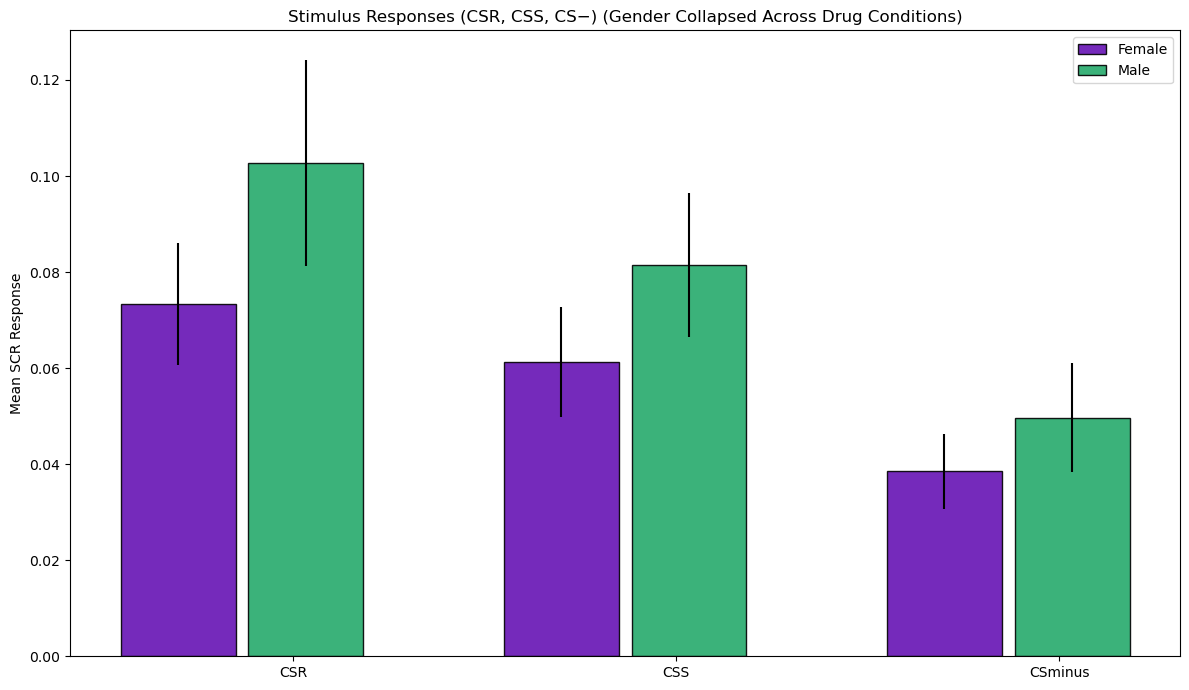


Statistical Test Results:


,Comparison,T-Stat,P-Value
0,Female vs Male (CSR),-1.228002,0.222358
1,Female vs Male (CSS),-1.092587,0.277227
2,Female vs Male (CSminus),-0.834203,0.406175


In [352]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_1samp

# -------------------------------------------------------------
# Load and merge data
# -------------------------------------------------------------
drug_order = pd.read_excel("drug_order.xlsx", "drug_order")
data = pd.merge(dat_df, drug_order[['subID','drug_condition','gender_code']],
                on='subID', how='left')

# -------------------------------------------------------------
# Collapse groups BY GENDER ONLY
# -------------------------------------------------------------
data['Group'] = data['gender_code'].map({0: 'female', 1: 'male'})

# -------------------------------------------------------------
# Collect raw data by gender for each stimulus
# -------------------------------------------------------------
stimuli = ['CSR', 'CSS', 'CSminus']

all_data = {}
all_stats = {}

for stim in stimuli:
    col = f"mean{stim}3"   # e.g., meanCSR3
    for grp in ['female', 'male']:
        gdat = data[data['Group'] == grp][col].values

        all_data[f"{stim}_{grp}"] = gdat
        all_stats[f"{stim}_{grp}"] = (
            np.nanmean(gdat),
            np.nanstd(gdat, ddof=1)/np.sqrt(len(gdat))
        )

# -------------------------------------------------------------
# Prepare dataframe for multibar plot (no contrasts!)
# -------------------------------------------------------------
def prepare_data_for_multibar_plot_raw(all_stats):
    rows = []
    stimuli = ['CSR','CSS','CSminus']
    groups = ['female','male']

    for stim in stimuli:
        for grp in groups:
            mean, se = all_stats[f"{stim}_{grp}"]
            rows.append({
                'Stimulus': stim,
                'Group': grp.title(),  # capitalize for plotting
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(rows)

# -------------------------------------------------------------
# Post-hoc tests: female vs male for CSR, CSS, CS-
# -------------------------------------------------------------
def calculate_posthoc_tests_raw(all_data):
    results = []
    stimuli = ['CSR','CSS','CSminus']

    for stim in stimuli:
        female = all_data[f"{stim}_female"]
        male   = all_data[f"{stim}_male"]

        # Female vs Male
        t, p = ttest_ind(female, male, nan_policy='omit')
        results.append({
            'Comparison': f"Female vs Male ({stim})",
            'T-Stat': t,
            'P-Value': p
        })

    return pd.DataFrame(results)
# -------------------------------------------------------------
# PLOT: CSR, CSS, CS- grouped by gender (NO CONTRASTS)
# -------------------------------------------------------------
def plot_stimuli_by_gender(all_stats, all_data, title):
    df = prepare_data_for_multibar_plot_raw(all_stats)
    stats_df = calculate_posthoc_tests_raw(all_data)

    stimuli = df['Stimulus'].unique()
    groups = df['Group'].unique()  # Female, Male

    plt.figure(figsize=(12, 7))
    width = 0.9
    colors = ["#6613b4", "#26aa6c"]  # female, male

    for i, stim in enumerate(stimuli):
        x_pos = np.arange(len(groups)) + i * (len(groups) + 1)
        for j, group in enumerate(groups):
            row = df[(df['Stimulus'] == stim) & (df['Group'] == group)]
            plt.bar(
                x_pos[j],
                row['Mean'].values[0],
                yerr=row['SE'].values[0],
                width=width,
                color=colors[j],
                edgecolor='black',
                alpha=0.9,
                label=group if i == 0 else None
            )

    tick_pos = [
        x + width for x in range(0, len(stimuli)*(len(groups) + 1), len(groups) + 1)
    ]

    plt.xticks(tick_pos, stimuli)
    plt.ylabel("Mean SCR Response")
    plt.title(f"{title} (Gender Collapsed Across Drug Conditions)")
    plt.legend()
    plt.tight_layout()

    filename = 'gender-vs-stimuli.png'
    plt.savefig(filename, format='png', dpi=300)
    plt.show()

    print("\nStatistical Test Results:")
    display(stats_df)

title = "Stimulus Responses (CSR, CSS, CS−)"
plot_stimuli_by_gender(all_stats, all_data, title)


### Phase 2 / 3 - early vs late (first half vs second half) 

In [1]:
import pandas as pd
import numpy as np

exclude_participants = 1

# Parameters to adjust:
trialnumber2_early = range(1, 13)  # Early trials for Phase 2 (1:12)
trialnumber2_late = range(13, 25)   # Late trials for Phase 2 (13:24)
trialnumber3_early = range(25, 37)  # Early trials for Phase 3 (25:36)
trialnumber3_late = range(37, 49)   # Late trials for Phase 3 (37:48)

excludeparticipants = 1  # Set to 0 to include all subjects; if set to 1, participants with rejected trials >= rejtrials_threshold are excluded
rejtrials_threshold = 24  # Threshold for trial rejection; adjust according to trial number

# Load data
peakstatstable = pd.read_csv('peak_stats_table-phase2.3.csv')
participants = peakstatstable['sid'].unique()
trial_types = peakstatstable['stTy'].unique()

# Separate data by participant, phase, and stim type
grouped_data = peakstatstable.groupby('sid')
dat = []

for participant in participants:
    data = grouped_data.get_group(participant)
    participant_data = {'subID': participant}

    # Ensuring consistent data structure
    if data.shape[0] == 48:
        
        # Phase 2 processing: stims numbered in trialnumber2
        phase2_data = data[data['stNum'].isin(range(1, 25))]
        rejTrials = phase2_data[phase2_data['phaBase2Peak'] < 0.02].index
        phase2_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials2'] = len(rejTrials)

        # Separate out stim types for early trials
        phase2_early_data = phase2_data[phase2_data['stNum'].isin(trialnumber2_early)]
        data2_early = {key: value for key, value in phase2_early_data.groupby('stTy')}
        
        # Calculate means and SE for early trials
        try:
            participant_data['meanCSS2_early'] = data2_early['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS2_early'] = data2_early['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data2_early['CS+S']))
            participant_data['nCSS2_early'] = len(data2_early['CS+S'])
            participant_data['meanCSR2_early'] = data2_early['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR2_early'] = data2_early['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data2_early['CS+R']))
            participant_data['nCSR2_early'] = len(data2_early['CS+R'])
            participant_data['meanCSminus2_early'] = data2_early['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus2_early'] = data2_early['CS-']['phaBase2Peak'].std() / np.sqrt(len(data2_early['CS-']))
            participant_data['nCSminus2_early'] = len(data2_early['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 2 early trials.")

        # Separate out stim types for late trials
        phase2_late_data = phase2_data[phase2_data['stNum'].isin(trialnumber2_late)]
        data2_late = {key: value for key, value in phase2_late_data.groupby('stTy')}
        
        # Calculate means and SE for late trials
        try:
            participant_data['meanCSS2_late'] = data2_late['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS2_late'] = data2_late['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data2_late['CS+S']))
            participant_data['nCSS2_late'] = len(data2_late['CS+S'])
            participant_data['meanCSR2_late'] = data2_late['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR2_late'] = data2_late['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data2_late['CS+R']))
            participant_data['nCSR2_late'] = len(data2_late['CS+R'])
            participant_data['meanCSminus2_late'] = data2_late['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus2_late'] = data2_late['CS-']['phaBase2Peak'].std() / np.sqrt(len(data2_late['CS-']))
            participant_data['nCSminus2_late'] = len(data2_late['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 2 late trials.")

        # Phase 3 processing: stims numbered in trialnumber3
        phase3_data = data[data['stNum'].isin(range(25, 49))]
        rejTrials = phase3_data[phase3_data['phaBase2Peak'] < 0.02].index
        phase3_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials3'] = len(rejTrials)

        # Separate out stim types for early trials
        phase3_early_data = phase3_data[phase3_data['stNum'].isin(trialnumber3_early)]
        data3_early = {key: value for key, value in phase3_early_data.groupby('stTy')}
        
        # Calculate means and SE for early trials
        try:
            participant_data['meanCSS3_early'] = data3_early['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS3_early'] = data3_early['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data3_early['CS+S']))
            participant_data['nCSS3_early'] = len(data3_early['CS+S'])
            participant_data['meanCSR3_early'] = data3_early['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR3_early'] = data3_early['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data3_early['CS+R']))
            participant_data['nCSR3_early'] = len(data3_early['CS+R'])
            participant_data['meanCSminus3_early'] = data3_early['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus3_early'] = data3_early['CS-']['phaBase2Peak'].std() / np.sqrt(len(data3_early['CS-']))
            participant_data['nCSminus3_early'] = len(data3_early['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 3 early trials.")

        # Separate out stim types for late trials
        phase3_late_data = phase3_data[phase3_data['stNum'].isin(trialnumber3_late)]
        data3_late = {key: value for key, value in phase3_late_data.groupby('stTy')}
        
        # Calculate means and SE for late trials
        try:
            participant_data['meanCSS3_late'] = data3_late['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS3_late'] = data3_late['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data3_late['CS+S']))
            participant_data['nCSS3_late'] = len(data3_late['CS+S'])
            participant_data['meanCSR3_late'] = data3_late['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR3_late'] = data3_late['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data3_late['CS+R']))
            participant_data['nCSR3_late'] = len(data3_late['CS+R'])
            participant_data['meanCSminus3_late'] = data3_late['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus3_late'] = data3_late['CS-']['phaBase2Peak'].std() / np.sqrt(len(data3_late['CS-']))
            participant_data['nCSminus3_late'] = len(data3_late['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 3 late trials.")

    # Add participant data to the main list
    dat.append(participant_data)


# Convert dat list to a DataFrame for easier viewing and export
dat_df = pd.DataFrame(dat)

if exclude_participants == 1:
    dat_df = dat_df[dat_df['rejTrials2'] < 24]

print(dat_df)


FileNotFoundError: [Errno 2] No such file or directory: 'peak_stats_table-phase2.3.csv'

#### Extinction 

In [474]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack early and late responses with a time variable
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR2_early', 'meanCSR2_late', 'meanCSS2_early', 'meanCSS2_late', 'meanCSminus2_early', 'meanCSminus2_late'], 
                    var_name='stim_type_time', 
                    value_name='response')

# Split 'stim_type_time' into separate 'stim_type' and 'time' columns
long_data['stim_type'] = long_data['stim_type_time'].str.extract(r'mean(\w+)_')[0]
long_data['time'] = long_data['stim_type_time'].str.extract(r'_(\w+)$')[0].map({'early': 1, 'late': 2})

# Map stim_type to numerical codes
long_data['stim_type'] = long_data['stim_type'].map({
    'CSR2': 1, 
    'CSS2': 2, 
    'CSminus2': 3
})

# Specify the model with time as a main effect
model_formula = 'response ~ patient_group * drug * stim_type + time + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.726
Date:                Mon, 11 Nov 2024   Prob (F-statistic):             0.0798
Time:                        09:02:39   Log-Likelihood:                 816.73
No. Observations:                 606   AIC:                            -1613.
Df Residuals:                     596   BIC:                            -1569.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [389]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# # Filter to include only individuals in the placebo condition (drug_order = 0)
# merged_data = merged_data[merged_data['drug'] == 0]


# Reshape data to stack early and late responses with a time variable
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR2_early', 'meanCSR2_late', 'meanCSS2_early', 'meanCSS2_late', 'meanCSminus2_early', 'meanCSminus2_late'], 
                    var_name='stim_type_time', 
                    value_name='response')

# Split 'stim_type_time' into separate 'stim_type' and 'time' columns
long_data['stim_type'] = long_data['stim_type_time'].str.extract(r'mean(\w+)_')[0]
long_data['time'] = long_data['stim_type_time'].str.extract(r'_(\w+)$')[0].map({'early': 1, 'late': 2})

# Map stim_type to numerical codes
long_data['stim_type'] = long_data['stim_type'].map({
    'CSR2': 1, 
    'CSS2': 2, 
    'CSminus2': 3
})

# Define the model formula without the patient_group term, as we are running separate models for each group
# model_formula = 'response ~ stim_type + drug + time + gender'
model_formula = 'response ~ stim_type * drug + time + gender'

# Run regression for patients (patient_group = 1)
patient_data = long_data[long_data['patient_group'] == 1]
patient_model = smf.ols(formula=model_formula, data=patient_data).fit()
print("Patient Group Regression Results:")
print(patient_model.summary())

# Run regression for controls (patient_group = 0)
control_data = long_data[long_data['patient_group'] == 0]
control_model = smf.ols(formula=model_formula, data=control_data).fit()
print("\nControl Group Regression Results:")
print(control_model.summary())


Patient Group Regression Results:
                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.387
Date:                Fri, 08 Nov 2024   Prob (F-statistic):              0.229
Time:                        10:48:32   Log-Likelihood:                 393.02
No. Observations:                 294   AIC:                            -774.0
Df Residuals:                     288   BIC:                            -751.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept 

In [391]:
import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx",'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID', 'drug_condition']], on='subID', how='left')

# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        'patients_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
        'patients_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
        'controls_drug' if row['subID'].startswith('N2') and row['drug_condition'] == 1 else
        'controls_placebo'
    ), axis=1
)

# Initialize dictionary to store means and SEs
all_stats = {}

# Calculate means and SEs for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Early stage statistics for CSS2
    mean_early = group_data['meanCSS2_early'].mean()
    se_early = group_data['meanCSS2_early'].sem()
    all_stats[f'CSS_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSS2
    mean_late = group_data['meanCSS2_late'].mean()
    se_late = group_data['meanCSS2_late'].sem()
    all_stats[f'CSS_{group}_late'] = (mean_late, se_late)

    # Early stage statistics for CSR2
    mean_early = group_data['meanCSR2_early'].mean()
    se_early = group_data['meanCSR2_early'].sem()
    all_stats[f'CSR_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSR2
    mean_late = group_data['meanCSR2_late'].mean()
    se_late = group_data['meanCSR2_late'].sem()
    all_stats[f'CSR_{group}_late'] = (mean_late, se_late)

    # Early stage statistics for CSR2
    mean_early = group_data['meanCSminus2_early'].mean()
    se_early = group_data['meanCSminus2_early'].sem()
    all_stats[f'CSminus_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSR2
    mean_late = group_data['meanCSminus2_late'].mean()
    se_late = group_data['meanCSminus2_late'].sem()
    all_stats[f'CSminus_{group}_late'] = (mean_late, se_late)

import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx", 'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID', 'drug_condition']], on='subID', how='left')

# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        'patients_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
        'patients_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
        'controls_drug' if row['subID'].startswith('N2') and row['drug_condition'] == 1 else
        'controls_placebo'
    ), axis=1
)

# Initialize dictionary to store all data
all_data = {}

# Populate all_data with raw data for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Store early and late stage data for each stimulus type
    all_data[f'CSS_{group}_early'] = group_data['meanCSS2_early'].values
    all_data[f'CSS_{group}_late'] = group_data['meanCSS2_late'].values
    all_data[f'CSR_{group}_early'] = group_data['meanCSR2_early'].values
    all_data[f'CSR_{group}_late'] = group_data['meanCSR2_late'].values
    all_data[f'CSminus_{group}_early'] = group_data['meanCSminus2_early'].values
    all_data[f'CSminus_{group}_late'] = group_data['meanCSminus2_late'].values



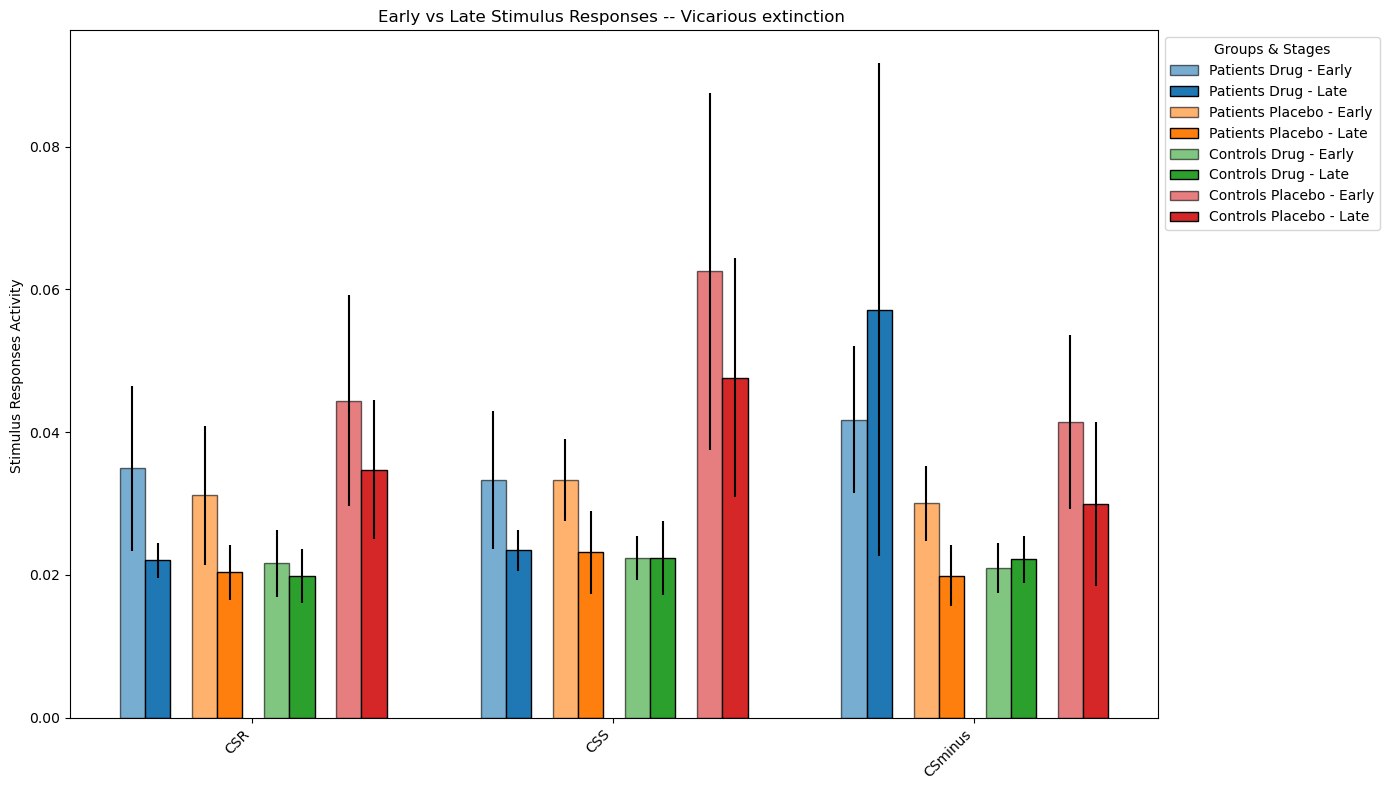

Statistical Test Results:


,Comparison,T-Stat,P-Value
0,patients_drug Early vs Late (CSR),1.069771,0.294554
1,patients_placebo Early vs Late (CSR),1.374439,0.183797
2,controls_drug Early vs Late (CSR),0.423700,0.675721
3,controls_placebo Early vs Late (CSR),1.285625,0.209492
4,Patients Drug vs Placebo (CSR Early),0.241878,0.809927
5,Control Drug vs Placebo (CSR Early),-1.373479,0.175731
6,Patients vs Controls Drug (CSR Early),1.022938,0.311361
7,Patients vs Controls Placebo (CSR Early),-0.704310,0.484643
8,Patients Drug vs Placebo (CSR Late),0.381760,0.704360
9,Control Drug vs Placebo (CSR Late),-1.339884,0.186341


In [392]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            for stage in ['early', 'late']:
                mean, se = all_stats[f'{stimulus}_{group}_{stage}']
                data.append({
                    'Stimulus': stimulus,
                    'Group': group.replace('_', ' ').title(),
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to perform post-hoc t-tests using raw data in all_data
def calculate_posthoc_tests(all_data):
    results = []
    
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            early_values = all_data[f'{stimulus}_{group}_early']
            late_values = all_data[f'{stimulus}_{group}_late']
            t_stat, p_value = ttest_rel(early_values, late_values) if len(early_values) > 1 and len(late_values) > 1 else (np.nan, np.nan)
            results.append({'Comparison': f'{group} Early vs Late ({stimulus})', 'T-Stat': t_stat, 'P-Value': p_value})
        
        for stage in ['early', 'late']:
            patient_drug = all_data[f'{stimulus}_patients_drug_{stage}']
            patient_placebo = all_data[f'{stimulus}_patients_placebo_{stage}']
            control_drug = all_data[f'{stimulus}_controls_drug_{stage}']
            control_placebo = all_data[f'{stimulus}_controls_placebo_{stage}']

            for group_pair, (data1, data2) in {
                'Patients Drug vs Placebo': (patient_drug, patient_placebo),
                'Control Drug vs Placebo': (control_drug, control_placebo),
                'Patients vs Controls Drug': (patient_drug, control_drug),
                'Patients vs Controls Placebo': (patient_placebo, control_placebo)
            }.items():
                t_stat, p_value = ttest_ind(data1, data2) if len(data1) > 1 and len(data2) > 1 else (np.nan, np.nan)
                results.append({'Comparison': f'{group_pair} ({stimulus} {stage.capitalize()})', 'T-Stat': t_stat, 'P-Value': p_value})
    
    return pd.DataFrame(results)

# Function to plot a multibar plot with error bars and significant annotations
def plot_multibar_with_error_bars(all_stats, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)  # Use all_data for post-hoc tests
    
    plt.figure(figsize=(14, 8))
    stimuli = df['Stimulus'].unique()
    groups = df['Group'].unique()
    width = 0.35  # Width of each bar
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each group

    # Plotting for each stimulus category
    for i, stimulus in enumerate(stimuli):
        x_pos = np.arange(len(groups)) + i * (len(groups) + 1)  # Set x position for each stimulus group
        
        for j, group in enumerate(groups):
            group_data_early = df[(df['Stimulus'] == stimulus) & (df['Group'] == group) & (df['Stage'] == 'Early')]
            group_data_late = df[(df['Stimulus'] == stimulus) & (df['Group'] == group) & (df['Stage'] == 'Late')]
            
            # Plot bars with error bars
            plt.bar(x_pos[j] - width/2, group_data_early['Mean'].values[0], yerr=group_data_early['SE'].values[0],
                    width=width, color=colors[j], alpha=0.6, edgecolor='black', label=f'{group} - Early' if i == 0 else "")
            plt.bar(x_pos[j] + width/2, group_data_late['Mean'].values[0], yerr=group_data_late['SE'].values[0],
                    width=width, color=colors[j], alpha=1, edgecolor='black', label=f'{group} - Late' if i == 0 else "")

            # Annotate significant differences
            comparison_early_late = f'{group.replace(" ", "_").lower()}_early_vs_late_{stimulus.lower()}'
            if not stats_df[stats_df['Comparison'] == comparison_early_late].empty:
                p_value = stats_df[stats_df['Comparison'] == comparison_early_late]['P-Value'].values[0]
                if p_value < 0.05:
                    y = max(group_data_early['Mean'].values[0] + group_data_early['SE'].values[0],
                            group_data_late['Mean'].values[0] + group_data_late['SE'].values[0]) + 0.1
                    plt.plot([x_pos[j] - width/2, x_pos[j] + width/2], [y, y], color='black')
                    plt.text(x_pos[j], y + 0.05, '*', ha='center', va='bottom', color='black')

    # Customize the plot
    tick_pos = [x + width * 4.25 for x in range(0, len(stimuli) * (len(groups) + 1), len(groups) + 1)]
    plt.xticks(tick_pos, stimuli, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity ')
    plt.title(f'Early vs Late {title} -- Vicarious extinction ')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout()
    plt.show()

    # Display statistical table below the plot
    print("Statistical Test Results:")
    display(stats_df)

# Plot combined multibar plot for all stimulus categories
title = 'Stimulus Responses'
plot_multibar_with_error_bars(all_stats, title)


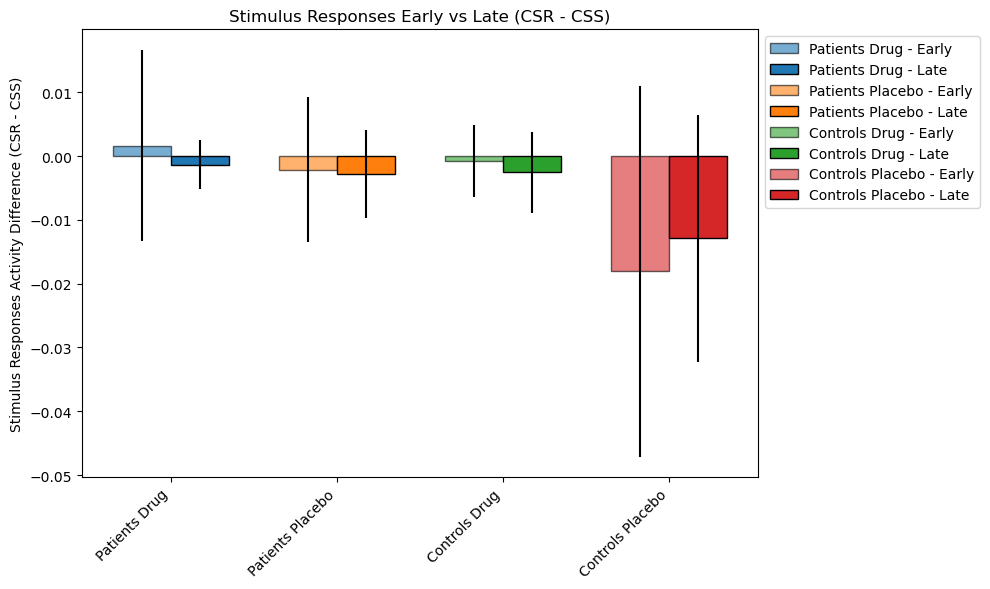

Within-Group Early vs Late Statistical Test Results:


,Comparison,T-Stat,P-Value
0,patients_drug Early vs Late (CSR - CSS),0.342114,0.735015
1,patients_placebo Early vs Late (CSR - CSS),0.056192,0.955720
2,controls_drug Early vs Late (CSR - CSS),0.297451,0.768792
3,controls_placebo Early vs Late (CSR - CSS),-0.369764,0.714443



Drug vs Placebo Statistical Test Results:


,Comparison,T-Stat,P-Value
0,Patients Drug vs Placebo - Early (CSR - CSS),0.315099,0.754220
1,Controls Drug vs Placebo - Early (CSR - CSS),1.300234,0.202892
2,Patients Drug vs Placebo - Late (CSR - CSS),0.294497,0.769811
3,Controls Drug vs Placebo - Late (CSR - CSS),1.058388,0.295981


In [395]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind

# Function to prepare data specifically for CSR - CSS comparisons
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
        for stage in ['early', 'late']:
            mean_csr, se_csr = all_stats[f'CSR_{group}_{stage}']
            mean_css, se_css = all_stats[f'CSS_{group}_{stage}']
            mean_diff = mean_csr - mean_css
            se_diff = np.sqrt(se_csr**2 + se_css**2)  # Assuming independence for SEs
            data.append({
                'Group': group.replace('_', ' ').title(),
                'Stage': 'Early' if stage == 'early' else 'Late',
                'Mean Difference (CSR - CSS)': mean_diff,
                'SE Difference': se_diff
            })
    return pd.DataFrame(data)

# Function to perform post-hoc t-tests for CSR - CSS differences
def calculate_posthoc_tests(all_data):
    results = []
    for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
        early_values_csr = all_data[f'CSR_{group}_early']
        early_values_css = all_data[f'CSS_{group}_early']
        late_values_csr = all_data[f'CSR_{group}_late']
        late_values_css = all_data[f'CSS_{group}_late']
        
        # Calculate CSR - CSS differences
        early_diff = np.array(early_values_csr) - np.array(early_values_css)
        late_diff = np.array(late_values_csr) - np.array(late_values_css)
        
        # Perform paired t-tests for early vs late within each group
        t_stat, p_value = ttest_rel(early_diff, late_diff) if len(early_diff) > 1 and len(late_diff) > 1 else (np.nan, np.nan)
        results.append({'Comparison': f'{group} Early vs Late (CSR - CSS)', 'T-Stat': t_stat, 'P-Value': p_value})
    
    return pd.DataFrame(results)

# Function to perform post-hoc t-tests between drug and placebo within each group
def calculate_drug_placebo_tests(all_data):
    results = []
    for stage in ['early', 'late']:
        # Patients: Drug vs Placebo
        patients_drug = np.array(all_data[f'CSR_patients_drug_{stage}']) - np.array(all_data[f'CSS_patients_drug_{stage}'])
        patients_placebo = np.array(all_data[f'CSR_patients_placebo_{stage}']) - np.array(all_data[f'CSS_patients_placebo_{stage}'])
        t_stat, p_value = ttest_ind(patients_drug, patients_placebo, equal_var=False)
        results.append({'Comparison': f'Patients Drug vs Placebo - {stage.title()} (CSR - CSS)', 'T-Stat': t_stat, 'P-Value': p_value})
        
        # Controls: Drug vs Placebo
        controls_drug = np.array(all_data[f'CSR_controls_drug_{stage}']) - np.array(all_data[f'CSS_controls_drug_{stage}'])
        controls_placebo = np.array(all_data[f'CSR_controls_placebo_{stage}']) - np.array(all_data[f'CSS_controls_placebo_{stage}'])
        t_stat, p_value = ttest_ind(controls_drug, controls_placebo, equal_var=False)
        results.append({'Comparison': f'Controls Drug vs Placebo - {stage.title()} (CSR - CSS)', 'T-Stat': t_stat, 'P-Value': p_value})
    
    return pd.DataFrame(results)

# Function to plot multibar plot for CSR - CSS differences with error bars
def plot_multibar_with_error_bars(all_stats, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)  # Use all_data for post-hoc tests
    drug_placebo_df = calculate_drug_placebo_tests(all_data)  # Additional post-hoc tests for drug vs placebo
    
    plt.figure(figsize=(10, 6))
    groups = df['Group'].unique()
    width = 0.35
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    # Plotting CSR - CSS differences for each group and stage
    for j, group in enumerate(groups):
        group_data_early = df[(df['Group'] == group) & (df['Stage'] == 'Early')]
        group_data_late = df[(df['Group'] == group) & (df['Stage'] == 'Late')]
        
        # Plot bars with error bars
        plt.bar(j - width/2, group_data_early['Mean Difference (CSR - CSS)'].values[0],
                yerr=group_data_early['SE Difference'].values[0], width=width, color=colors[j], alpha=0.6,
                edgecolor='black', label=f'{group} - Early')
        plt.bar(j + width/2, group_data_late['Mean Difference (CSR - CSS)'].values[0],
                yerr=group_data_late['SE Difference'].values[0], width=width, color=colors[j], alpha=1,
                edgecolor='black', label=f'{group} - Late')
        
        # Annotate significant differences
        comparison = f'{group.replace(" ", "_").lower()}_early_vs_late'
        if not stats_df[stats_df['Comparison'] == comparison].empty:
            p_value = stats_df[stats_df['Comparison'] == comparison]['P-Value'].values[0]
            if p_value < 0.05:
                y = max(group_data_early['Mean Difference (CSR - CSS)'].values[0] + group_data_early['SE Difference'].values[0],
                        group_data_late['Mean Difference (CSR - CSS)'].values[0] + group_data_late['SE Difference'].values[0]) + 0.1
                plt.plot([j - width/2, j + width/2], [y, y], color='black')
                plt.text(j, y + 0.05, '*', ha='center', va='bottom', color='black')
    
    # Customize the plot 
    plt.xticks(range(len(groups)), groups, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity Difference (CSR - CSS)')
    plt.title(f'{title} Early vs Late (CSR - CSS)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()
    
    # Display statistical tables
    print("Within-Group Early vs Late Statistical Test Results:")
    display(stats_df)
    
    print("\nDrug vs Placebo Statistical Test Results:")
    display(drug_placebo_df)

# Run the plot for CSR - CSS differences
title = 'Stimulus Responses'
plot_multibar_with_error_bars(all_stats, title)


In [372]:
#### just placebo condition ! 
import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx", 'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID', 'drug_condition']], on='subID', how='left')

# Filter to include only individuals in the placebo condition (drug_order = 0)
data = data[data['drug_condition'] == 0]


# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        # 'patients_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
        'patients_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
        # 'controls_drug' if row['subID'].startswith('N2') and row['drug_condition'] == 1 else
        'controls_placebo'
    ), axis=1
)


# Initialize dictionary to store means and SEs
all_stats = {}

# Calculate means and SEs for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Early stage statistics for CSS2
    mean_early = group_data['meanCSS2_early'].mean()
    se_early = group_data['meanCSS2_early'].sem()
    all_stats[f'CSS_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSS2
    mean_late = group_data['meanCSS2_late'].mean()
    se_late = group_data['meanCSS2_late'].sem()
    all_stats[f'CSS_{group}_late'] = (mean_late, se_late)

    # Early stage statistics for CSR2
    mean_early = group_data['meanCSR2_early'].mean()
    se_early = group_data['meanCSR2_early'].sem()
    all_stats[f'CSR_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSR2
    mean_late = group_data['meanCSR2_late'].mean()
    se_late = group_data['meanCSR2_late'].sem()
    all_stats[f'CSR_{group}_late'] = (mean_late, se_late)

    # Early stage statistics for CSR2
    mean_early = group_data['meanCSminus2_early'].mean()
    se_early = group_data['meanCSminus2_early'].sem()
    all_stats[f'CSminus_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSR2
    mean_late = group_data['meanCSminus2_late'].mean()
    se_late = group_data['meanCSminus2_late'].sem()
    all_stats[f'CSminus_{group}_late'] = (mean_late, se_late)

import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx", 'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID', 'drug_condition']], on='subID', how='left')

# Filter to include only individuals in the placebo condition (drug_order = 0)
data = data[data['drug_condition'] == 0]


# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        # 'patients_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
        'patients_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
        # 'controls_drug' if row['subID'].startswith('N2') and row['drug_condition'] == 1 else
        'controls_placebo'
    ), axis=1
)

# Initialize dictionary to store all data
all_data = {}

# Populate all_data with raw data for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Store early and late stage data for each stimulus type
    all_data[f'CSS_{group}_early'] = group_data['meanCSS2_early'].values
    all_data[f'CSS_{group}_late'] = group_data['meanCSS2_late'].values
    all_data[f'CSR_{group}_early'] = group_data['meanCSR2_early'].values
    all_data[f'CSR_{group}_late'] = group_data['meanCSR2_late'].values
    all_data[f'CSminus_{group}_early'] = group_data['meanCSminus2_early'].values
    all_data[f'CSminus_{group}_late'] = group_data['meanCSminus2_late'].values



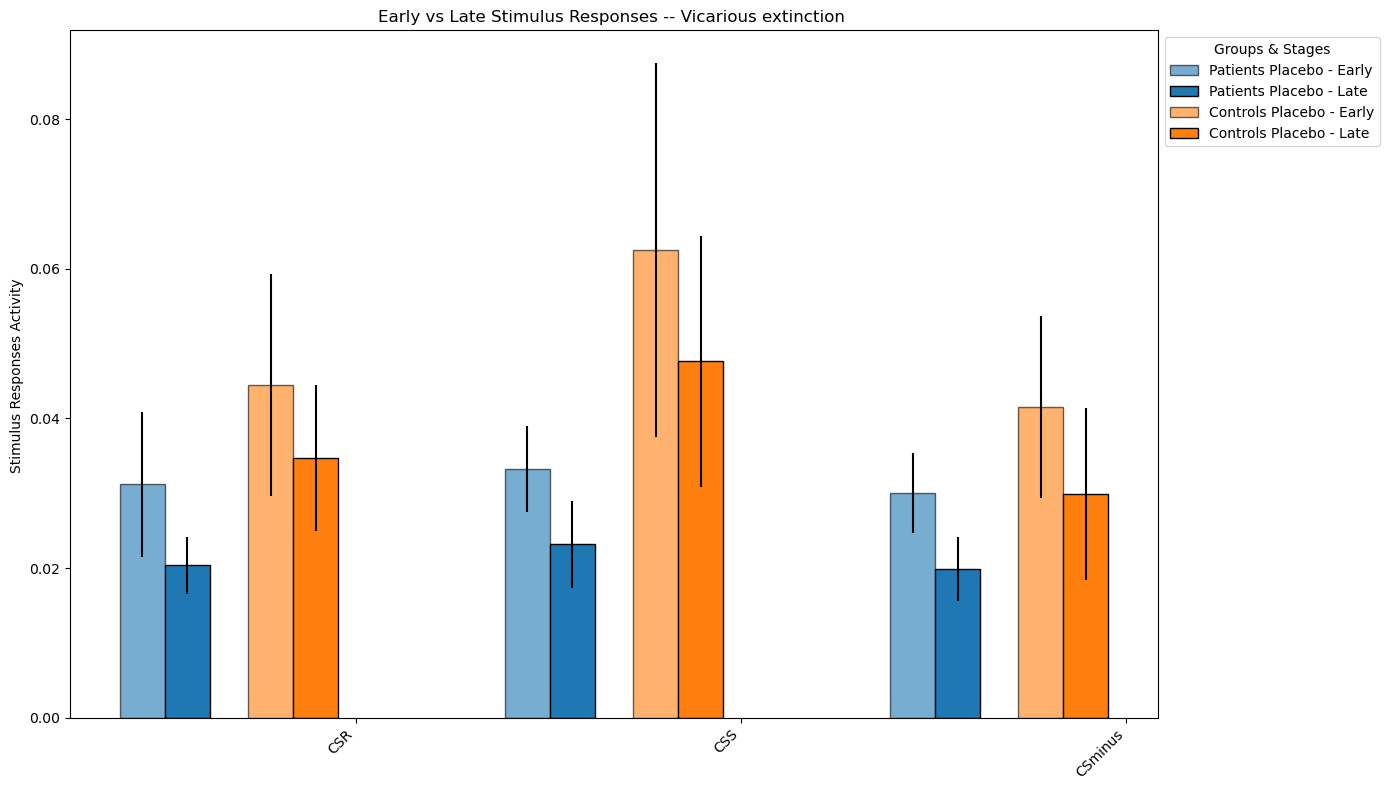

Statistical Test Results:


,Comparison,T-Stat,P-Value
0,patients_placebo Early vs Late (CSR),1.374439,0.183797
1,controls_placebo Early vs Late (CSR),1.285625,0.209492
2,Patients vs Controls Placebo (CSR Early),-0.704310,0.484643
3,Patients vs Controls Placebo (CSR Late),-1.244881,0.219219
4,patients_placebo Early vs Late (CSS),1.499589,0.148605
5,controls_placebo Early vs Late (CSS),0.891609,0.380480
6,Patients vs Controls Placebo (CSS Early),-1.018761,0.313424
7,Patients vs Controls Placebo (CSS Late),-1.247182,0.218382
8,patients_placebo Early vs Late (CSminus),2.058912,0.052120
9,controls_placebo Early vs Late (CSminus),2.232948,0.034038


In [373]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_placebo','controls_placebo']:
            for stage in ['early', 'late']:
                mean, se = all_stats[f'{stimulus}_{group}_{stage}']
                data.append({
                    'Stimulus': stimulus,
                    'Group': group.replace('_', ' ').title(),
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to perform post-hoc t-tests using raw data in all_data
def calculate_posthoc_tests(all_data):
    results = []
    
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_placebo','controls_placebo']:
            early_values = all_data[f'{stimulus}_{group}_early']
            late_values = all_data[f'{stimulus}_{group}_late']
            t_stat, p_value = ttest_rel(early_values, late_values) if len(early_values) > 1 and len(late_values) > 1 else (np.nan, np.nan)
            results.append({'Comparison': f'{group} Early vs Late ({stimulus})', 'T-Stat': t_stat, 'P-Value': p_value})
        
        for stage in ['early', 'late']:
            patient_placebo = all_data[f'{stimulus}_patients_placebo_{stage}']
            control_placebo = all_data[f'{stimulus}_controls_placebo_{stage}']

            for group_pair, (data1, data2) in {
                'Patients vs Controls Placebo': (patient_placebo, control_placebo)
            }.items():
                t_stat, p_value = ttest_ind(data1, data2) if len(data1) > 1 and len(data2) > 1 else (np.nan, np.nan)
                results.append({'Comparison': f'{group_pair} ({stimulus} {stage.capitalize()})', 'T-Stat': t_stat, 'P-Value': p_value})
    
    return pd.DataFrame(results)

# Function to plot a multibar plot with error bars and significant annotations
def plot_multibar_with_error_bars(all_stats, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)  # Use all_data for post-hoc tests
    
    plt.figure(figsize=(14, 8))
    stimuli = df['Stimulus'].unique()
    groups = df['Group'].unique()
    width = 0.35  # Width of each bar
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each group

    # Plotting for each stimulus category
    for i, stimulus in enumerate(stimuli):
        x_pos = np.arange(len(groups)) + i * (len(groups) + 1)  # Set x position for each stimulus group
        
        for j, group in enumerate(groups):
            group_data_early = df[(df['Stimulus'] == stimulus) & (df['Group'] == group) & (df['Stage'] == 'Early')]
            group_data_late = df[(df['Stimulus'] == stimulus) & (df['Group'] == group) & (df['Stage'] == 'Late')]
            
            # Plot bars with error bars
            plt.bar(x_pos[j] - width/2, group_data_early['Mean'].values[0], yerr=group_data_early['SE'].values[0],
                    width=width, color=colors[j], alpha=0.6, edgecolor='black', label=f'{group} - Early' if i == 0 else "")
            plt.bar(x_pos[j] + width/2, group_data_late['Mean'].values[0], yerr=group_data_late['SE'].values[0],
                    width=width, color=colors[j], alpha=1, edgecolor='black', label=f'{group} - Late' if i == 0 else "")

            # Annotate significant differences
            comparison_early_late = f'{group.replace(" ", "_").lower()}_early_vs_late_{stimulus.lower()}'
            if not stats_df[stats_df['Comparison'] == comparison_early_late].empty:
                p_value = stats_df[stats_df['Comparison'] == comparison_early_late]['P-Value'].values[0]
                if p_value < 0.05:
                    y = max(group_data_early['Mean'].values[0] + group_data_early['SE'].values[0],
                            group_data_late['Mean'].values[0] + group_data_late['SE'].values[0]) + 0.1
                    plt.plot([x_pos[j] - width/2, x_pos[j] + width/2], [y, y], color='black')
                    plt.text(x_pos[j], y + 0.05, '*', ha='center', va='bottom', color='black')

    # Customize the plot
    tick_pos = [x + width * 4.25 for x in range(0, len(stimuli) * (len(groups) + 1), len(groups) + 1)]
    plt.xticks(tick_pos, stimuli, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity ')
    plt.title(f'Early vs Late {title} -- Vicarious extinction ')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout()
    plt.show()

    # Display statistical table below the plot
    print("Statistical Test Results:")
    display(stats_df)

# Plot combined multibar plot for all stimulus categories
title = 'Stimulus Responses'
plot_multibar_with_error_bars(all_stats, title)


In [ ]:
for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_placebo','controls_placebo']:
            early_values = all_data[f'{stimulus}_{group}_early']
            late_values = all_data[f'{stimulus}_{group}_late']
            t_stat, p_value = ttest_rel(early_values, late_values) if len(early_values) > 1 and len(late_values) > 1 else (np.nan, np.nan)
            results.append({'Comparison': f'{group} Early vs Late ({stimulus})', 'T-Stat': t_stat, 'P-Value': p_value})
        

In [377]:
all_data['CSS_patients_placebo_early']

array([0.0178    , 0.00966667, 0.08666667, 0.008     , 0.        ,
       0.        , 0.05133333, 0.02066667, 0.02233333, 0.02733333,
       0.04266667, 0.041     , 0.        , 0.055     , 0.09233333,
       0.05033333, 0.022     , 0.06      , 0.        , 0.02466667,
       0.04433333, 0.056     ])

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_placebo','controls_placebo']:
            for stage in ['early', 'late']:
                mean, se = all_stats[f'{stimulus}_{group}_{stage}']
                data.append({
                    'Stimulus': stimulus,
                    'Group': group.replace('_', ' ').title(),
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to perform post-hoc t-tests using raw data in all_data
def calculate_posthoc_tests(all_data):
    results = []
    
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_placebo','controls_placebo']:
            early_values = all_data[f'{stimulus}_{group}_early']
            late_values = all_data[f'{stimulus}_{group}_late']
            t_stat, p_value = ttest_rel(early_values, late_values) if len(early_values) > 1 and len(late_values) > 1 else (np.nan, np.nan)
            results.append({'Comparison': f'{group} Early vs Late ({stimulus})', 'T-Stat': t_stat, 'P-Value': p_value})
        
        for stage in ['early', 'late']:
            patient_placebo = all_data[f'{stimulus}_patients_placebo_{stage}']
            control_placebo = all_data[f'{stimulus}_controls_placebo_{stage}']

            for group_pair, (data1, data2) in {
                'Patients vs Controls Placebo': (patient_placebo, control_placebo)
            }.items():
                t_stat, p_value = ttest_ind(data1, data2) if len(data1) > 1 and len(data2) > 1 else (np.nan, np.nan)
                results.append({'Comparison': f'{group_pair} ({stimulus} {stage.capitalize()})', 'T-Stat': t_stat, 'P-Value': p_value})
    
    return pd.DataFrame(results)

# Function to plot a multibar plot with error bars and significant annotations
def plot_multibar_with_error_bars(all_stats, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)  # Use all_data for post-hoc tests
    
    plt.figure(figsize=(14, 8))
    stimuli = df['Stimulus'].unique()
    groups = df['Group'].unique()
    width = 0.35  # Width of each bar
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each group

    # Plotting for each stimulus category
    for i, stimulus in enumerate(stimuli):
        x_pos = np.arange(len(groups)) + i * (len(groups) + 1)  # Set x position for each stimulus group
        
        for j, group in enumerate(groups):
            group_data_early = df[(df['Stimulus'] == stimulus) & (df['Group'] == group) & (df['Stage'] == 'Early')]
            group_data_late = df[(df['Stimulus'] == stimulus) & (df['Group'] == group) & (df['Stage'] == 'Late')]
            
            # Plot bars with error bars
            plt.bar(x_pos[j] - width/2, group_data_early['Mean'].values[0], yerr=group_data_early['SE'].values[0],
                    width=width, color=colors[j], alpha=0.6, edgecolor='black', label=f'{group} - Early' if i == 0 else "")
            plt.bar(x_pos[j] + width/2, group_data_late['Mean'].values[0], yerr=group_data_late['SE'].values[0],
                    width=width, color=colors[j], alpha=1, edgecolor='black', label=f'{group} - Late' if i == 0 else "")

            # Annotate significant differences
            comparison_early_late = f'{group.replace(" ", "_").lower()}_early_vs_late_{stimulus.lower()}'
            if not stats_df[stats_df['Comparison'] == comparison_early_late].empty:
                p_value = stats_df[stats_df['Comparison'] == comparison_early_late]['P-Value'].values[0]
                if p_value < 0.05:
                    y = max(group_data_early['Mean'].values[0] + group_data_early['SE'].values[0],
                            group_data_late['Mean'].values[0] + group_data_late['SE'].values[0]) + 0.1
                    plt.plot([x_pos[j] - width/2, x_pos[j] + width/2], [y, y], color='black')
                    plt.text(x_pos[j], y + 0.05, '*', ha='center', va='bottom', color='black')

    # Customize the plot
    tick_pos = [x + width * 4.25 for x in range(0, len(stimuli) * (len(groups) + 1), len(groups) + 1)]
    plt.xticks(tick_pos, stimuli, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity ')
    plt.title(f'Early vs Late {title} -- Vicarious extinction ')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout()
    plt.show()

    # Display statistical table below the plot
    print("Statistical Test Results:")
    display(stats_df)

# Plot combined multibar plot for all stimulus categories
title = 'Stimulus Responses'
plot_multibar_with_error_bars(all_stats, title)


#### Reinstatement

In [171]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack early and late responses with a time variable
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR3_early', 'meanCSR3_late', 'meanCSS3_early', 'meanCSS3_late', 'meanCSminus3_early', 'meanCSminus3_late'], 
                    var_name='stim_type_time', 
                    value_name='response')

# Split 'stim_type_time' into separate 'stim_type' and 'time' columns
long_data['stim_type'] = long_data['stim_type_time'].str.extract(r'mean(\w+)_')[0]
long_data['time'] = long_data['stim_type_time'].str.extract(r'_(\w+)$')[0].map({'early': 0, 'late': 1})

# Map stim_type to numerical codes
long_data['stim_type'] = long_data['stim_type'].map({
    'CSR3': 1, 
    'CSS3': 2, 
    'CSminus3': 3
})

# Specify the model with time as a main effect
model_formula = 'response ~ patient_group * drug * stim_type + time + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     5.948
Date:                Tue, 02 Sep 2025   Prob (F-statistic):           5.46e-08
Time:                        09:07:31   Log-Likelihood:                 628.45
No. Observations:                 606   AIC:                            -1237.
Df Residuals:                     596   BIC:                            -1193.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [403]:
### removing time

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack early and late responses with a time variable
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR3_early', 'meanCSR3_late', 'meanCSS3_early', 'meanCSS3_late', 'meanCSminus3_early', 'meanCSminus3_late'], 
                    var_name='stim_type_time', 
                    value_name='response')

# Split 'stim_type_time' into separate 'stim_type' and 'time' columns
long_data['stim_type'] = long_data['stim_type_time'].str.extract(r'mean(\w+)_')[0]
long_data['time'] = long_data['stim_type_time'].str.extract(r'_(\w+)$')[0].map({'early': 0, 'late': 1})

# Map stim_type to numerical codes
long_data['stim_type'] = long_data['stim_type'].map({
    'CSR3': 1, 
    'CSS3': 2, 
    'CSminus3': 3
})

# Filter data to include only early trials
early_data = long_data[long_data['time'] == 0]

# Specify the model without the 'time' term
model_formula = 'response ~ patient_group * drug * stim_type + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=early_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.6716
Date:                Fri, 08 Nov 2024   Prob (F-statistic):              0.716
Time:                        11:53:04   Log-Likelihood:                 249.66
No. Observations:                 303   AIC:                            -481.3
Df Residuals:                     294   BIC:                            -447.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [172]:
import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx",'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID', 'drug_condition']], on='subID', how='left')

# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        'patients_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
        'patients_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
        'controls_drug' if row['subID'].startswith('N2') and row['drug_condition'] == 1 else
        'controls_placebo'
    ), axis=1
)

# Initialize dictionary to store means and SEs
all_stats = {}

# Calculate means and SEs for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Early stage statistics for CSS2
    mean_early = group_data['meanCSS3_early'].mean()
    se_early = group_data['meanCSS3_early'].sem()
    all_stats[f'CSS_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSS2
    mean_late = group_data['meanCSS3_late'].mean()
    se_late = group_data['meanCSS3_late'].sem()
    all_stats[f'CSS_{group}_late'] = (mean_late, se_late)

    # Early stage statistics for CSR2
    mean_early = group_data['meanCSR3_early'].mean()
    se_early = group_data['meanCSR3_early'].sem()
    all_stats[f'CSR_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSR2
    mean_late = group_data['meanCSR3_late'].mean()
    se_late = group_data['meanCSR3_late'].sem()
    all_stats[f'CSR_{group}_late'] = (mean_late, se_late)

    # Early stage statistics for CSR2
    mean_early = group_data['meanCSminus3_early'].mean()
    se_early = group_data['meanCSminus3_early'].sem()
    all_stats[f'CSminus_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSR2
    mean_late = group_data['meanCSminus3_late'].mean()
    se_late = group_data['meanCSminus3_late'].sem()
    all_stats[f'CSminus_{group}_late'] = (mean_late, se_late)

import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx", 'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID', 'drug_condition']], on='subID', how='left')

# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        'patients_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
        'patients_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
        'controls_drug' if row['subID'].startswith('N2') and row['drug_condition'] == 1 else
        'controls_placebo'
    ), axis=1
)

# Initialize dictionary to store all data
all_data = {}

# Populate all_data with raw data for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Store early and late stage data for each stimulus type
    all_data[f'CSS_{group}_early'] = group_data['meanCSS3_early'].values
    all_data[f'CSS_{group}_late'] = group_data['meanCSS3_late'].values
    all_data[f'CSR_{group}_early'] = group_data['meanCSR3_early'].values
    all_data[f'CSR_{group}_late'] = group_data['meanCSR3_late'].values
    all_data[f'CSminus_{group}_early'] = group_data['meanCSminus3_early'].values
    all_data[f'CSminus_{group}_late'] = group_data['meanCSminus3_late'].values



In [184]:
np.mean(data['meanCSS3_early'])

0.07103663366336634

In [185]:
early_values = []
early_values['data'] = np.mean([data['meanCSS3_early'],data['meanCSR3_early'],data['meanCSminus3_early']])
# late_values = np.mean[data['meanCSS3_late'].values,data['meanCSR3_late'].values,data['meanCSminus3_late'].values]



TypeError: list indices must be integers or slices, not str

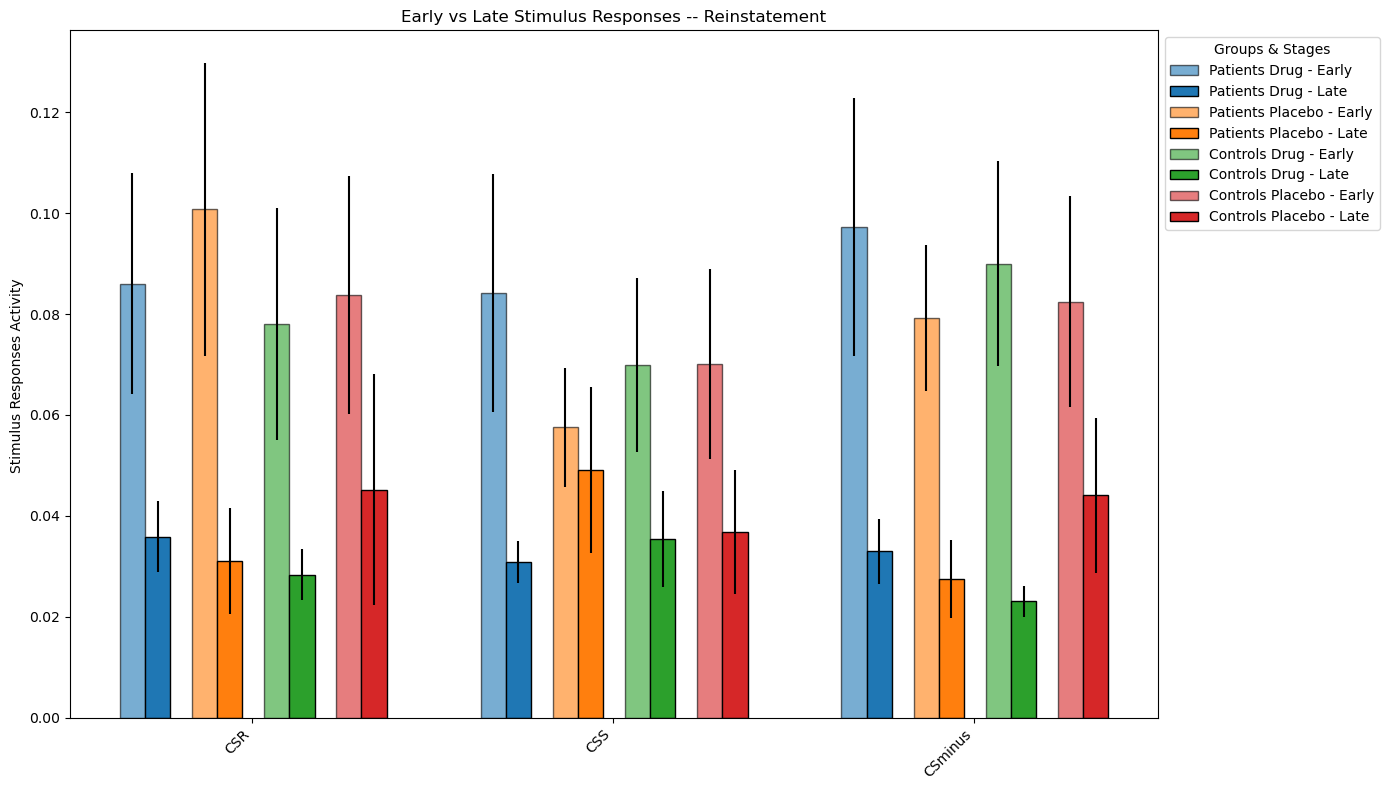

Statistical Test Results:


,Comparison,T-Stat,P-Value
0,patients_drug Early vs Late (CSR),2.982987,0.006133
1,patients_placebo Early vs Late (CSR),2.948044,0.007680
2,controls_drug Early vs Late (CSR),2.153339,0.042013
3,controls_placebo Early vs Late (CSR),1.512791,0.141951
4,Patients Drug vs Placebo (CSR Early),-0.412869,0.681580
5,Patients vs Controls Drug (CSR Early),0.252599,0.801635
6,Patients vs Controls Placebo (CSR Early),0.067871,0.946143
7,Patients Drug vs Placebo (CSR Late),0.394499,0.694997
8,Patients vs Controls Drug (CSR Late),0.850980,0.398920
9,Patients vs Controls Placebo (CSR Late),-0.381424,0.704414


In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            for stage in ['early', 'late']:
                mean, se = all_stats[f'{stimulus}_{group}_{stage}']
                data.append({
                    'Stimulus': stimulus,
                    'Group': group.replace('_', ' ').title(),
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to perform post-hoc t-tests using raw data in all_data
def calculate_posthoc_tests(all_data):
    results = []
    
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            early_values = all_data[f'{stimulus}_{group}_early']
            late_values = all_data[f'{stimulus}_{group}_late']
            t_stat, p_value = ttest_rel(early_values, late_values) if len(early_values) > 1 and len(late_values) > 1 else (np.nan, np.nan)
            results.append({'Comparison': f'{group} Early vs Late ({stimulus})', 'T-Stat': t_stat, 'P-Value': p_value})
        
        for stage in ['early', 'late']:
            patient_drug = all_data[f'{stimulus}_patients_drug_{stage}']
            patient_placebo = all_data[f'{stimulus}_patients_placebo_{stage}']
            control_drug = all_data[f'{stimulus}_controls_drug_{stage}']
            control_placebo = all_data[f'{stimulus}_controls_placebo_{stage}']

            for group_pair, (data1, data2) in {
                'Patients Drug vs Placebo': (patient_drug, patient_placebo),
                'Patients vs Controls Drug': (patient_drug, control_drug),
                'Patients vs Controls Placebo': (patient_drug, control_placebo)
            }.items():
                t_stat, p_value = ttest_ind(data1, data2) if len(data1) > 1 and len(data2) > 1 else (np.nan, np.nan)
                results.append({'Comparison': f'{group_pair} ({stimulus} {stage.capitalize()})', 'T-Stat': t_stat, 'P-Value': p_value})
    
    return pd.DataFrame(results)

# Function to plot a multibar plot with error bars and significant annotations
def plot_multibar_with_error_bars(all_stats, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)  # Use all_data for post-hoc tests
    
    plt.figure(figsize=(14, 8))
    stimuli = df['Stimulus'].unique()
    groups = df['Group'].unique()
    width = 0.35  # Width of each bar
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each group

    # Plotting for each stimulus category
    for i, stimulus in enumerate(stimuli):
        x_pos = np.arange(len(groups)) + i * (len(groups) + 1)  # Set x position for each stimulus group
        
        for j, group in enumerate(groups):
            group_data_early = df[(df['Stimulus'] == stimulus) & (df['Group'] == group) & (df['Stage'] == 'Early')]
            group_data_late = df[(df['Stimulus'] == stimulus) & (df['Group'] == group) & (df['Stage'] == 'Late')]
            
            # Plot bars with error bars
            plt.bar(x_pos[j] - width/2, group_data_early['Mean'].values[0], yerr=group_data_early['SE'].values[0],
                    width=width, color=colors[j], alpha=0.6, edgecolor='black', label=f'{group} - Early' if i == 0 else "")
            plt.bar(x_pos[j] + width/2, group_data_late['Mean'].values[0], yerr=group_data_late['SE'].values[0],
                    width=width, color=colors[j], alpha=1, edgecolor='black', label=f'{group} - Late' if i == 0 else "")

            # Annotate significant differences
            comparison_early_late = f'{group.replace(" ", "_").lower()}_early_vs_late_{stimulus.lower()}'
            if not stats_df[stats_df['Comparison'] == comparison_early_late].empty:
                p_value = stats_df[stats_df['Comparison'] == comparison_early_late]['P-Value'].values[0]
                if p_value < 0.05:
                    y = max(group_data_early['Mean'].values[0] + group_data_early['SE'].values[0],
                            group_data_late['Mean'].values[0] + group_data_late['SE'].values[0]) + 0.1
                    plt.plot([x_pos[j] - width/2, x_pos[j] + width/2], [y, y], color='black')
                    plt.text(x_pos[j], y + 0.05, '*', ha='center', va='bottom', color='black')

    # Customize the plot
    tick_pos = [x + width * 4.25 for x in range(0, len(stimuli) * (len(groups) + 1), len(groups) + 1)]
    plt.xticks(tick_pos, stimuli, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity ')
    plt.title(f'Early vs Late {title} -- Reinstatement')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout()
    plt.show()

    # Display statistical table below the plot
    print("Statistical Test Results:")
    display(stats_df)

# Plot combined multibar plot for all stimulus categories
title = 'Stimulus Responses'
plot_multibar_with_error_bars(all_stats, title)


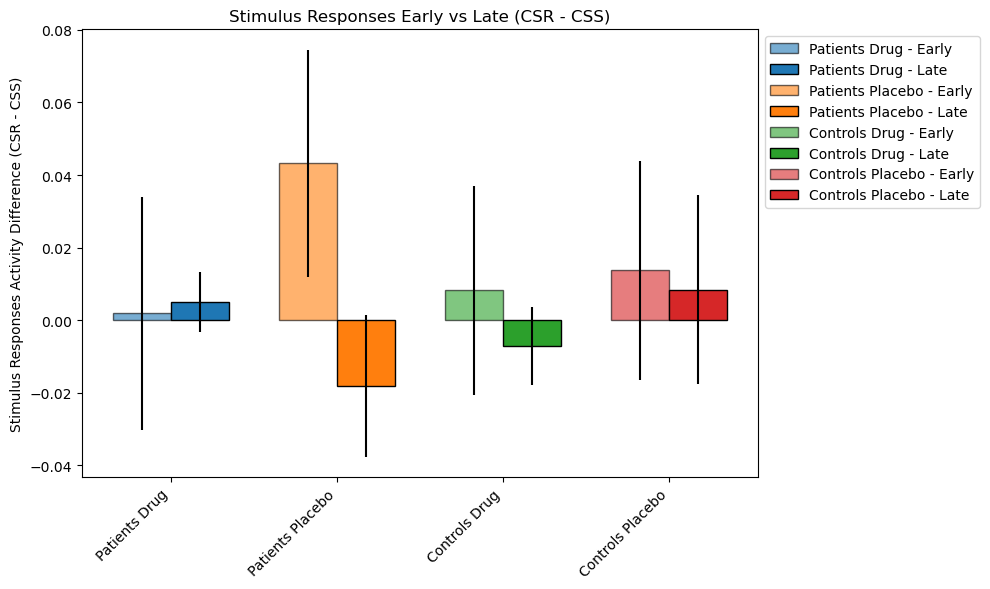

Within-Group Early vs Late Statistical Test Results:


,Comparison,T-Stat,P-Value
0,patients_drug Early vs Late (CSR - CSS),-0.260878,0.796242
1,patients_placebo Early vs Late (CSR - CSS),2.054635,0.052568
2,controls_drug Early vs Late (CSR - CSS),0.875420,0.390396
3,controls_placebo Early vs Late (CSR - CSS),0.338243,0.737796



Drug vs Placebo Statistical Test Results:


,Comparison,T-Stat,P-Value
0,Patients Drug vs Placebo - Early (CSR - CSS),-1.805840,0.080107
1,Controls Drug vs Placebo - Early (CSR - CSS),-0.363329,0.718291
2,Patients Drug vs Placebo - Late (CSR - CSS),1.293368,0.206381
3,Controls Drug vs Placebo - Late (CSR - CSS),-1.040920,0.303054


In [399]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind

# Function to prepare data specifically for CSR - CSS comparisons
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
        for stage in ['early', 'late']:
            mean_csr, se_csr = all_stats[f'CSR_{group}_{stage}']
            mean_css, se_css = all_stats[f'CSS_{group}_{stage}']
            mean_diff = mean_csr - mean_css
            se_diff = np.sqrt(se_csr**2 + se_css**2)  # Assuming independence for SEs
            data.append({
                'Group': group.replace('_', ' ').title(),
                'Stage': 'Early' if stage == 'early' else 'Late',
                'Mean Difference (CSR - CSS)': mean_diff,
                'SE Difference': se_diff
            })
    return pd.DataFrame(data)

# Function to perform post-hoc t-tests for CSR - CSS differences
def calculate_posthoc_tests(all_data):
    results = []
    for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
        early_values_csr = all_data[f'CSR_{group}_early']
        early_values_css = all_data[f'CSS_{group}_early']
        late_values_csr = all_data[f'CSR_{group}_late']
        late_values_css = all_data[f'CSS_{group}_late']
        
        # Calculate CSR - CSS differences
        early_diff = np.array(early_values_csr) - np.array(early_values_css)
        late_diff = np.array(late_values_csr) - np.array(late_values_css)
        
        # Perform paired t-tests for early vs late within each group
        t_stat, p_value = ttest_rel(early_diff, late_diff) if len(early_diff) > 1 and len(late_diff) > 1 else (np.nan, np.nan)
        results.append({'Comparison': f'{group} Early vs Late (CSR - CSS)', 'T-Stat': t_stat, 'P-Value': p_value})
    
    return pd.DataFrame(results)

# Function to perform post-hoc t-tests between drug and placebo within each group
def calculate_drug_placebo_tests(all_data):
    results = []
    for stage in ['early', 'late']:
        # Patients: Drug vs Placebo
        patients_drug = np.array(all_data[f'CSR_patients_drug_{stage}']) - np.array(all_data[f'CSS_patients_drug_{stage}'])
        patients_placebo = np.array(all_data[f'CSR_patients_placebo_{stage}']) - np.array(all_data[f'CSS_patients_placebo_{stage}'])
        t_stat, p_value = ttest_ind(patients_drug, patients_placebo, equal_var=False)
        results.append({'Comparison': f'Patients Drug vs Placebo - {stage.title()} (CSR - CSS)', 'T-Stat': t_stat, 'P-Value': p_value})
        
        # Controls: Drug vs Placebo
        controls_drug = np.array(all_data[f'CSR_controls_drug_{stage}']) - np.array(all_data[f'CSS_controls_drug_{stage}'])
        controls_placebo = np.array(all_data[f'CSR_controls_placebo_{stage}']) - np.array(all_data[f'CSS_controls_placebo_{stage}'])
        t_stat, p_value = ttest_ind(controls_drug, controls_placebo, equal_var=False)
        results.append({'Comparison': f'Controls Drug vs Placebo - {stage.title()} (CSR - CSS)', 'T-Stat': t_stat, 'P-Value': p_value})
    
    return pd.DataFrame(results)

# Function to plot multibar plot for CSR - CSS differences with error bars
def plot_multibar_with_error_bars(all_stats, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)  # Use all_data for post-hoc tests
    drug_placebo_df = calculate_drug_placebo_tests(all_data)  # Additional post-hoc tests for drug vs placebo
    
    plt.figure(figsize=(10, 6))
    groups = df['Group'].unique()
    width = 0.35
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    # Plotting CSR - CSS differences for each group and stage
    for j, group in enumerate(groups):
        group_data_early = df[(df['Group'] == group) & (df['Stage'] == 'Early')]
        group_data_late = df[(df['Group'] == group) & (df['Stage'] == 'Late')]
        
        # Plot bars with error bars
        plt.bar(j - width/2, group_data_early['Mean Difference (CSR - CSS)'].values[0],
                yerr=group_data_early['SE Difference'].values[0], width=width, color=colors[j], alpha=0.6,
                edgecolor='black', label=f'{group} - Early')
        plt.bar(j + width/2, group_data_late['Mean Difference (CSR - CSS)'].values[0],
                yerr=group_data_late['SE Difference'].values[0], width=width, color=colors[j], alpha=1,
                edgecolor='black', label=f'{group} - Late')
        
        # Annotate significant differences
        comparison = f'{group.replace(" ", "_").lower()}_early_vs_late'
        if not stats_df[stats_df['Comparison'] == comparison].empty:
            p_value = stats_df[stats_df['Comparison'] == comparison]['P-Value'].values[0]
            if p_value < 0.05:
                y = max(group_data_early['Mean Difference (CSR - CSS)'].values[0] + group_data_early['SE Difference'].values[0],
                        group_data_late['Mean Difference (CSR - CSS)'].values[0] + group_data_late['SE Difference'].values[0]) + 0.1
                plt.plot([j - width/2, j + width/2], [y, y], color='black')
                plt.text(j, y + 0.05, '*', ha='center', va='bottom', color='black')
    
    # Customize the plot 
    plt.xticks(range(len(groups)), groups, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity Difference (CSR - CSS)')
    plt.title(f'{title} Early vs Late (CSR - CSS)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()
    
    # Display statistical tables
    print("Within-Group Early vs Late Statistical Test Results:")
    display(stats_df)
    
    print("\nDrug vs Placebo Statistical Test Results:")
    display(drug_placebo_df)

# Run the plot for CSR - CSS differences
title = 'Stimulus Responses'
plot_multibar_with_error_bars(all_stats, title)


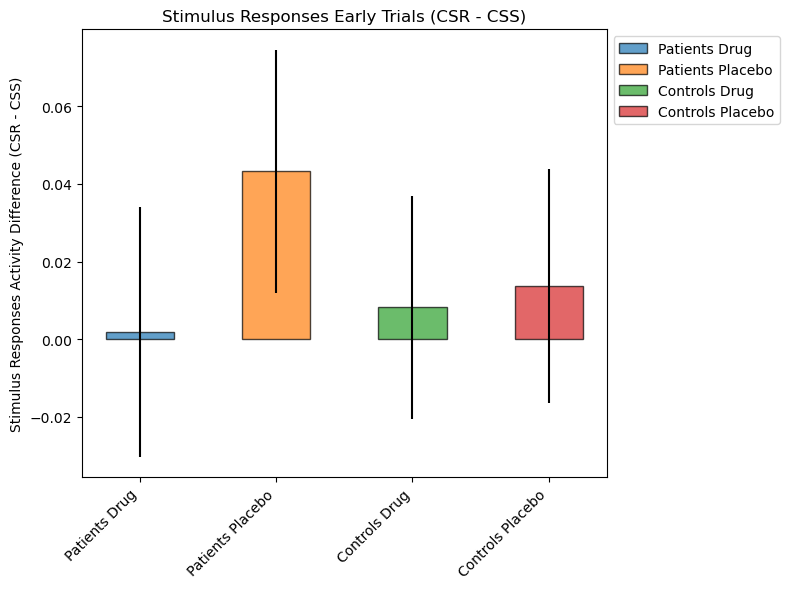

Within-Group Early Trial Statistical Test Results:


,Comparison,T-Stat,P-Value
0,patients_drug CSR vs CSS (Early),0.175203,0.862277
1,patients_placebo CSR vs CSS (Early),2.149456,0.043408
2,controls_drug CSR vs CSS (Early),0.631972,0.533637
3,controls_placebo CSR vs CSS (Early),1.682054,0.104090
4,Patients Drug vs Placebo (Early),-1.805840,0.080107
5,Controls Drug vs Placebo (Early),-0.363329,0.718291


In [401]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind

# Function to prepare data specifically for CSR - CSS comparisons in early trials only
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
        # Only include early trials
        stage = 'early'
        mean_csr, se_csr = all_stats[f'CSR_{group}_{stage}']
        mean_css, se_css = all_stats[f'CSS_{group}_{stage}']
        mean_diff = mean_csr - mean_css
        se_diff = np.sqrt(se_csr**2 + se_css**2)  # Assuming independence for SEs
        data.append({
            'Group': group.replace('_', ' ').title(),
            'Stage': 'Early',
            'Mean Difference (CSR - CSS)': mean_diff,
            'SE Difference': se_diff
        })
    return pd.DataFrame(data)

# Function to perform post-hoc t-tests for CSR - CSS differences and drug vs. placebo in early trials
def calculate_posthoc_tests(all_data):
    results = []
    for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
        early_values_csr = all_data[f'CSR_{group}_early']
        early_values_css = all_data[f'CSS_{group}_early']
        
        # Calculate CSR - CSS differences for early trials
        early_diff = np.array(early_values_csr) - np.array(early_values_css)
        
        # Paired t-test between CSR and CSS for early trials
        t_stat, p_value = ttest_rel(early_values_csr, early_values_css) if len(early_values_csr) > 1 else (np.nan, np.nan)
        results.append({'Comparison': f'{group} CSR vs CSS (Early)', 'T-Stat': t_stat, 'P-Value': p_value})
    
    # Drug vs. Placebo comparisons for each group
    patients_drug = np.array(all_data['CSR_patients_drug_early']) - np.array(all_data['CSS_patients_drug_early'])
    patients_placebo = np.array(all_data['CSR_patients_placebo_early']) - np.array(all_data['CSS_patients_placebo_early'])
    controls_drug = np.array(all_data['CSR_controls_drug_early']) - np.array(all_data['CSS_controls_drug_early'])
    controls_placebo = np.array(all_data['CSR_controls_placebo_early']) - np.array(all_data['CSS_controls_placebo_early'])
    
    # Independent t-tests for drug vs placebo
    t_stat, p_value = ttest_ind(patients_drug, patients_placebo, equal_var=False)
    results.append({'Comparison': 'Patients Drug vs Placebo (Early)', 'T-Stat': t_stat, 'P-Value': p_value})
    
    t_stat, p_value = ttest_ind(controls_drug, controls_placebo, equal_var=False)
    results.append({'Comparison': 'Controls Drug vs Placebo (Early)', 'T-Stat': t_stat, 'P-Value': p_value})
    
    return pd.DataFrame(results)

# Function to plot multibar plot for CSR - CSS differences in early trials only with error bars
def plot_multibar_with_error_bars(all_stats, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)  # Use all_data for post-hoc tests
    
    plt.figure(figsize=(8, 6))
    groups = df['Group'].unique()
    width = 0.2  # Make bars narrower to fit closer together
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    # Plotting CSR - CSS differences for each group in early trials only
    for j, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot bar with error bars for early trials
        plt.bar(j * width * 2, group_data['Mean Difference (CSR - CSS)'].values[0],
                yerr=group_data['SE Difference'].values[0], width=width, color=colors[j], alpha=0.7,
                edgecolor='black', label=group)
        
        # Annotate significant differences within group (CSR vs CSS)
        comparison = f'{group.replace(" ", "_").lower()}_csr_vs_css_early'
        if not stats_df[stats_df['Comparison'] == f'{group} CSR vs CSS (Early)'].empty:
            p_value = stats_df[stats_df['Comparison'] == f'{group} CSR vs CSS (Early)']['P-Value'].values[0]
            if p_value < 0.05:
                y = group_data['Mean Difference (CSR - CSS)'].values[0] + group_data['SE Difference'].values[0] + 0.1
                plt.text(j * width * 2, y, '*', ha='center', va='bottom', color='black')
    
    # Customize the plot
    plt.xticks([i * width * 2 for i in range(len(groups))], groups, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity Difference (CSR - CSS)')
    plt.title(f'{title} Early Trials (CSR - CSS)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()
    
    # Display statistical test results
    print("Within-Group Early Trial Statistical Test Results:")
    display(stats_df)

# Run the plot for CSR - CSS differences in early trials only
title = 'Stimulus Responses'
plot_multibar_with_error_bars(all_stats, title)


### Peak-base, z-scored SCR value

z-scoring on an individual level basis -- trial peak-base - mean(all 24 trials) / mean(all trial trials)  -- doesn't look correct 


#### Phase 1

In [184]:
import os
import pandas as pd
import numpy as np

# Set the working directory
path = '/Volumes/Seagate Desktop Drive/NARSAD/SCR'
os.chdir(path)

# Parameters
trialnumber = range(1, 25)  # Adjust to the first half of trials if needed
excludeparticipants = 1  # Set to 0 to include all participants
rejtrials_threshold = 24  # Adjust the threshold as needed

# Load the table
peakstatstable = pd.read_csv('peak_stats_table-phase1.csv')

# Extract unique participant IDs and trial types
participants = peakstatstable['sid'].unique()

# Add a group column based on participant IDs if needed
# This step assumes that participant IDs indicate their group. Adjust as necessary.
peakstatstable['group'] = np.where(peakstatstable['sid'].str.startswith('N1'), 'patient', 'control')  # Modify as needed

# Group data by participant
participant_groups = peakstatstable.groupby('sid')
dat = []

for participant_id in participants:
    data = participant_groups.get_group(participant_id)
    subject_data = {'subID': participant_id}

    # Process data if there are 24 trials
    if len(data) == 24:
        phase1_data = data[data['stNum'].isin(trialnumber)]

        # Rejected trials (based on "Publication recommendations for electrodermal measurements")
        rejTrials = phase1_data[phase1_data['phaBase2Peak'] < 0].index
        phase1_data.loc[rejTrials, 'phaBase2Peak'] = 0  # Mark non-response trials as 0

        subject_data['rejTrials1'] = len(rejTrials)

        # Calculate participant-wise average and standard deviation
        participant_mean = phase1_data['phaBase2Peak'].mean()
        participant_std = phase1_data['phaBase2Peak'].std()

        # Separate data by stim type
        stim_groups = phase1_data.groupby('stTy')

        try:
            # Z-score the phaBase2Peak values for each stimulus type
            for stim_type, stim_data in stim_groups:
                # Calculate z-scores based on participant's mean and std
                z_scores = (stim_data['phaBase2Peak'] - participant_mean) / participant_std
                
                # Store the mean and SE of z-scores with the new variable names
                if stim_type == 'CS+S':
                    subject_data['meanCSS1'] = z_scores.mean()
                    subject_data['seCSS1'] = z_scores.std() / np.sqrt(len(z_scores))
                    subject_data['nCSS1'] = len(z_scores)
                elif stim_type == 'CS+R':
                    subject_data['meanCSR1'] = z_scores.mean()
                    subject_data['seCSR1'] = z_scores.std() / np.sqrt(len(z_scores))
                    subject_data['nCSR1'] = len(z_scores)
                elif stim_type == 'CS-':
                    subject_data['meanCSminus1'] = z_scores.mean()
                    subject_data['seCSminus1'] = z_scores.std() / np.sqrt(len(z_scores))
                    subject_data['nCSminus1'] = len(z_scores)

        except KeyError:
            print(f"Missing stim type data for participant {participant_id}")

    dat.append(subject_data)

# Convert to a DataFrame if you need a structured output
dat_df = pd.DataFrame(dat)

print(dat_df)


    subID  rejTrials1  meanCSR1    seCSR1  nCSR1  meanCSS1    seCSS1  nCSS1  \
0    N101           4 -0.191597  0.201230      8  0.461885  0.549469      8   
1    N102           0 -0.488130  0.104743      8  0.488130  0.552979      8   
2    N103           1  0.086566  0.364331      8 -0.120133  0.294204      8   
3    N104           5 -0.321006  0.131551      8 -0.207710  0.213842      8   
4    N105           2 -0.392065  0.196368      8  0.208545  0.389419      8   
..    ...         ...       ...       ...    ...       ...       ...    ...   
99   N255           6 -0.337741  0.094990      8 -0.369404  0.086299      8   
100  N257           4  0.093319  0.490107      8 -0.118077  0.235745      8   
101  N258           0 -0.079173  0.421012      8  0.200262  0.390068      8   
102  N259           2  0.336829  0.523763      8 -0.007322  0.275650      8   
103  N260           1 -0.106682  0.246396      8  0.109453  0.421726      8   

     meanCSminus1  seCSminus1  nCSminus1  
0   -2.7

#### CSR, CSS kept separate 

In [185]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 1, 
    'meanCSS1': 2, 
    'meanCSminus1': 3
})

# Specify the model without intercept
model_formula = 'response ~ patient_group * stim_type + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.1637
Date:                Fri, 01 Nov 2024   Prob (F-statistic):              0.957
Time:                        12:42:04   Log-Likelihood:                -45.897
No. Observations:                 312   AIC:                             101.8
Df Residuals:                     307   BIC:                             120.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60532/4197659941.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


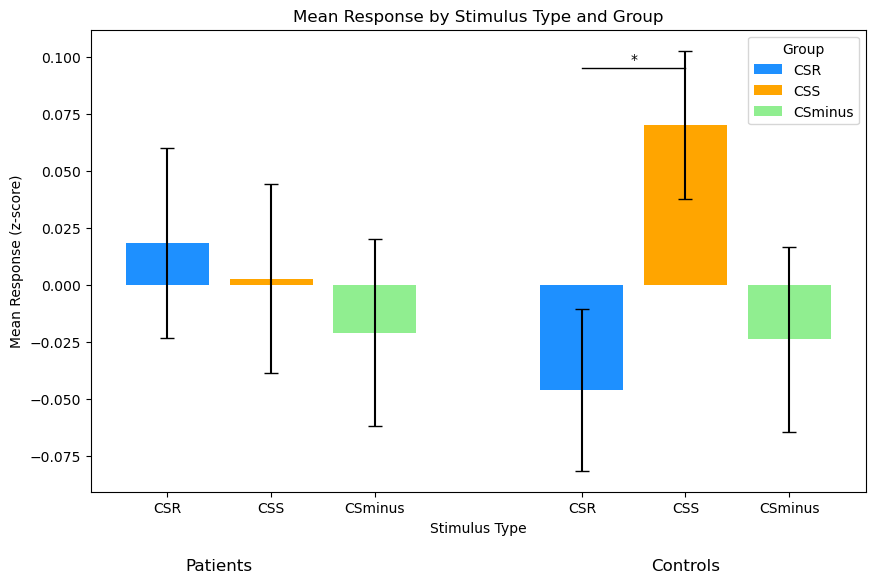

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 'CSR', 
    'meanCSS1': 'CSS', 
    'meanCSminus1': 'CSminus'
})

# Calculate means and errors
group_means = long_data.groupby(['patient_group', 'stim_type'])['response'].mean().reset_index()
group_sems = long_data.groupby(['patient_group', 'stim_type'])['response'].sem().reset_index()

# Set up custom x positions for the bars (grouped with a gap between patients and controls)
x_positions = {
    ('patient', 'CSR'): 0, ('patient', 'CSS'): 1, ('patient', 'CSminus'): 2,
    ('control', 'CSR'): 4, ('control', 'CSS'): 5, ('control', 'CSminus'): 6
}

# Map x positions to data
group_means['x'] = group_means.apply(lambda row: x_positions[(row['patient_group'], row['stim_type'])], axis=1)
group_sems['x'] = group_means['x']

# Define colors for each stimulus type
stimulus_colors = {
    'CSR': 'dodgerblue',
    'CSS': 'orange',
    'CSminus': 'lightgreen'
}

# Plot bar chart
plt.figure(figsize=(10, 6))

for group in ['patient', 'control']:
    for stim in ['CSR', 'CSS', 'CSminus']:
        group_data = group_means[(group_means['patient_group'] == group) & (group_means['stim_type'] == stim)]
        group_errors = group_sems[(group_sems['patient_group'] == group) & (group_sems['stim_type'] == stim)]
        plt.bar(group_data['x'], group_data['response'], 
                color=stimulus_colors[stim], 
                label=stim if group == 'patient' else "",  # Label only for patients
                yerr=group_errors['response'], capsize=5)

# Add significance markers
def add_significance_markers(ax, comparisons, y_offset=0.02, bar_height=0.02):
    for (group1, stim1), (group2, stim2) in comparisons:
        if group1 == group2:
            # Paired t-test within the same group
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_rel(data1['response'], data2['response'])
        else:
            # Independent t-test between groups
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group2) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_ind(data1['response'], data2['response'], equal_var=False)
        
        if result.pvalue < 0.05:  # Customize significance level if needed
            x1 = x_positions[(group1, stim1)]
            x2 = x_positions[(group2, stim2)]
            max_y = group_means['response'].max() + 0.025  # Adjust this if needed
            ax.plot([x1, x2], [max_y, max_y], 'k-', lw=1)
            ax.text((x1 + x2) / 2, max_y + 0.001, '*', ha='center', va='bottom')

# Define comparisons
comparisons = [
    (('patient', 'CSR'), ('patient', 'CSS')),   # Patient CSR vs CSS
    (('patient', 'CSR'), ('patient', 'CSminus')),  # Patient CSR vs CSminus
    (('patient', 'CSS'), ('patient', 'CSminus')),  # Patient CSS vs CSminus
    (('control', 'CSR'), ('control', 'CSS')),   # Control CSR vs CSS
    (('control', 'CSR'), ('control', 'CSminus')),  # Control CSR vs CSminus
    (('control', 'CSS'), ('control', 'CSminus')),  # Control CSS vs CSminus
    (('patient', 'CSR'), ('control', 'CSR')),    # Between-group CSR
    (('patient', 'CSS'), ('control', 'CSS')),    # Between-group CSS
    (('patient', 'CSminus'), ('control', 'CSminus')) # Between-group CSminus
]

add_significance_markers(plt.gca(), comparisons)
# Add x-axis labels to indicate groups
plt.text(0.5, -0.12, 'Patients', ha='center', va='top', fontsize=12)
plt.text(5, -0.12, 'Controls', ha='center', va='top', fontsize=12)

# Labeling and finalizing plot
plt.xticks([0, 1, 2, 4, 5, 6], ['CSR', 'CSS', 'CSminus', 'CSR', 'CSS', 'CSminus'])
plt.xlabel('Stimulus Type')
plt.ylabel('Mean Response (z-score)')
plt.title('Mean Response by Stimulus Type and Group')
plt.legend(title='Group')
plt.show()


#### CS+ vs CS- 

In [192]:
## treating CSR and CSS as the same categorical condition 

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)  # 1 for patient, 0 for control
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Combine CSR and CSS into a single variable called CS+
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 'CS+',  # Combine CSR
    'meanCSS1': 'CS+',  # Combine CSS
    'meanCSminus1': 'CSminus'  # Keep CSminus as is
})

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].astype('category')

# Specify the model without intercept
model_formula = 'response ~ patient_group * stim_type + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.2494
Date:                Fri, 01 Nov 2024   Prob (F-statistic):              0.910
Time:                        12:44:31   Log-Likelihood:                -45.723
No. Observations:                 312   AIC:                             101.4
Df Residuals:                     307   BIC:                             120.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

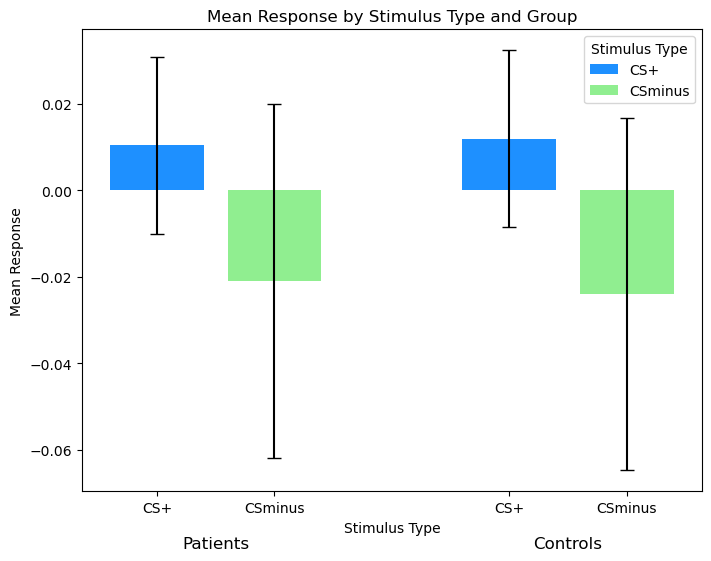

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Calculate the mean of CSR and CSS for each subject to create CS+
merged_data['CS_plus'] = merged_data[['meanCSR1', 'meanCSS1']].mean(axis=1)

# Reshape data to stack CS_plus and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group'], 
                    value_vars=['CS_plus', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'CS_plus': 'CS+', 
    'meanCSminus1': 'CSminus'
})

# Calculate means and errors
group_means = long_data.groupby(['patient_group', 'stim_type'])['response'].mean().reset_index()
group_sems = long_data.groupby(['patient_group', 'stim_type'])['response'].sem().reset_index()

# Set up custom x positions for the bars (grouped with a gap between patients and controls)
x_positions = {
    ('patient', 'CS+'): 0, ('patient', 'CSminus'): 1,
    ('control', 'CS+'): 3, ('control', 'CSminus'): 4
}

# Map x positions to data
group_means['x'] = group_means.apply(lambda row: x_positions[(row['patient_group'], row['stim_type'])], axis=1)
group_sems['x'] = group_means['x']

# Define colors for each stimulus type
stimulus_colors = {
    'CS+': 'dodgerblue',
    'CSminus': 'lightgreen'
}

# Plot bar chart
plt.figure(figsize=(8, 6))

for group in ['patient', 'control']:
    for stim in ['CS+', 'CSminus']:
        group_data = group_means[(group_means['patient_group'] == group) & (group_means['stim_type'] == stim)]
        group_errors = group_sems[(group_sems['patient_group'] == group) & (group_sems['stim_type'] == stim)]
        plt.bar(group_data['x'], group_data['response'], 
                color=stimulus_colors[stim], 
                label=stim if group == 'patient' else "",  # Label only for patients
                yerr=group_errors['response'], capsize=5)

# Add significance markers
def add_significance_markers(ax, comparisons, y_offset=0.02, bar_height=0.02):
    for (group1, stim1), (group2, stim2) in comparisons:
        if group1 == group2:
            # Paired t-test within the same group
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_rel(data1['response'], data2['response'])
        else:
            # Independent t-test between groups
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group2) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_ind(data1['response'], data2['response'], equal_var=False)
        
        if result.pvalue < 0.05:  # Customize significance level if needed
            x1 = x_positions[(group1, stim1)]
            x2 = x_positions[(group2, stim2)]
            max_y = group_means['response'].max() + 0.025  # Adjust this if needed
            ax.plot([x1, x2], [max_y, max_y], 'k-', lw=1)
            ax.text((x1 + x2) / 2, max_y + 0.001, '*', ha='center', va='bottom')

# Define comparisons
comparisons = [
    (('patient', 'CS+'), ('patient', 'CSminus')),   # Patient CS+ vs CSminus
    (('control', 'CS+'), ('control', 'CSminus')),   # Control CS+ vs CSminus
    (('patient', 'CS+'), ('control', 'CS+')),       # Between-group CS+
    (('patient', 'CSminus'), ('control', 'CSminus')) # Between-group CSminus
]

add_significance_markers(plt.gca(), comparisons)

# Labeling and finalizing plot
plt.xticks([0, 1, 3, 4], ['CS+', 'CSminus', 'CS+', 'CSminus'])
plt.xlabel('Stimulus Type')
plt.ylabel('Mean Response')
plt.title('Mean Response by Stimulus Type and Group')

# Add x-axis labels to indicate groups
plt.text(0.5, -0.08, 'Patients', ha='center', va='top', fontsize=12)
plt.text(3.5, -0.08, 'Controls', ha='center', va='top', fontsize=12)

plt.legend(title='Stimulus Type')
plt.show()


#### Phase 2/3 

In [411]:
import pandas as pd
import numpy as np

# Parameters to adjust:
trialnumber2_early = range(2, 13)  # Early trials for Phase 2 (2:12) - removed first CS- trial
trialnumber2_late = range(13, 25)   # Late trials for Phase 2 (13:24)
trialnumber3_early = range(26, 37)  # Early trials for Phase 3 (25:36) - removed first CS- trial
trialnumber3_late = range(37, 49)   # Late trials for Phase 3 (37:48)

excludeparticipants = 1  # Set to 0 to include all subjects; if set to 1, participants with rejected trials >= rejtrials_threshold are excluded
rejtrials_threshold = 24  # Threshold for trial rejection; adjust according to trial number

# Load data
peakstatstable = pd.read_csv('peak_stats_table-phase2.3.csv')
participants = peakstatstable['sid'].unique()
trial_types = peakstatstable['stTy'].unique()

# Separate data by participant, phase, and stim type
grouped_data = peakstatstable.groupby('sid')
dat = []

for participant in participants:
    data = grouped_data.get_group(participant)
    participant_data = {'subID': participant}

    # Ensuring consistent data structure
    if data.shape[0] == 48:
        
        # Phase 2 processing: stims numbered in trialnumber2
        phase2_data = data[data['stNum'].isin(range(1, 25))]
        rejTrials = phase2_data[phase2_data['phaBase2Peak'] < 0.02].index
        phase2_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials2'] = len(rejTrials)

        # Separate out stim types for early trials
        phase2_early_data = phase2_data[phase2_data['stNum'].isin(trialnumber2_early)]
        data2_early = {key: value for key, value in phase2_early_data.groupby('stTy')}
        
        # Calculate means and SE for early trials
        try:
            participant_data['meanCSS2_early'] = data2_early['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS2_early'] = data2_early['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data2_early['CS+S']))
            participant_data['nCSS2_early'] = len(data2_early['CS+S'])
            participant_data['meanCSR2_early'] = data2_early['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR2_early'] = data2_early['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data2_early['CS+R']))
            participant_data['nCSR2_early'] = len(data2_early['CS+R'])
            participant_data['meanCSminus2_early'] = data2_early['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus2_early'] = data2_early['CS-']['phaBase2Peak'].std() / np.sqrt(len(data2_early['CS-']))
            participant_data['nCSminus2_early'] = len(data2_early['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 2 early trials.")

        # Separate out stim types for late trials
        phase2_late_data = phase2_data[phase2_data['stNum'].isin(trialnumber2_late)]
        data2_late = {key: value for key, value in phase2_late_data.groupby('stTy')}
        
        # Calculate means and SE for late trials
        try:
            participant_data['meanCSS2_late'] = data2_late['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS2_late'] = data2_late['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data2_late['CS+S']))
            participant_data['nCSS2_late'] = len(data2_late['CS+S'])
            participant_data['meanCSR2_late'] = data2_late['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR2_late'] = data2_late['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data2_late['CS+R']))
            participant_data['nCSR2_late'] = len(data2_late['CS+R'])
            participant_data['meanCSminus2_late'] = data2_late['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus2_late'] = data2_late['CS-']['phaBase2Peak'].std() / np.sqrt(len(data2_late['CS-']))
            participant_data['nCSminus2_late'] = len(data2_late['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 2 late trials.")

        # Phase 3 processing: stims numbered in trialnumber3
        phase3_data = data[data['stNum'].isin(range(25, 49))]
        rejTrials = phase3_data[phase3_data['phaBase2Peak'] < 0.02].index
        phase3_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials3'] = len(rejTrials)

        # Separate out stim types for early trials
        phase3_early_data = phase3_data[phase3_data['stNum'].isin(trialnumber3_early)]
        data3_early = {key: value for key, value in phase3_early_data.groupby('stTy')}
        
        # Calculate means and SE for early trials
        try:
            participant_data['meanCSS3_early'] = data3_early['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS3_early'] = data3_early['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data3_early['CS+S']))
            participant_data['nCSS3_early'] = len(data3_early['CS+S'])
            participant_data['meanCSR3_early'] = data3_early['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR3_early'] = data3_early['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data3_early['CS+R']))
            participant_data['nCSR3_early'] = len(data3_early['CS+R'])
            participant_data['meanCSminus3_early'] = data3_early['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus3_early'] = data3_early['CS-']['phaBase2Peak'].std() / np.sqrt(len(data3_early['CS-']))
            participant_data['nCSminus3_early'] = len(data3_early['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 3 early trials.")

        # Separate out stim types for late trials
        phase3_late_data = phase3_data[phase3_data['stNum'].isin(trialnumber3_late)]
        data3_late = {key: value for key, value in phase3_late_data.groupby('stTy')}
        
        # Calculate means and SE for late trials
        try:
            participant_data['meanCSS3_late'] = data3_late['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS3_late'] = data3_late['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data3_late['CS+S']))
            participant_data['nCSS3_late'] = len(data3_late['CS+S'])
            participant_data['meanCSR3_late'] = data3_late['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR3_late'] = data3_late['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data3_late['CS+R']))
            participant_data['nCSR3_late'] = len(data3_late['CS+R'])
            participant_data['meanCSminus3_late'] = data3_late['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus3_late'] = data3_late['CS-']['phaBase2Peak'].std() / np.sqrt(len(data3_late['CS-']))
            participant_data['nCSminus3_late'] = len(data3_late['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 3 late trials.")

    # Add participant data to the main list
    dat.append(participant_data)


# Convert dat list to a DataFrame for easier viewing and export
dat_df = pd.DataFrame(dat)

if exclude_participants == 1:
    dat_df = dat_df[dat_df['rejTrials2'] < 24]

print(dat_df)


    subID  rejTrials2  meanCSS2_early  seCSS2_early  nCSS2_early  \
0    N101           3        0.017800      0.004499            5   
1    N103           4        0.035667      0.005783            3   
2    N104           4        0.014333      0.007172            3   
3    N105           5        0.025333      0.000882            3   
4    N106           0        0.025000      0.002000            3   
..    ...         ...             ...           ...          ...   
96   N255           0        0.031667      0.002404            3   
97   N257           3        0.024333      0.000333            3   
98   N258           0        0.030667      0.001453            3   
99   N259           0        0.030667      0.000333            3   
100  N260          11        0.027667      0.017477            3   

     meanCSR2_early  seCSR2_early  nCSR2_early  meanCSminus2_early  \
0          0.053333      0.025314            3            0.024333   
1          0.022000      0.022000          

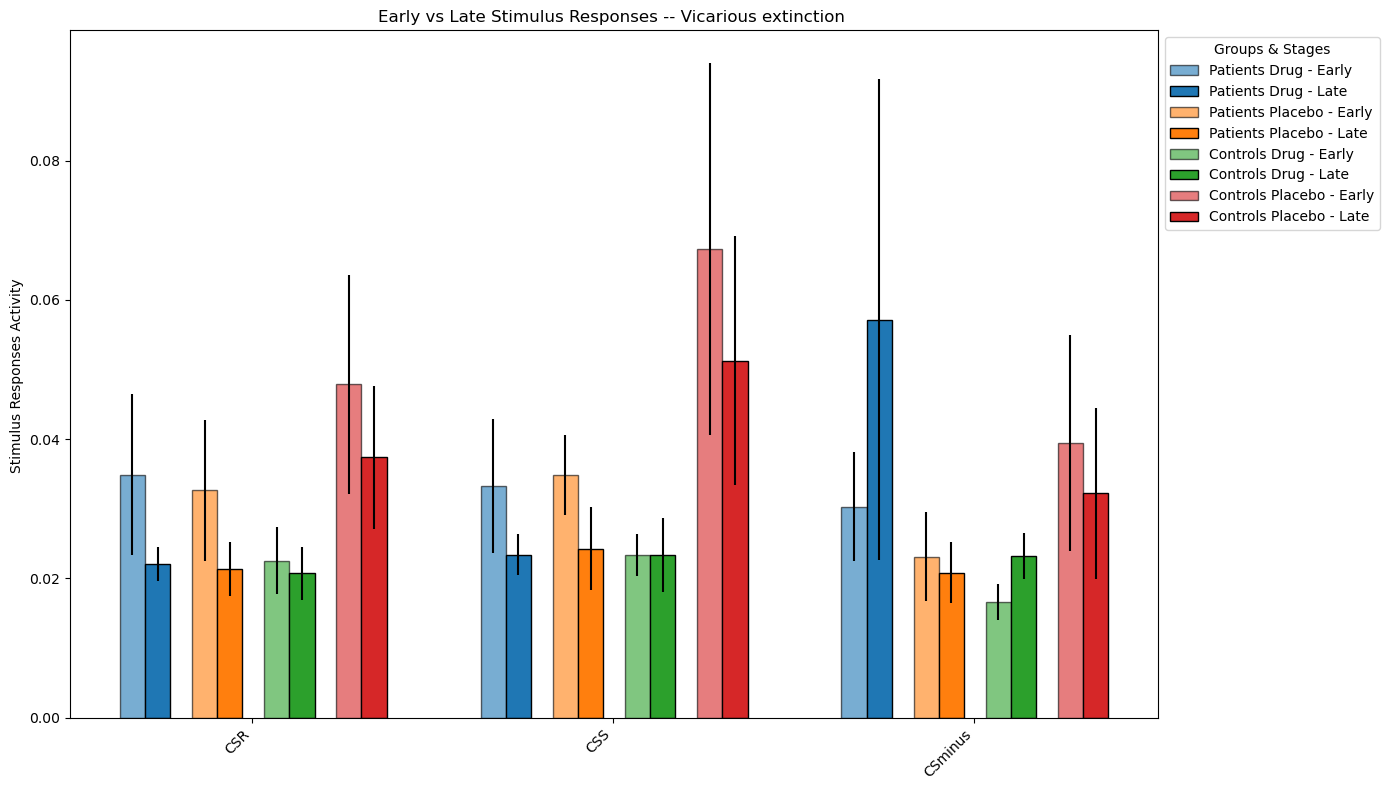

Statistical Test Results:


,Comparison,T-Stat,P-Value
0,patients_drug Early vs Late (CSR),1.069771,0.294554
1,patients_placebo Early vs Late (CSR),1.375830,0.184087
2,controls_drug Early vs Late (CSR),0.423371,0.676135
3,controls_placebo Early vs Late (CSR),1.286826,0.209943
4,Patients Drug vs Placebo (CSR Early),0.143176,0.886776
5,Control Drug vs Placebo (CSR Early),-1.454085,0.152569
6,Patients vs Controls Drug (CSR Early),0.932373,0.355810
7,Patients vs Controls Placebo (CSR Early),-0.768439,0.446240
8,Patients Drug vs Placebo (CSR Late),0.160721,0.873017
9,Control Drug vs Placebo (CSR Late),-1.443332,0.155560


### All 3 phases in 1 figure 

participants combined (patients + controls; just placebo condition )

In [132]:
import os

path = '/Volumes/Seagate Desktop Drive/NARSAD/SCR'
os.chdir(path)

import pandas as pd
import numpy as np

# Parameters
trialnumber = range(1, 13)  # Can adjust to first half of trials: range(1, 13)
excludeparticipants = 1  # Set to 0 to include all participants
rejtrials_threshold = 24  # Adjust the threshold as needed

# Load the table
peakstatstable = pd.read_csv('peak_stats_table-phase1.csv')

# Extract unique participant IDs and trial types
participants = peakstatstable['sid'].unique()
trial_types = peakstatstable['stTy'].unique()

# Group data by participant
participant_groups = peakstatstable.groupby('sid')
dat = []

for participant_id in participants:
    data = participant_groups.get_group(participant_id)
    subject_data = {'subID': participant_id}

    # Process data if there are 24 trials
    if len(data) == 24:
        phase1_data = data[data['stNum'].isin(trialnumber)]

        # Rejected trials (based on "Publication recommendations for electrodermal measurements")
        rejTrials = phase1_data[phase1_data['phaBase2Peak'] < 0].index
        phase1_data.loc[rejTrials, 'phaBase2Peak'] = 0  # Mark non-response trials as 0

        subject_data['rejTrials1'] = len(rejTrials)

        # Separate data by stim type
        stim_groups = phase1_data.groupby('stTy')

        try:
            # Calculate mean, SE, and count for CSS, CSR, and CS-
            css_data = stim_groups.get_group('CS+S')
            subject_data['meanCSS1'] = css_data['phaBase2Peak'].mean()
            subject_data['seCSS1'] = css_data['phaBase2Peak'].std() / np.sqrt(len(css_data))
            subject_data['nCSS1'] = len(css_data)

            csr_data = stim_groups.get_group('CS+R')
            subject_data['meanCSR1'] = csr_data['phaBase2Peak'].mean()
            subject_data['seCSR1'] = csr_data['phaBase2Peak'].std() / np.sqrt(len(css_data))
            subject_data['nCSR1'] = len(csr_data)

            csminus_data = stim_groups.get_group('CS-')
            subject_data['meanCSminus1'] = csminus_data['phaBase2Peak'].mean()
            subject_data['seCSminus1'] = csminus_data['phaBase2Peak'].std() / np.sqrt(len(css_data))
            subject_data['nCSminus1'] = len(csminus_data)

        except KeyError:
            print(f"Missing stim type data for participant {participant_id}")
        
    dat.append(subject_data)

# Convert to a DataFrame if you need a structured output
dat_df1 = pd.DataFrame(dat)
print(dat_df1)


    subID  rejTrials1  meanCSS1    seCSS1  nCSS1  meanCSR1    seCSR1  nCSR1  \
0    N101           1   0.06800  0.033317      4   0.00550  0.004518      4   
1    N102           0   0.00275  0.002136      4   0.00075  0.000479      4   
2    N103           0   0.15100  0.008765      4   0.14000  0.053039      4   
3    N104           5   0.00050  0.000500      4   0.00075  0.000750      4   
4    N105           1   0.00825  0.002955      4   0.00125  0.001250      4   
..    ...         ...       ...       ...    ...       ...       ...    ...   
99   N255           5   0.00125  0.001250      4   0.00050  0.000500      4   
100  N257           1   0.05550  0.010037      4   0.08050  0.033310      4   
101  N258           0   0.04675  0.008499      4   0.04325  0.009707      4   
102  N259           0   0.02450  0.005694      4   0.02650  0.015113      4   
103  N260           0   0.11600  0.045067      4   0.09975  0.016080      4   

     meanCSminus1  seCSminus1  nCSminus1  
0       

In [133]:
import pandas as pd
import numpy as np

# Parameters to adjust:
trialnumber2 = range(1, 25)  # Adjust this range to analyze specific trials (e.g., first half = range(1, 13))
trialnumber3 = range(25, 49) # Adjust this range for phase 3 analysis (e.g., range(25, 37) for first half)

excludeparticipants = 1  # Set to 0 to include all subjects; if set to 1, participants with rejected trials >= rejtrials_threshold are excluded
rejtrials_threshold = 24  # Threshold for trial rejection; adjust according to trial number

# Load data
peakstatstable = pd.read_csv('peak_stats_table-phase2.3.csv')
participants = peakstatstable['sid'].unique()
trial_types = peakstatstable['stTy'].unique()

# Separate data by participant, phase, and stim type
grouped_data = peakstatstable.groupby('sid')
dat = []

for participant in participants:
    data = grouped_data.get_group(participant)
    participant_data = {'subID': participant}

    # Ensuring consistent data structure
    if data.shape[0] == 48:
        
        # Phase 2 processing: stims numbered in trialnumber2
        phase2_data = data[data['stNum'].isin(trialnumber2)]
        rejTrials = phase2_data[phase2_data['phaBase2Peak'] < 0.02].index
        phase2_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials2'] = len(rejTrials)

        # Separate out stim types
        data2 = {key: value for key, value in phase2_data.groupby('stTy')}
        try:
            participant_data['meanCSS2'] = data2['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS2'] = data2['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data2['CS+S']))
            participant_data['nCSS2'] = len(data2['CS+S'])
            participant_data['meanCSR2'] = data2['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR2'] = data2['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data2['CS+R']))
            participant_data['nCSR2'] = len(data2['CS+R'])
            participant_data['meanCSminus2'] = data2['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus2'] = data2['CS-']['phaBase2Peak'].std() / np.sqrt(len(data2['CS-']))
            participant_data['nCSminus2'] = len(data2['CS-'])
        except KeyError:
            # Handle missing data if any stimulus type is not present for a participant
            print(f"Missing data for participant {participant} in Phase 2.")

        # Phase 3 processing: stims numbered in trialnumber3
        phase3_data = data[data['stNum'].isin(trialnumber3)]
        rejTrials = phase3_data[phase3_data['phaBase2Peak'] < 0.02].index
        phase3_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials3'] = len(rejTrials)

        # Separate out stim types
        data3 = {key: value for key, value in phase3_data.groupby('stTy')}
        try:
            participant_data['meanCSS3'] = data3['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS3'] = data3['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data3['CS+S']))
            participant_data['nCSS3'] = len(data3['CS+S'])
            participant_data['meanCSR3'] = data3['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR3'] = data3['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data3['CS+R']))
            participant_data['nCSR3'] = len(data3['CS+R'])
            participant_data['meanCSminus3'] = data3['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus3'] = data3['CS-']['phaBase2Peak'].std() / np.sqrt(len(data3['CS-']))
            participant_data['nCSminus3'] = len(data3['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 3.")

    # Add participant data to the main list
    dat.append(participant_data)

# Convert dat list to a DataFrame for easier viewing and export
dat_df = pd.DataFrame(dat)
print(dat_df)


    subID  rejTrials2  meanCSS2    seCSS2  nCSS2  meanCSR2    seCSR2  nCSR2  \
0    N101           3  0.020250  0.002957      8  0.031750  0.010813      8   
1    N103           4  0.032625  0.003105      8  0.024875  0.013315      8   
2    N104           4  0.016125  0.003543      8  0.016000  0.003505      8   
3    N105           5  0.018000  0.003973      8  0.020000  0.002928      8   
4    N106           0  0.025000  0.001000      8  0.027625  0.002104      8   
..    ...         ...       ...       ...    ...       ...       ...    ...   
96   N255           0  0.032500  0.002228      8  0.034625  0.004263      8   
97   N257           3  0.020500  0.002958      8  0.020125  0.002900      8   
98   N258           0  0.029625  0.000885      8  0.029500  0.000945      8   
99   N259           0  0.032250  0.000590      8  0.031375  0.000420      8   
100  N260          11  0.023125  0.009516      8  0.054875  0.022743      8   

     meanCSminus2  seCSminus2  ...  rejTrials3  mea

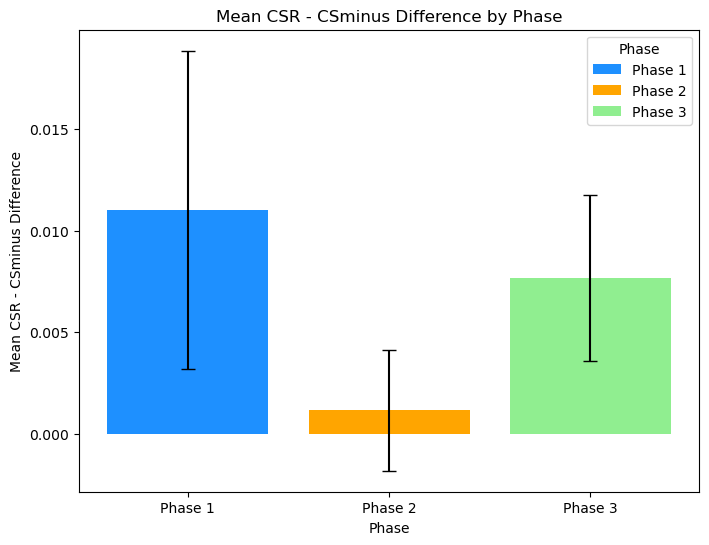

     Phase  t-statistic   p-value
0  Phase 1     1.407294  0.162441
1  Phase 2     0.384604  0.701348
2  Phase 3     1.869441  0.064487


In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming dat_df and dat_df1 have already been loaded and merged as shown previously
merged_data = pd.merge(dat_df, dat_df1, on='subID', how='inner')

# Calculate the meanCSR - meanCSminus for each phase
merged_data['diff_phase1'] = merged_data['meanCSR1'] - merged_data['meanCSminus1']
merged_data['diff_phase2'] = merged_data['meanCSR2'] - merged_data['meanCSminus2']
merged_data['diff_phase3'] = merged_data['meanCSR3'] - merged_data['meanCSminus3']

# Reshape data for plotting
long_data = pd.melt(merged_data,
                    id_vars=['subID'],
                    value_vars=['diff_phase1', 'diff_phase2', 'diff_phase3'],
                    var_name='phase',
                    value_name='mean_diff')

# Map phase to categorical labels for readability
long_data['phase'] = long_data['phase'].replace({
    'diff_phase1': 'Phase 1',
    'diff_phase2': 'Phase 2',
    'diff_phase3': 'Phase 3'
})

# Perform paired t-tests for CSR vs CSminus in each phase
t_test_results = []
for phase in [1, 2, 3]:
    csr_col = f'meanCSR{phase}'
    csminus_col = f'meanCSminus{phase}'
    t_stat, p_val = stats.ttest_rel(merged_data[csr_col], merged_data[csminus_col])
    t_test_results.append({
        'Phase': f'Phase {phase}',
        't-statistic': t_stat,
        'p-value': p_val
    })

# Create a DataFrame to display t-test results
t_test_df = pd.DataFrame(t_test_results)

# Calculate means and standard errors by phase
group_means = long_data.groupby(['phase'])['mean_diff'].mean().reset_index()
group_sems = long_data.groupby(['phase'])['mean_diff'].sem().reset_index()

# Set up colors for each phase
phase_colors = {
    'Phase 1': 'dodgerblue',
    'Phase 2': 'orange',
    'Phase 3': 'lightgreen'
}

# Plot bar chart
plt.figure(figsize=(8, 6))

for idx, phase in enumerate(['Phase 1', 'Phase 2', 'Phase 3']):
    # Get data for each phase
    phase_data = group_means[group_means['phase'] == phase]
    phase_errors = group_sems[group_sems['phase'] == phase]
    
    # Plot bar for each phase
    plt.bar(idx, phase_data['mean_diff'].values[0],
            color=phase_colors[phase],
            label=phase,
            yerr=phase_errors['mean_diff'].values[0], capsize=5)

    # # Add significance marker if p-value < 0.05
    # p_val = t_test_df.loc[idx, 'p-value']
    # if p_val < 0.05:
    #     max_y = phase_data['mean_diff'].values[0] + phase_errors['mean_diff'].values[0] + 0.05
    #     plt.text(idx, max_y, '*', ha='center', va='bottom', fontsize=14, color='black')

# Customize plot
plt.xticks([0, 1, 2], ['Phase 1', 'Phase 2', 'Phase 3'])
plt.xlabel('Phase')
plt.ylabel('Mean CSR - CSminus Difference')
plt.title('Mean CSR - CSminus Difference by Phase')
plt.legend(title='Phase')

# Display the 
filename='CSR-CS-_allphases.png'
plt.savefig(filename, format='png', dpi=300)
plt.show()

# Display the table of t-test results
print(t_test_df)


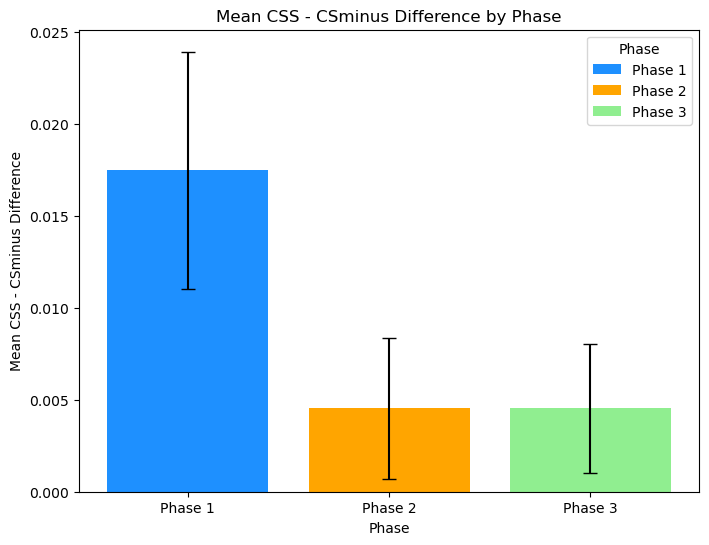

     Phase  t-statistic   p-value
0  Phase 1     2.710033  0.007918
1  Phase 2     1.185758  0.238528
2  Phase 3     1.297483  0.197450


In [137]:
# CSS vs CSminus

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming dat_df and dat_df1 have already been loaded and merged as shown previously
merged_data = pd.merge(dat_df, dat_df1, on='subID', how='inner')

# Calculate the meanCSR - meanCSminus for each phase
merged_data['diff_phase1'] = merged_data['meanCSS1'] - merged_data['meanCSminus1']
merged_data['diff_phase2'] = merged_data['meanCSS2'] - merged_data['meanCSminus2']
merged_data['diff_phase3'] = merged_data['meanCSS3'] - merged_data['meanCSminus3']

# Reshape data for plotting
long_data = pd.melt(merged_data,
                    id_vars=['subID'],
                    value_vars=['diff_phase1', 'diff_phase2', 'diff_phase3'],
                    var_name='phase',
                    value_name='mean_diff')

# Map phase to categorical labels for readability
long_data['phase'] = long_data['phase'].replace({
    'diff_phase1': 'Phase 1',
    'diff_phase2': 'Phase 2',
    'diff_phase3': 'Phase 3'
})

# Perform paired t-tests for CSR vs CSminus in each phase
t_test_results = []
for phase in [1, 2, 3]:
    csr_col = f'meanCSS{phase}'
    csminus_col = f'meanCSminus{phase}'
    t_stat, p_val = stats.ttest_rel(merged_data[csr_col], merged_data[csminus_col])
    t_test_results.append({
        'Phase': f'Phase {phase}',
        't-statistic': t_stat,
        'p-value': p_val
    })

# Create a DataFrame to display t-test results
t_test_df = pd.DataFrame(t_test_results)

# Calculate means and standard errors by phase
group_means = long_data.groupby(['phase'])['mean_diff'].mean().reset_index()
group_sems = long_data.groupby(['phase'])['mean_diff'].sem().reset_index()

# Set up colors for each phase
phase_colors = {
    'Phase 1': 'dodgerblue',
    'Phase 2': 'orange',
    'Phase 3': 'lightgreen'
}

# Plot bar chart
plt.figure(figsize=(8, 6))

for idx, phase in enumerate(['Phase 1', 'Phase 2', 'Phase 3']):
    # Get data for each phase
    phase_data = group_means[group_means['phase'] == phase]
    phase_errors = group_sems[group_sems['phase'] == phase]
    
    # Plot bar for each phase
    plt.bar(idx, phase_data['mean_diff'].values[0],
            color=phase_colors[phase],
            label=phase,
            yerr=phase_errors['mean_diff'].values[0], capsize=5)

    # # Add significance marker if p-value < 0.05
    # p_val = t_test_df.loc[idx, 'p-value']
    # if p_val < 0.05:
    #     max_y = phase_data['mean_diff'].values[0] + phase_errors['mean_diff'].values[0] + 0.05
    #     plt.text(idx, max_y, '*', ha='center', va='bottom', fontsize=14, color='black')

# Customize plot
plt.xticks([0, 1, 2], ['Phase 1', 'Phase 2', 'Phase 3'])
plt.xlabel('Phase')
plt.ylabel('Mean CSS - CSminus Difference')
plt.title('Mean CSS - CSminus Difference by Phase')
plt.legend(title='Phase')

# Display the plot
filename='CSS-CS-_allphases.png'
plt.savefig(filename, format='png', dpi=300)
plt.show()

# Display the table of t-test results
print(t_test_df)


In [138]:
# Assuming dat_df and dat_df1 have already been loaded and merged as shown previously
merged_data = pd.merge(dat_df, dat_df1, on='subID', how='inner')

# Calculate CSR - CSminus and CSS - CSminus for each phase
merged_data['CSR_minus_CSminus_phase1'] = merged_data['meanCSR1'] - merged_data['meanCSminus1']
merged_data['CSR_minus_CSminus_phase2'] = merged_data['meanCSR2'] - merged_data['meanCSminus2']
merged_data['CSR_minus_CSminus_phase3'] = merged_data['meanCSR3'] - merged_data['meanCSminus3']

merged_data['CSS_minus_CSminus_phase1'] = merged_data['meanCSS1'] - merged_data['meanCSminus1']
merged_data['CSS_minus_CSminus_phase2'] = merged_data['meanCSS2'] - merged_data['meanCSminus2']
merged_data['CSS_minus_CSminus_phase3'] = merged_data['meanCSS3'] - merged_data['meanCSminus3']


In [139]:
long_data

,subID,phase,mean_diff
0,N101,Phase 1,0.065250
1,N103,Phase 1,-0.002500
2,N104,Phase 1,-0.007250
3,N105,Phase 1,0.001000
4,N106,Phase 1,-0.001500
...,...,...,...
298,N255,Phase 3,0.001250
299,N257,Phase 3,-0.003125
300,N258,Phase 3,-0.001375
301,N259,Phase 3,-0.003125


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming dat_df and dat_df1 have already been loaded and merged as shown previously
merged_data = pd.merge(dat_df, dat_df1, on='subID', how='inner')

# Calculate CSR - CSminus and CSS - CSminus for each phase
merged_data['CSR_minus_CSminus_phase1'] = merged_data['meanCSR1'] - merged_data['meanCSminus1']
merged_data['CSR_minus_CSminus_phase2'] = merged_data['meanCSR2'] - merged_data['meanCSminus2']
merged_data['CSR_minus_CSminus_phase3'] = merged_data['meanCSR3'] - merged_data['meanCSminus3']

merged_data['CSS_minus_CSminus_phase1'] = merged_data['meanCSS1'] - merged_data['meanCSminus1']
merged_data['CSS_minus_CSminus_phase2'] = merged_data['meanCSS2'] - merged_data['meanCSminus2']
merged_data['CSS_minus_CSminus_phase3'] = merged_data['meanCSS3'] - merged_data['meanCSminus3']

# Merge with 'drug_order' to get drug condition information
merged_data = pd.merge(merged_data, drug_order, left_on='subID', right_on='subID', how='inner')

# Separate data for Phase 1 (all participants) and Phases 2 & 3 (placebo only)
phase1_data = merged_data[['subID', 'CSR_minus_CSminus_phase1', 'CSS_minus_CSminus_phase1']]
phase2_3_data = merged_data[merged_data['drug_condition'] == 0]

# Reshape Phase 1 and Phase 2-3 data for plotting
long_data_phase1 = pd.melt(phase1_data, id_vars=['subID'],
                           value_vars=['CSR_minus_CSminus_phase1', 'CSS_minus_CSminus_phase1'],
                           var_name='condition_phase', value_name='mean_diff')

long_data_phase2_3 = pd.melt(phase2_3_data, id_vars=['subID'],
                             value_vars=['CSR_minus_CSminus_phase2', 'CSR_minus_CSminus_phase3',
                                         'CSS_minus_CSminus_phase2', 'CSS_minus_CSminus_phase3'],
                             var_name='condition_phase', value_name='mean_diff')

# Concatenate Phase 1 and Phase 2-3 data
long_data = pd.concat([long_data_phase1, long_data_phase2_3])

# Separate condition and phase
long_data[['condition', 'phase']] = long_data['condition_phase'].str.extract(r'([^_]+)_minus_CSminus_(phase\d)')
long_data['phase'] = long_data['phase'].replace({
    'phase1': 'Phase 1',
    'phase2': 'Phase 2',
    'phase3': 'Phase 3'
})

# Perform paired t-tests for CSR - CSminus vs CSS - CSminus in each phase
t_test_results = []
for phase in [1, 2, 3]:
    csr_minus_csminus = merged_data[f'CSR_minus_CSminus_phase{phase}']
    css_minus_csminus = merged_data[f'CSS_minus_CSminus_phase{phase}']
    t_stat, p_val = stats.ttest_rel(csr_minus_csminus, css_minus_csminus)
    t_test_results.append({
        'Phase': f'Phase {phase}',
        'Comparison': 'CSR - CSminus vs CSS - CSminus',
        't-statistic': t_stat,
        'p-value': p_val
    })

# Create a DataFrame to display the t-test results
t_test_df = pd.DataFrame(t_test_results)

# Calculate means and standard errors by condition and phase
group_means = long_data.groupby(['condition', 'phase'])['mean_diff'].mean().reset_index()
group_sems = long_data.groupby(['condition', 'phase'])['mean_diff'].sem().reset_index()

# Set up colors for CSR and CSS
condition_colors = {
    'CSR': 'mediumturquoise',
    'CSS': 'tomato'
}

# Plot bar chart
plt.figure(figsize=(10, 6))
x = np.arange(3)  # Positions for the phases on the x-axis

# Width of bars
width = 0.35

# Plot bars for each condition
for idx, condition in enumerate(['CSR', 'CSS']):
    # Get data for each condition
    condition_means = group_means[group_means['condition'] == condition]
    condition_errors = group_sems[group_sems['condition'] == condition]
    
    # Plot bars next to each other within each phase
    plt.bar(x + idx * width, condition_means['mean_diff'], 
            width=width, 
            color=condition_colors[condition],
            label=f'{condition} - CSminus', 
            yerr=condition_errors['mean_diff'], capsize=5)

# Customize plot
plt.xticks(x + width / 2, ['Phase 1', 'Phase 2', 'Phase 3'])
plt.xlabel('Phase')
plt.ylabel('Mean Difference (CSR - CSminus / CSS - CSminus)')
plt.title('Mean CSR - CSminus and CSS - CSminus Difference by Phase')
plt.legend(title='Condition')

# Save and show plot
filename = 'CSR_CSS_CSminus_allphases_fixed.png'
plt.savefig(filename, format='png', dpi=300)
plt.show()

# Display the table of t-test results for CSR - CSminus vs CSS - CSminus
print("Paired t-test results for CSR - CSminus vs CSS - CSminus in each phase:")
print(t_test_df)


NameError: name 'phase2_3_data' is not defined

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming merged_data and drug_order are preloaded as before
merged_data = pd.merge(dat_df, dat_df1, on='subID', how='inner')

# Calculate CSplus (average of CSR and CSS) and CSplus - CSminus for Phase 1
merged_data['CSplus_phase1'] = (merged_data['meanCSR1'] + merged_data['meanCSS1']) / 2
merged_data['CSplus_minus_CSminus_phase1'] = merged_data['CSplus_phase1'] - merged_data['meanCSminus1']

# Calculate CSR - CSminus and CSS - CSminus for Phases 2 and 3 only
merged_data['CSR_minus_CSminus_phase2'] = merged_data['meanCSR2'] - merged_data['meanCSminus2']
merged_data['CSR_minus_CSminus_phase3'] = merged_data['meanCSR3'] - merged_data['meanCSminus3']
merged_data['CSS_minus_CSminus_phase2'] = merged_data['meanCSS2'] - merged_data['meanCSminus2']
merged_data['CSS_minus_CSminus_phase3'] = merged_data['meanCSS3'] - merged_data['meanCSminus3']

# Merge with drug_order to get drug condition information
merged_data = pd.merge(merged_data, drug_order, on='subID', how='inner')

# Separate data for Phase 1 (all participants) and Phases 2 & 3 (placebo only)
phase1_data = merged_data[['subID', 'CSplus_minus_CSminus_phase1']]
#phase2_3_data = merged_data[merged_data['drug_condition'] == 0]

# Reshape data for plotting
long_data_phase1 = pd.melt(phase1_data, id_vars=['subID'],
                           value_vars=['CSplus_minus_CSminus_phase1'],
                           var_name='condition_phase', value_name='mean_diff')

long_data_phase2_3 = pd.melt(phase2_3_data, id_vars=['subID'],
                             value_vars=['CSR_minus_CSminus_phase2', 'CSR_minus_CSminus_phase3',
                                         'CSS_minus_CSminus_phase2', 'CSS_minus_CSminus_phase3'],
                             var_name='condition_phase', value_name='mean_diff')

# Concatenate phase 1 and phase 2-3 data
long_data = pd.concat([long_data_phase1, long_data_phase2_3])

# Extract condition and phase
long_data[['condition', 'phase']] = long_data['condition_phase'].str.extract(r'([^_]+)_minus_CSminus_(phase\d)')
long_data['phase'] = long_data['phase'].replace({
    'phase1': 'Phase 1',
    'phase2': 'Phase 2',
    'phase3': 'Phase 3'
})

# Calculate means and standard errors by condition and phase
group_means = long_data.groupby(['condition', 'phase'])['mean_diff'].mean().reset_index()
group_sems = long_data.groupby(['condition', 'phase'])['mean_diff'].sem().reset_index()

# Set colors for CSplus, CSR, and CSS
condition_colors = {
    'CSplus': 'skyblue',
    'CSR': 'mediumturquoise',
    'CSS': 'tomato'
}

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Phases for x-axis positions
x = np.arange(3)

# Width of bars (narrower for reduced spacing)
width = 0.4  

# Plot Phase 1 bar for CSplus only
phase1_means = group_means[(group_means['phase'] == 'Phase 1') & (group_means['condition'] == 'CSplus')]
phase1_sems = group_sems[(group_sems['phase'] == 'Phase 1') & (group_sems['condition'] == 'CSplus')]
if not phase1_means.empty:
    ax.bar(x[0], phase1_means['mean_diff'].values[0], 
           width=width, 
           color=condition_colors['CSplus'],
           label='CSplus - CSminus', 
           yerr=phase1_sems['mean_diff'].values[0], capsize=5)

# Plot Phases 2 and 3 for CSR and CSS with less spacing between bars
for i, condition in enumerate(['CSR', 'CSS']):
    for phase_idx, phase in enumerate(['Phase 2', 'Phase 3']):
        condition_means = group_means[(group_means['phase'] == phase) & (group_means['condition'] == condition)]
        condition_sems = group_sems[(group_sems['phase'] == phase) & (group_means['condition'] == condition)]
        if not condition_means.empty:
            ax.bar(x[phase_idx + 1] + (i - 0.5) * width,  # Shift bars closer within each phase
                   condition_means['mean_diff'].values[0],
                   width=width,
                   color=condition_colors[condition],
                   label=f'{condition} - CSminus' if phase == 'Phase 2' else "",  # Label only once for legend
                   yerr=condition_sems['mean_diff'].values[0], capsize=5)

# Customize plot
ax.set_xticks(x)
ax.set_xticklabels(['Phase 1', 'Phase 2', 'Phase 3'])
ax.set_xlabel('Phase')
ax.set_ylabel('Mean Difference (CSplus - CSminus / CSR - CSminus / CSS - CSminus)')
ax.set_title('Mean CSplus - CSminus (Phase 1) and CSR/CSS - CSminus (Phases 2 and 3)')
# ax.legend(title='Condition')

# Save and show plot
plt.tight_layout()
plt.savefig('CSplus_CSR_CSS_CSminus_allphases_fixed.png', format='png', dpi=300)
plt.show()


NameError: name 'phase2_3_data' is not defined

In [ ]:
# Calculate CSplus (average of CSR and CSS) and CSplus - CSminus for Phase 1
merged_data['CSplus_phase1'] = (merged_data['meanCSR1'] + merged_data['meanCSS1']) / 2
merged_data['CSplus_minus_CSminus_phase1'] = merged_data['CSplus_phase1'] - merged_data['meanCSminus1']

# Calculate CSR - CSminus and CSS - CSminus for Phases 2 and 3 only
merged_data['CSR_minus_CSminus_phase2'] = merged_data['meanCSR2'] - merged_data['meanCSminus2']
merged_data['CSR_minus_CSminus_phase3'] = merged_data['meanCSR3'] - merged_data['meanCSminus3']
merged_data['CSS_minus_CSminus_phase2'] = merged_data['meanCSS2'] - merged_data['meanCSminus2']
merged_data['CSS_minus_CSminus_phase3'] = merged_data['meanCSS3'] - merged_data['meanCSminus3']


In [165]:
t_test_df 

,Phase,Comparison,t-statistic,p-value
0,Phase 1,CSR - CSminus vs CSS - CSminus,-0.890492,0.375339
1,Phase 2,CSR - CSminus vs CSS - CSminus,-1.302559,0.195717
2,Phase 3,CSR - CSminus vs CSS - CSminus,0.804272,0.423148


In [168]:
t_stat, p_val = stats.ttest_rel(phase2_3_data['meanCSR3'],phase2_3_data['meanCSminus3'])
p_val

0.06942428806783216

### TRIAL-WISE PLOTS (for supplemental)


Trial-wise Means ± SEM for each group and stimulus:
  patient_group  stTy  trial_within_stim      Mean       SEM
0       Control  CS+R                  1  0.114264  0.029478
1       Control  CS+R                  2  0.157509  0.037210
2       Control  CS+R                  3  0.106264  0.024260
3       Control  CS+R                  4  0.042943  0.012602
4       Control  CS+R                  5  0.041566  0.011675


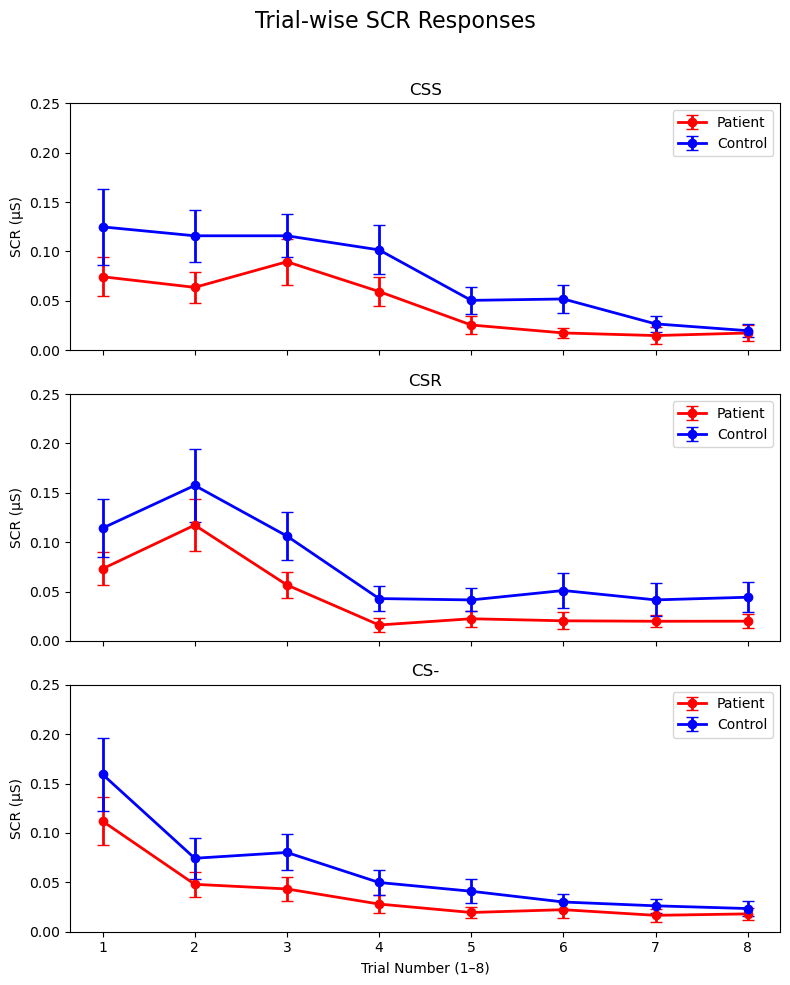

In [151]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set working directory
path = '/Volumes/Seagate Desktop Drive/NARSAD/SCR'
os.chdir(path)

# Load the trial-wise table
peakstatstable = pd.read_csv('peak_stats_table-phase1.csv')

# Identify group: N100s = patients, N200s = controls
peakstatstable['patient_group'] = np.where(peakstatstable['sid'].astype(str).str.startswith('N1'), 'Patient', 'Control')

# Keep participants with exactly 24 trials
peakstatstable = peakstatstable.groupby('sid').filter(lambda x: len(x) == 24)

# Replace negative SCR values with zero
peakstatstable.loc[peakstatstable['phaBase2Peak'] < 0, 'phaBase2Peak'] = 0

# Define stimulus types
stimulus_types = ['CS+S', 'CS+R', 'CS-']
stimulus_labels = {'CS+S': 'CSS', 'CS+R': 'CSR', 'CS-': 'CS-'}

# Map trial index per stimulus (1–8)
peakstatstable['trial_within_stim'] = peakstatstable.groupby(['sid', 'stTy']).cumcount() + 1

# Calculate trial-wise mean and SEM for each group
grouped_stats = (
    peakstatstable
    .groupby(['patient_group', 'stTy', 'trial_within_stim'])['phaBase2Peak']
    .agg(['mean', 'sem'])
    .reset_index()
    .rename(columns={'mean': 'Mean', 'sem': 'SEM'})
)

print("\nTrial-wise Means ± SEM for each group and stimulus:")
print(grouped_stats.head())

# Colors for groups
group_colors = {'Patient': 'red', 'Control': 'blue'}
trials = np.arange(1, 9)

# Create one figure with 3 subplots stacked vertically
fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
fig.suptitle('Trial-wise SCR Responses', fontsize=16)

# Loop through stimulus types and plot on subplots
for i, stim in enumerate(stimulus_types):
    ax = axes[i]
    
    for group in ['Patient', 'Control']:
        data = grouped_stats[
            (grouped_stats['patient_group'] == group) & 
            (grouped_stats['stTy'] == stim)
        ].sort_values('trial_within_stim')
        
        ax.errorbar(trials, data['Mean'], yerr=data['SEM'],
                    label=group, color=group_colors[group],
                    capsize=4, marker='o', linewidth=2)
    
    ax.set_title(f'{stimulus_labels[stim]}')
    ax.set_ylabel('SCR (µS)')
    ax.set_xticks(trials)
    ax.set_ylim(0,0.25)
    if i == 2:  # Only label x-axis on bottom plot
        ax.set_xlabel('Trial Number (1–8)')
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig('trialwise-scr-phase1.png', format='png', dpi=300)
plt.show()



Trial-wise Means ± SEM for each group and stimulus:
  patient_group  stTy  trial_within_stim      Mean       SEM
0       Control  CS+R                  1  0.114264  0.029478
1       Control  CS+R                  2  0.157509  0.037210
2       Control  CS+R                  3  0.106264  0.024260
3       Control  CS+R                  4  0.042943  0.012602
4       Control  CS+R                  5  0.041566  0.011675


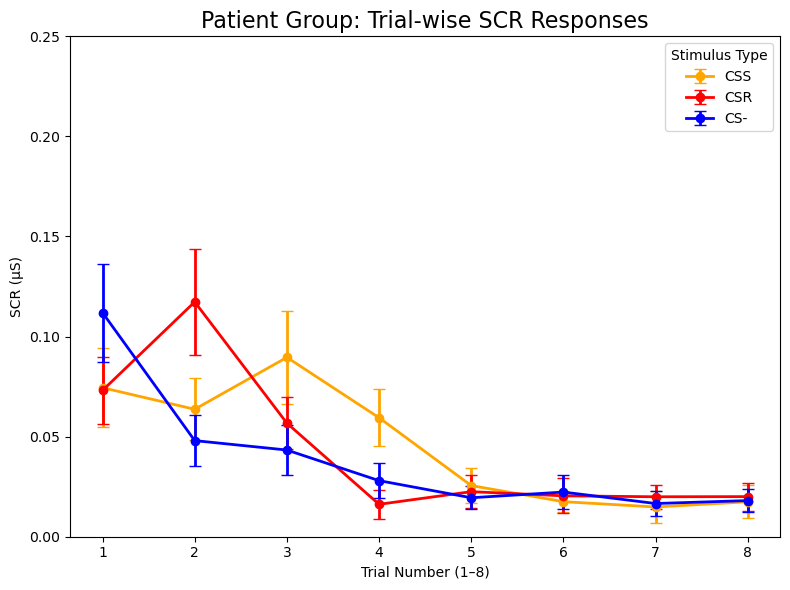

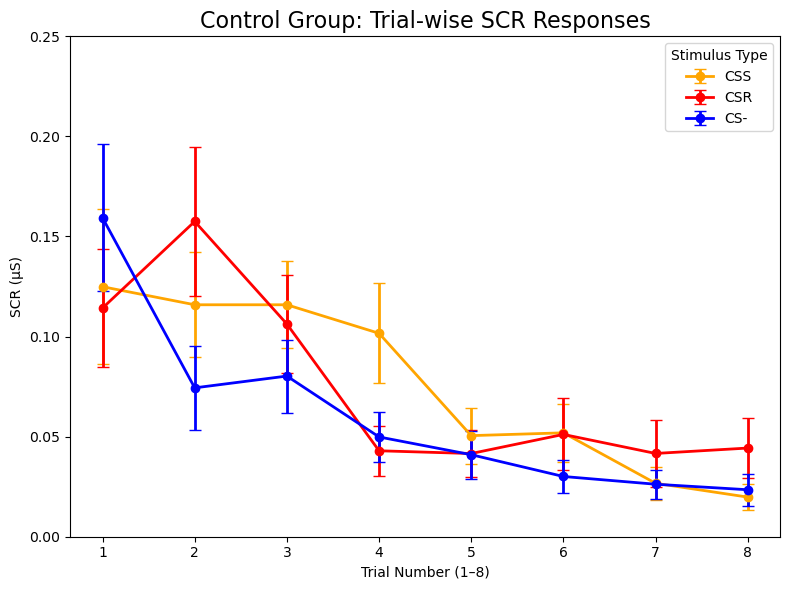

In [152]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set working directory
path = '/Volumes/Seagate Desktop Drive/NARSAD/SCR'
os.chdir(path)

# Load the trial-wise table
peakstatstable = pd.read_csv('peak_stats_table-phase1.csv')

# Identify group: N100s = patients, N200s = controls
peakstatstable['patient_group'] = np.where(
    peakstatstable['sid'].astype(str).str.startswith('N1'),
    'Patient', 'Control'
)

# Keep participants with exactly 24 trials
peakstatstable = peakstatstable.groupby('sid').filter(lambda x: len(x) == 24)

# Replace negative SCR values with zero
peakstatstable.loc[peakstatstable['phaBase2Peak'] < 0, 'phaBase2Peak'] = 0

# Define stimulus types
stimulus_types = ['CS+S', 'CS+R', 'CS-']
stimulus_labels = {'CS+S': 'CSS', 'CS+R': 'CSR', 'CS-': 'CS-'}

# Add trial index (1–8) per subject and stimulus type
peakstatstable['trial_within_stim'] = (
    peakstatstable.groupby(['sid', 'stTy']).cumcount() + 1
)

# Compute trial-wise mean and SEM for each group/stimulus
grouped_stats = (
    peakstatstable
    .groupby(['patient_group', 'stTy', 'trial_within_stim'])['phaBase2Peak']
    .agg(['mean', 'sem'])
    .reset_index()
    .rename(columns={'mean': 'Mean', 'sem': 'SEM'})
)

print("\nTrial-wise Means ± SEM for each group and stimulus:")
print(grouped_stats.head())

# Colors for stimuli
stim_colors = {'CS+S': 'orange', 'CS+R': 'red', 'CS-': 'blue'}
trials = np.arange(1, 9)

# Create two figures (one for each group)
groups = ['Patient', 'Control']
for group in groups:
    plt.figure(figsize=(8, 6))
    plt.title(f'{group} Group: Trial-wise SCR Responses', fontsize=16)

    for stim in stimulus_types:
        data = grouped_stats[
            (grouped_stats['patient_group'] == group) &
            (grouped_stats['stTy'] == stim)
        ].sort_values('trial_within_stim')

        plt.errorbar(
            data['trial_within_stim'], data['Mean'], yerr=data['SEM'],
            label=stimulus_labels[stim],
            color=stim_colors[stim],
            capsize=4, marker='o', linewidth=2
        )

    plt.xlabel('Trial Number (1–8)')
    plt.ylabel('SCR (µS)')
    plt.xticks(trials)
    plt.ylim(0, 0.25)
    plt.legend(title='Stimulus Type')
    plt.tight_layout()

    # Save each figure
    plt.savefig(f'trialwise-scr-phase1-{group.lower()}.png', format='png', dpi=300)
    plt.show()


In [155]:
grouped_stats

,patient_group,stTy,Mean,SEM
0,Control,CS+R,0.074946,0.017828
1,Control,CS+S,0.075901,0.015403
2,Control,CS-,0.060575,0.013378
3,Patient,CS+R,0.043287,0.008808
4,Patient,CS+S,0.045319,0.010436
5,Patient,CS-,0.038466,0.006967



Mean ± SEM SCR by group and stimulus:
  patient_group  stTy      Mean       SEM
0       Control  CS+R  0.074946  0.017828
1       Control  CS+S  0.075901  0.015403
2       Control   CS-  0.060575  0.013378
3       Patient  CS+R  0.043287  0.008808
4       Patient  CS+S  0.045319  0.010436
5       Patient   CS-  0.038466  0.006967


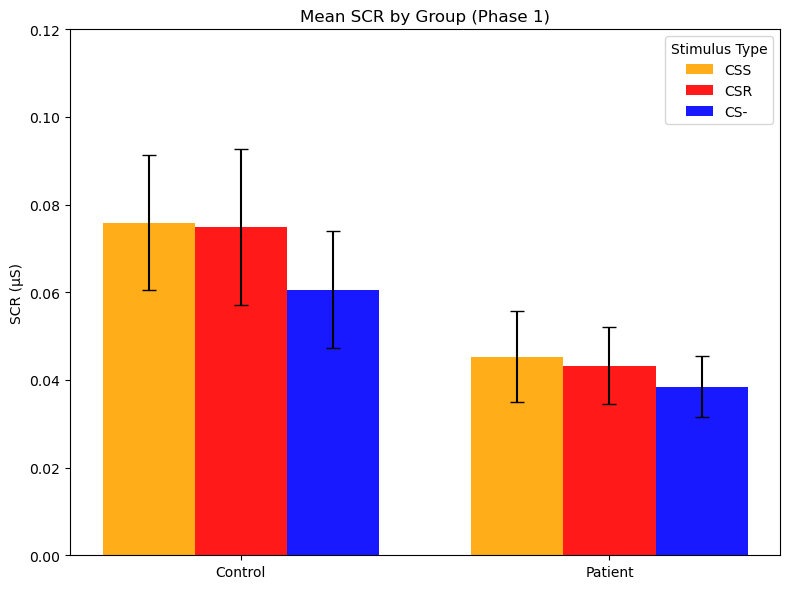

In [162]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set working directory
path = '/Volumes/Seagate Desktop Drive/NARSAD/SCR'
os.chdir(path)

# Load the trial-wise table
peakstatstable = pd.read_csv('peak_stats_table-phase1.csv')

# Identify group: N100s = patients, N200s = controls
peakstatstable['patient_group'] = np.where(
    peakstatstable['sid'].astype(str).str.startswith('N1'),
    'Patient',
    'Control'
)

# Keep participants with exactly 24 trials
peakstatstable = peakstatstable.groupby('sid').filter(lambda x: len(x) == 24)

# Replace negative SCR values with zero
peakstatstable.loc[peakstatstable['phaBase2Peak'] < 0, 'phaBase2Peak'] = 0

# Define stimulus types
stimulus_types = ['CS+S', 'CS+R', 'CS-']
stimulus_labels = {'CS+S': 'CSS', 'CS+R': 'CSR', 'CS-': 'CS-'}

# Aggregate SCR by participant, group, and stimulus type (mean across 8 trials)
subject_means = (
    peakstatstable
    .groupby(['sid', 'patient_group', 'stTy'])['phaBase2Peak']
    .mean()
    .reset_index()
)

# Compute group-level mean and SEM
grouped_stats = (
    subject_means
    .groupby(['patient_group', 'stTy'])['phaBase2Peak']
    .agg(['mean', 'sem'])
    .reset_index()
    .rename(columns={'mean': 'Mean', 'sem': 'SEM'})
)

print("\nMean ± SEM SCR by group and stimulus:")
print(grouped_stats)

# Colors for stimulus types
stim_colors = {'CS+S': 'orange', 'CS+R': 'red', 'CS-': 'blue'}

# Create bar plot
groups = ['Control', 'Patient']
x = np.arange(len(groups))  # positions for groups
width = 0.25  # width of each bar

fig, ax = plt.subplots(figsize=(8, 6))

for i, stim in enumerate(stimulus_types):
    data = grouped_stats[grouped_stats['stTy'] == stim]
    means = data['Mean'].values
    sems = data['SEM'].values

    ax.bar(x + (i - 1) * width, means, width, yerr=sems,
           label=stimulus_labels[stim], color=stim_colors[stim],
           capsize=5, alpha=0.9)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.set_ylabel('SCR (µS)')
ax.set_title('Mean SCR by Group (Phase 1)')
ax.legend(title='Stimulus Type')
ax.set_ylim(0, 0.12)

plt.tight_layout()
plt.savefig('barplot-scr-phase1-grouped.png', format='png', dpi=300)
plt.show()


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set working directory
path = '/Volumes/Seagate Desktop Drive/NARSAD/SCR'
os.chdir(path)

# Load the trial-wise table
peakstatstable = pd.read_csv('peak_stats_table-phase1.csv')

# Identify group: N100s = patients, N200s = controls
peakstatstable['patient_group'] = np.where(
    peakstatstable['sid'].astype(str).str.startswith('N1'),
    'Patient',
    'Control'
)

# Keep participants with exactly 24 trials
peakstatstable = peakstatstable.groupby('sid').filter(lambda x: len(x) == 24)

# Replace negative SCR values with zero
peakstatstable.loc[peakstatstable['phaBase2Peak'] < 0, 'phaBase2Peak'] = 0

#peakstatstable['CS+'] = peakstatstable[CS+R]

# Define stimulus types
stimulus_types = ['CS+S', 'CS+R', 'CS-']
stimulus_labels = {'CS+S': 'CSS', 'CS+R': 'CSR', 'CS-': 'CS-'}

# Aggregate SCR by participant, group, and stimulus type (mean across 8 trials)
subject_means = (
    peakstatstable
    .groupby(['sid', 'patient_group', 'stTy'])['phaBase2Peak']
    .mean()
    .reset_index()
)

# Compute group-level mean and SEM
grouped_stats = (
    subject_means
    .groupby(['patient_group', 'stTy'])['phaBase2Peak']
    .agg(['mean', 'sem'])
    .reset_index()
    .rename(columns={'mean': 'Mean', 'sem': 'SEM'})
)

print("\nMean ± SEM SCR by group and stimulus:")
print(grouped_stats)

# Colors for stimulus types
stim_colors = {'CS+S': 'orange', 'CS+R': 'red', 'CS-': 'blue'}

# Create bar plot
groups = ['Control', 'Patient']
x = np.arange(len(groups))  # positions for groups
width = 0.25  # width of each bar

fig, ax = plt.subplots(figsize=(8, 6))

for i, stim in enumerate(stimulus_types):
    data = grouped_stats[grouped_stats['stTy'] == stim]
    means = data['Mean'].values
    sems = data['SEM'].values

    ax.bar(x + (i - 1) * width, means, width, yerr=sems,
           label=stimulus_labels[stim], color=stim_colors[stim],
           capsize=5, alpha=0.9)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.set_ylabel('SCR (µS)')
ax.set_title('Mean SCR by Group (Phase 1)')
ax.legend(title='Stimulus Type')
ax.set_ylim(0, 0.12)

plt.tight_layout()
plt.savefig('barplot-scr-phase1-grouped.png', format='png', dpi=300)
plt.show()



Trial-wise Means ± sem by Phase, Group, and Stimulus:
     phase             group  stTy  trial_within_stim      Mean       sem
0  Phase 2  Control-Oxytocin  CS+R                  1  0.015292  0.006340
1  Phase 2  Control-Oxytocin  CS+R                  2  0.023833  0.007352
2  Phase 2  Control-Oxytocin  CS+R                  3  0.035833  0.013082
3  Phase 2  Control-Oxytocin  CS+R                  4  0.015417  0.002865
4  Phase 2  Control-Oxytocin  CS+R                  5  0.017958  0.004028


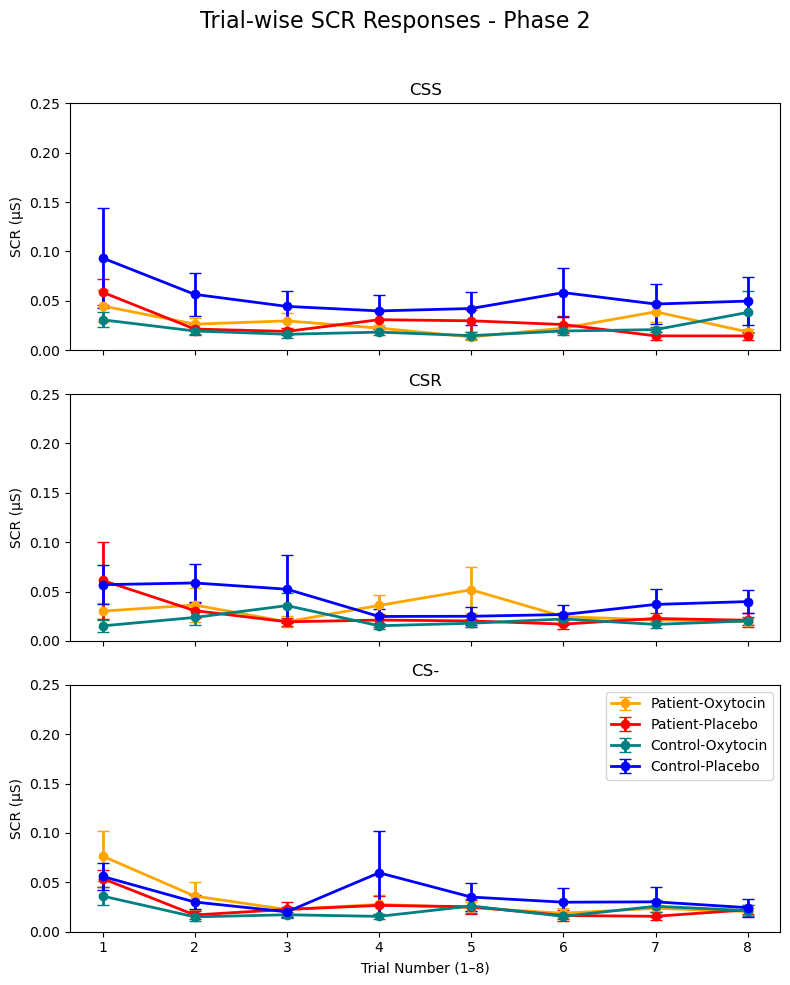

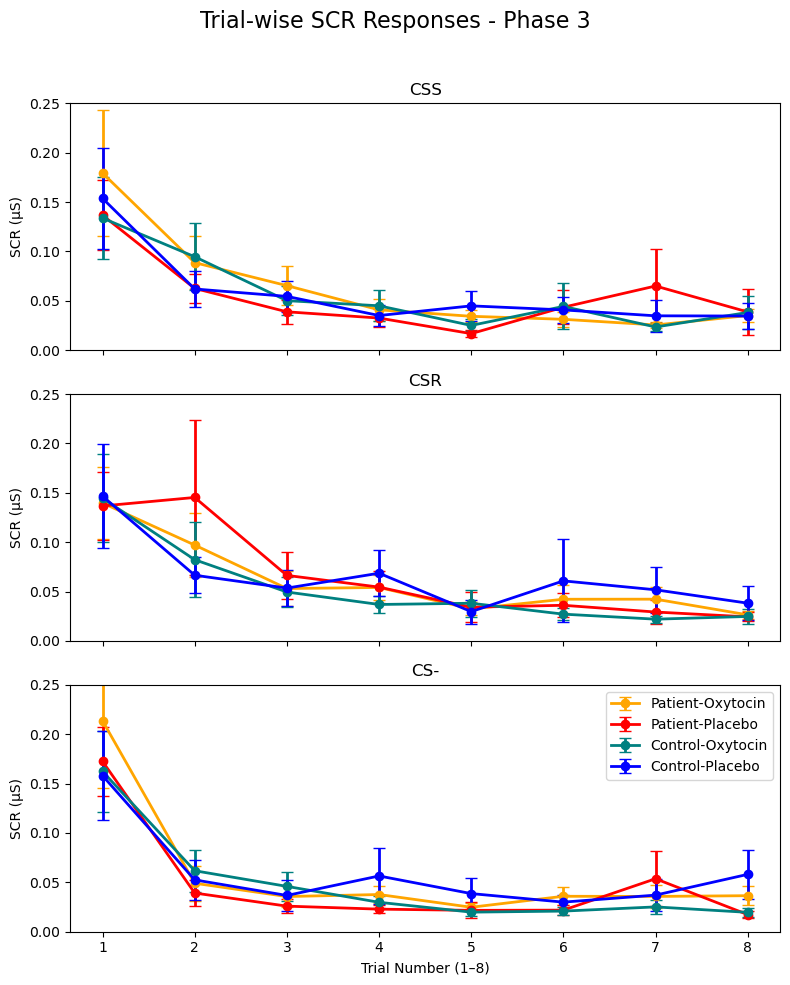

In [100]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

# Load the combined phase 2 & 3 data 
peakstatstable = pd.read_csv('peak_stats_table-phase2.3.csv') 

# # Identify group: Patients (N100s) vs Controls (N200s) 
peakstatstable['patient_group'] = np.where(peakstatstable['sid'].astype(str).str.startswith('N1'), 'Patient', 'Control') 

# Keep participants with 48 trials only 
peakstatstable = peakstatstable.groupby('sid').filter(lambda x: len(x) == 48) 

# Replace negative SCR values with zero 
peakstatstable.loc[peakstatstable['phaBase2Peak'] < 0.02, 'phaBase2Peak'] = 0 

#importing/merging in drug order 
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order['sid'] = drug_order['subID']
peakstatstable = peakstatstable = peakstatstable.merge(drug_order, on='sid', how='left')

# Create group variable
def assign_group(row):
    if str(row['subID']).startswith('N1'):
        base_group = 'Patient'
    else:
        base_group = 'Control'

    drug_group = 'Oxytocin' if row['drug_condition'] == 1 else 'Placebo'
    return f"{base_group}-{drug_group}"

peakstatstable['group'] = peakstatstable.apply(assign_group, axis=1)


# Define phase trial ranges 
phase2_trials = range(1, 25) # Phase 2: trials 1–24 
phase3_trials = range(25, 49) # Phase 3: trials 25–48 

# Define stimulus types and labels 
stimulus_types = ['CS+S', 'CS+R', 'CS-'] 
stimulus_labels = {'CS+S': 'CSS', 'CS+R': 'CSR', 'CS-': 'CS-'} 

# Add "phase" column 
peakstatstable['phase'] = np.where(peakstatstable['stNum'].isin(phase2_trials), 'Phase 2', 'Phase 3') 

# Map trial index within each stimulus type (1–8) 
peakstatstable['trial_within_stim'] = peakstatstable.groupby(['sid', 'stTy', 'phase']).cumcount() + 1 

# Aggregate trial-wise stats 
grouped_stats = ( peakstatstable .groupby(['phase', 'group', 'stTy', 'trial_within_stim'])['phaBase2Peak'] .agg(['mean', 'sem']) .reset_index() .rename(columns={'mean': 'Mean', 'sem': 'sem'}) ) 

print("\nTrial-wise Means ± sem by Phase, Group, and Stimulus:") 
print(grouped_stats.head()) 

# Colors for groups 
group_colors = {'Patient-Oxytocin': 'orange','Patient-Placebo': 'red', 'Control-Oxytocin': 'teal', 'Control-Placebo': 'blue'} 

# Plot Phase 2 and Phase 3 separately 
for phase in ['Phase 2', 'Phase 3']: 
    fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True) 
    fig.suptitle(f'Trial-wise SCR Responses - {phase}', fontsize=16)
    for i, stim in enumerate(stimulus_types): 
        ax = axes[i] 
        for group in ['Patient-Oxytocin','Patient-Placebo', 'Control-Oxytocin','Control-Placebo']: 
            data = grouped_stats[ (grouped_stats['phase'] == phase) & (grouped_stats['stTy'] == stim) & (grouped_stats['group'] == group) ].sort_values('trial_within_stim') 
            trials = data['trial_within_stim'].values 
            ax.errorbar(trials, data['Mean'], yerr=data['sem'], label=group, color=group_colors[group], capsize=4, marker='o', linewidth=2) 
        ax.set_title(f'{stimulus_labels[stim]}') 
        ax.set_ylabel('SCR (µS)') 
        ax.set_xticks(trials) 
        ax.set_xticklabels(trials) 
        ax.set_ylim(0,0.25) 
        if i == 2: 
            ax.set_xlabel('Trial Number (1–8)') 
            ax.legend() 
    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.savefig(f'trialwise-scr-{phase}.png', format='png', dpi=300) 
    plt.show()


Trial-wise Means ± SEM by Phase, Group, and Stimulus:
     phase             group  stTy  trial_within_stim      Mean       SEM
0  Phase 2  Control-Oxytocin  CS+R                  1  0.015292  0.006340
1  Phase 2  Control-Oxytocin  CS+R                  2  0.023833  0.007352
2  Phase 2  Control-Oxytocin  CS+R                  3  0.035833  0.013082
3  Phase 2  Control-Oxytocin  CS+R                  4  0.015417  0.002865
4  Phase 2  Control-Oxytocin  CS+R                  5  0.017958  0.004028


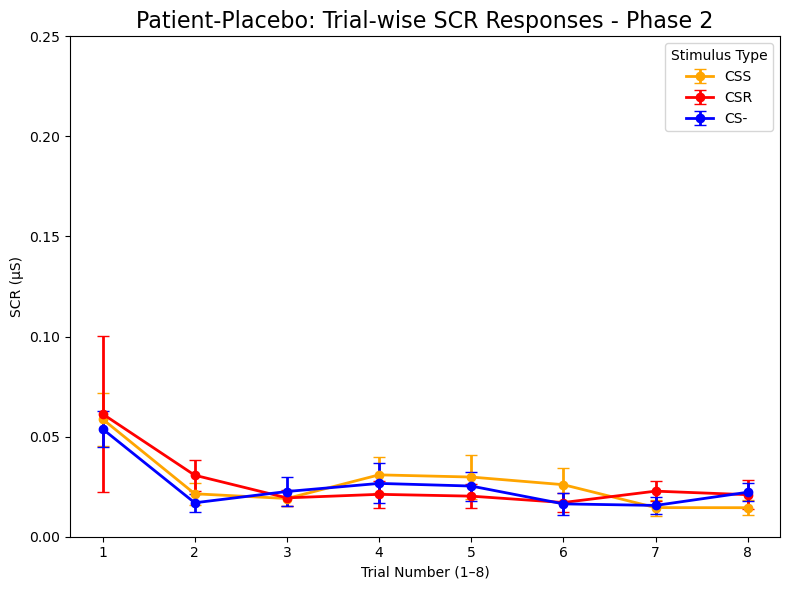

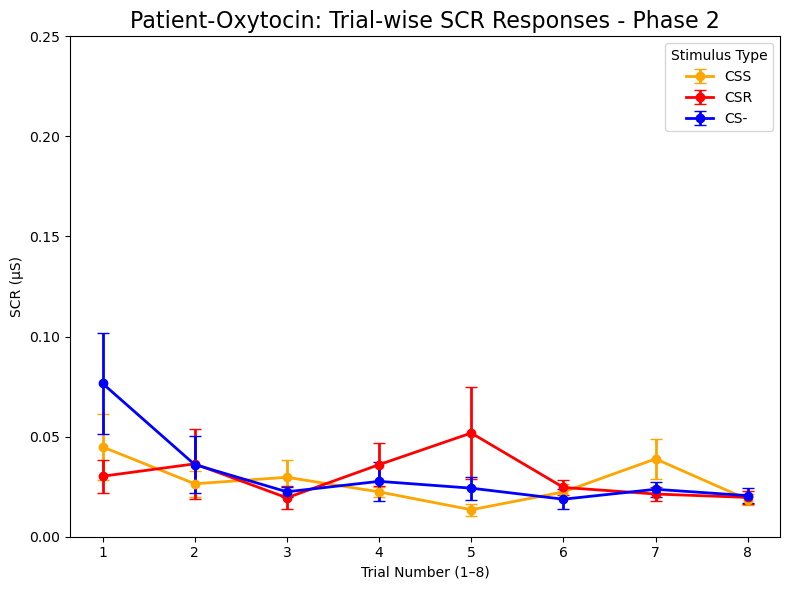

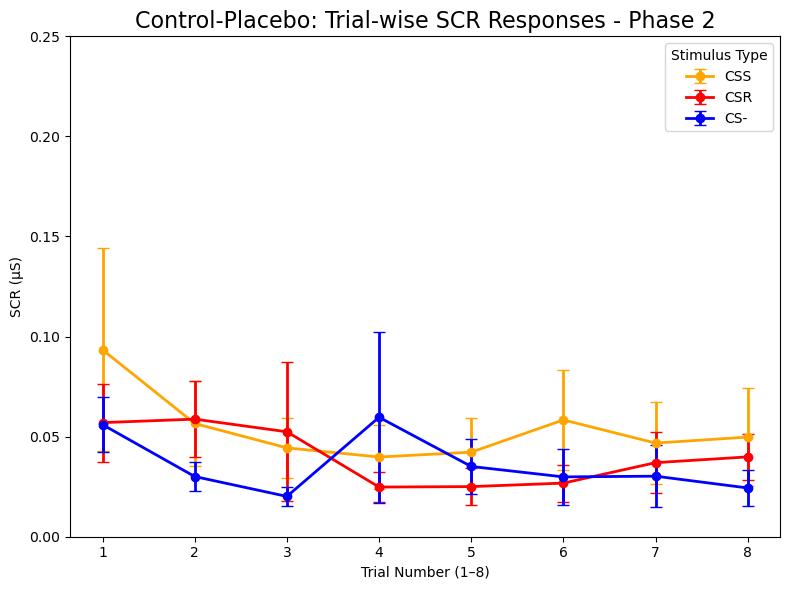

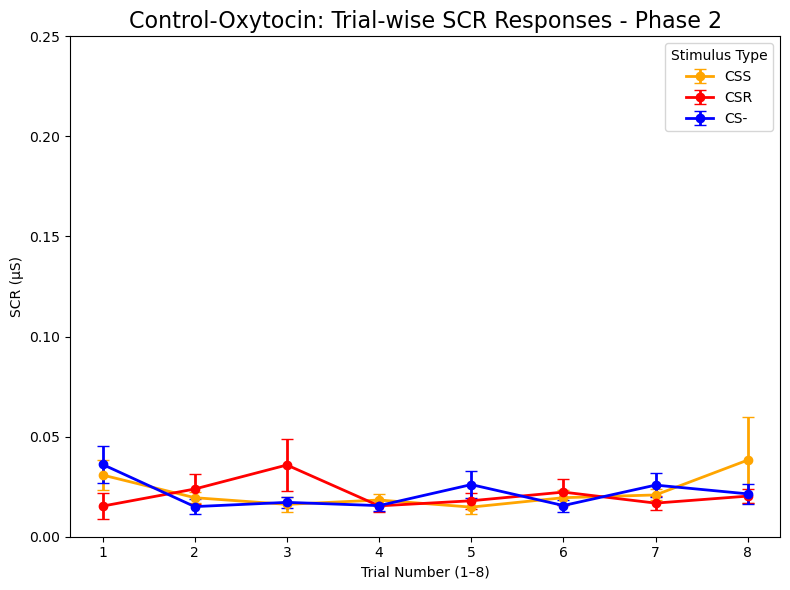

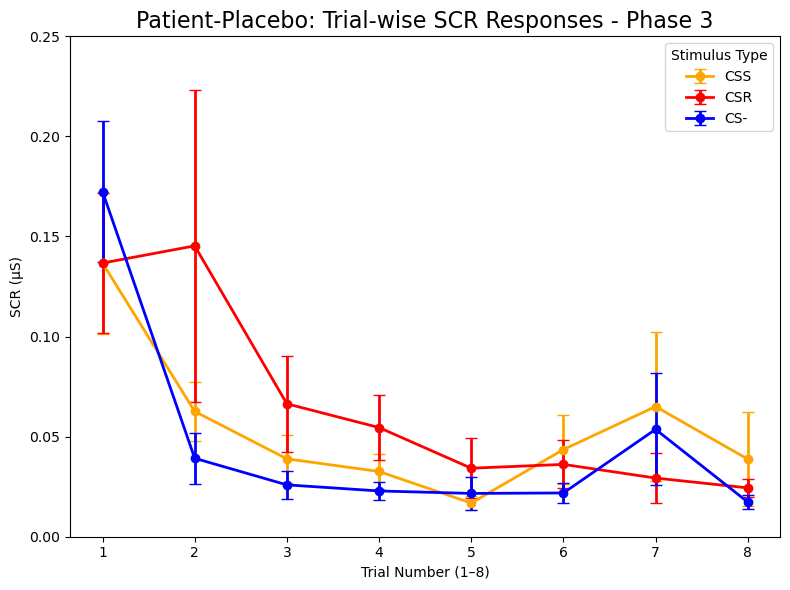

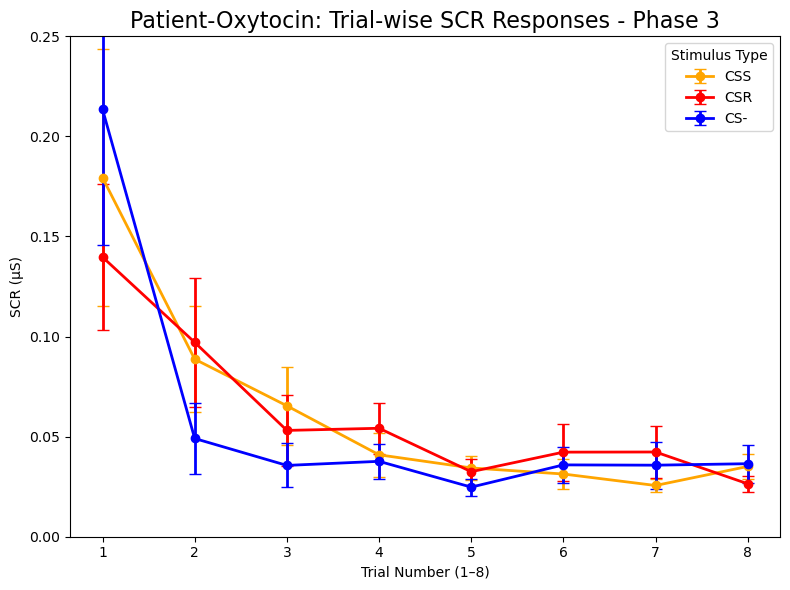

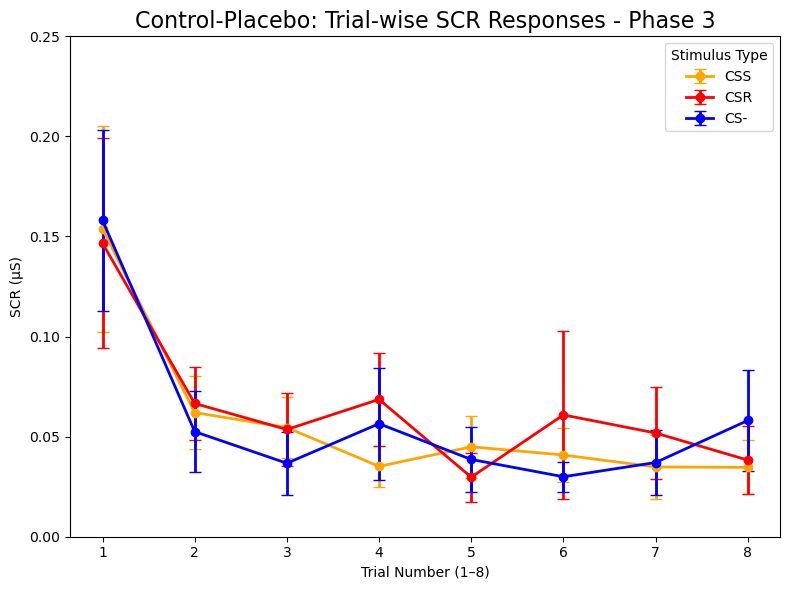

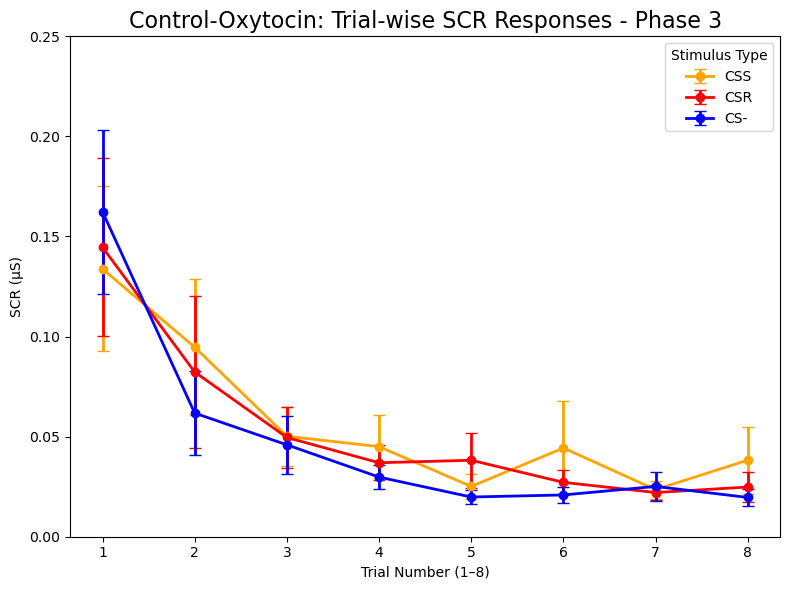

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the combined phase 2 & 3 data
peakstatstable = pd.read_csv('peak_stats_table-phase2.3.csv')

# Identify group: Patients (N100s) vs Controls (N200s)
peakstatstable['patient_group'] = np.where(
    peakstatstable['sid'].astype(str).str.startswith('N1'),
    'Patient',
    'Control'
)

# Keep participants with 48 trials only
peakstatstable = peakstatstable.groupby('sid').filter(lambda x: len(x) == 48)

# Replace small/negative SCR values with zero
peakstatstable.loc[peakstatstable['phaBase2Peak'] < 0.02, 'phaBase2Peak'] = 0

# Import and merge drug order
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order['sid'] = drug_order['subID']
peakstatstable = peakstatstable.merge(drug_order, on='sid', how='left')

# Create group variable (Patient/Control × Oxytocin/Placebo)
def assign_group(row):
    base_group = 'Patient' if str(row['subID']).startswith('N1') else 'Control'
    drug_group = 'Oxytocin' if row['drug_condition'] == 1 else 'Placebo'
    return f"{base_group}-{drug_group}"

peakstatstable['group'] = peakstatstable.apply(assign_group, axis=1)

# Define phase trial ranges
phase2_trials = range(1, 25)
phase3_trials = range(25, 49)

# Define stimulus types and labels
stimulus_types = ['CS+S', 'CS+R', 'CS-']
stimulus_labels = {'CS+S': 'CSS', 'CS+R': 'CSR', 'CS-': 'CS-'}

# Add phase column
peakstatstable['phase'] = np.where(
    peakstatstable['stNum'].isin(phase2_trials),
    'Phase 2',
    'Phase 3'
)

# Add trial index (1–8) within each stimulus and phase
peakstatstable['trial_within_stim'] = (
    peakstatstable.groupby(['sid', 'stTy', 'phase']).cumcount() + 1
)

# Aggregate trial-wise stats
grouped_stats = (
    peakstatstable
    .groupby(['phase', 'group', 'stTy', 'trial_within_stim'])['phaBase2Peak']
    .agg(['mean', 'sem'])
    .reset_index()
    .rename(columns={'mean': 'Mean', 'sem': 'SEM'})
)

print("\nTrial-wise Means ± SEM by Phase, Group, and Stimulus:")
print(grouped_stats.head())

# Colors for stimuli
stim_colors = {'CS+S': 'orange', 'CS+R': 'red', 'CS-': 'blue'}

# Define groups to plot
groups = ['Patient-Placebo', 'Patient-Oxytocin', 'Control-Placebo', 'Control-Oxytocin']

# Plot Phase 2 and Phase 3 separately
for phase in ['Phase 2', 'Phase 3']:
    for group in groups:
        plt.figure(figsize=(8, 6))
        plt.title(f'{group}: Trial-wise SCR Responses - {phase}', fontsize=16)

        for stim in stimulus_types:
            data = grouped_stats[
                (grouped_stats['phase'] == phase)
                & (grouped_stats['group'] == group)
                & (grouped_stats['stTy'] == stim)
            ].sort_values('trial_within_stim')

            plt.errorbar(
                data['trial_within_stim'], data['Mean'], yerr=data['SEM'],
                label=stimulus_labels[stim],
                color=stim_colors[stim],
                capsize=4, marker='o', linewidth=2
            )

        plt.xlabel('Trial Number (1–8)')
        plt.ylabel('SCR (µS)')
        plt.xticks(range(1, 9))
        plt.ylim(0, 0.25)
        plt.legend(title='Stimulus Type')
        plt.tight_layout()

        # Save each figure
        plt.savefig(f'trialwise-scr-{phase}-{group.lower().replace(" ", "_")}.png',
                    format='png', dpi=300)
        plt.show()



Mean SCR ± SEM by Phase, Group, and Stimulus:
     phase             group  stTy      Mean       SEM
0  Phase 2  Control-Oxytocin  CS+R  0.020964  0.003886
1  Phase 2  Control-Oxytocin  CS+S  0.022286  0.003622
2  Phase 2  Control-Oxytocin   CS-  0.021589  0.002809
3  Phase 2   Control-Placebo  CS+R  0.040214  0.012622
4  Phase 2   Control-Placebo  CS+S  0.053920  0.018529


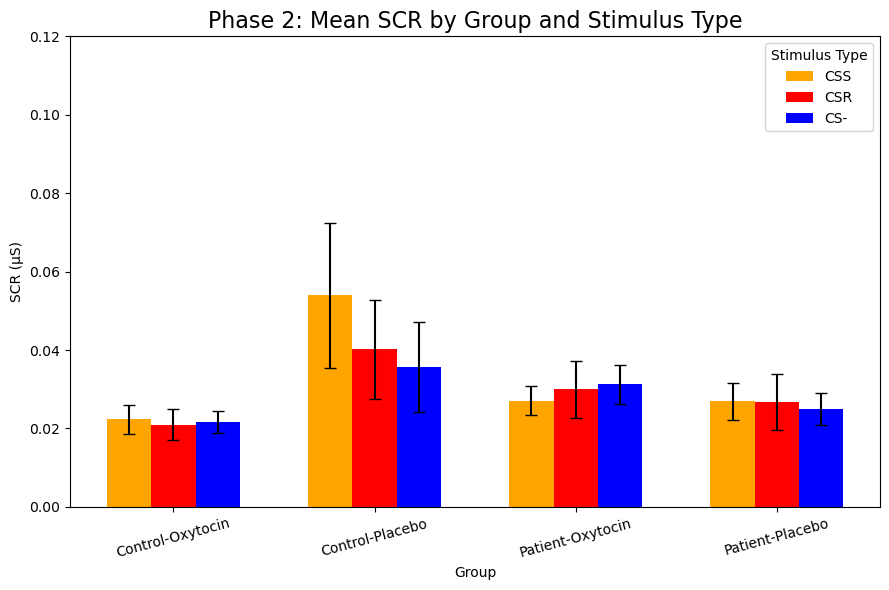

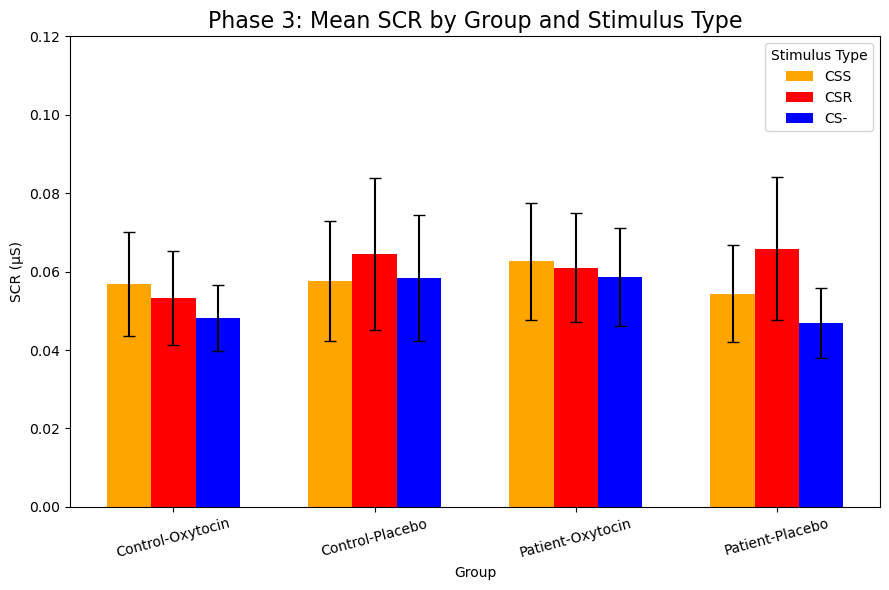

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the combined phase 2 & 3 data 
peakstatstable = pd.read_csv('peak_stats_table-phase2.3.csv') 

# Identify group: Patients (N100s) vs Controls (N200s)
peakstatstable['patient_group'] = np.where(
    peakstatstable['sid'].astype(str).str.startswith('N1'),
    'Patient', 'Control'
)

# Keep participants with 48 trials only 
peakstatstable = peakstatstable.groupby('sid').filter(lambda x: len(x) == 48)

# Replace small/negative SCR values with zero 
peakstatstable.loc[peakstatstable['phaBase2Peak'] < 0.02, 'phaBase2Peak'] = 0

# Import and merge drug order 
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order['sid'] = drug_order['subID']
peakstatstable = peakstatstable.merge(drug_order, on='sid', how='left')

# Create group variable (Patient/Control × Oxytocin/Placebo)
def assign_group(row):
    base_group = 'Patient' if str(row['subID']).startswith('N1') else 'Control'
    drug_group = 'Oxytocin' if row['drug_condition'] == 1 else 'Placebo'
    return f"{base_group}-{drug_group}"

peakstatstable['group'] = peakstatstable.apply(assign_group, axis=1)

# Define phase trial ranges 
phase2_trials = range(1, 25)
phase3_trials = range(25, 49)

# Define stimulus types and labels 
stimulus_types = ['CS+S', 'CS+R', 'CS-']
stimulus_labels = {'CS+S': 'CSS', 'CS+R': 'CSR', 'CS-': 'CS-'}

# Add phase column 
peakstatstable['phase'] = np.where(
    peakstatstable['stNum'].isin(phase2_trials),
    'Phase 2', 'Phase 3'
)

# ---- Collapse across trials ----
# Compute mean SCR per subject, group, stimulus, and phase
subject_means = (
    peakstatstable
    .groupby(['phase', 'group', 'sid', 'stTy'])['phaBase2Peak']
    .mean()
    .reset_index()
)

# Then get group-level mean and SEM
group_means = (
    subject_means
    .groupby(['phase', 'group', 'stTy'])['phaBase2Peak']
    .agg(['mean', 'sem'])
    .reset_index()
    .rename(columns={'mean': 'Mean', 'sem': 'SEM'})
)

print("\nMean SCR ± SEM by Phase, Group, and Stimulus:")
print(group_means.head())

# Colors for stimuli
stim_colors = {'CS+S': 'orange', 'CS+R': 'red', 'CS-': 'blue'}

# Ordered list of groups (for consistent plotting)
groups = ['Control-Oxytocin', 'Control-Placebo', 'Patient-Oxytocin', 'Patient-Placebo']

# Plot bar charts for each phase
for phase in ['Phase 2', 'Phase 3']:
    phase_data = group_means[group_means['phase'] == phase]
    
    fig, ax = plt.subplots(figsize=(9, 6))
    x = np.arange(len(groups))  # positions for each group on x-axis
    width = 0.22  # width of each bar
    
    # Offset bars for each stimulus type
    offsets = {'CS+S': -width, 'CS+R': 0, 'CS-': width}
    
    for stim in stimulus_types:
        stim_data = phase_data[phase_data['stTy'] == stim]
        means = [stim_data[stim_data['group'] == g]['Mean'].values[0] if g in stim_data['group'].values else np.nan for g in groups]
        sems = [stim_data[stim_data['group'] == g]['SEM'].values[0] if g in stim_data['group'].values else np.nan for g in groups]
        ax.bar(x + offsets[stim], means, yerr=sems, width=width,
               label=stimulus_labels[stim], color=stim_colors[stim], capsize=4)
    
    ax.set_title(f'{phase}: Mean SCR by Group and Stimulus Type', fontsize=16)
    ax.set_xlabel('Group')
    ax.set_ylabel('SCR (µS)')
    ax.set_xticks(x)
    ax.set_xticklabels(groups, rotation=15)
    ax.set_ylim(0, 0.12)
    ax.legend(title='Stimulus Type')
    plt.tight_layout()
    plt.savefig(f'mean-scr-barplot-grouped-{phase}.png', format='png', dpi=300)
    plt.show()


### second half extinction vs. first half reinstatement

In [378]:
import pandas as pd
import numpy as np

exclude_participants = 0

# Parameters to adjust:
trialnumber2_early = range(1, 13)  # Early trials for Phase 2 (1:12)
trialnumber2_late = range(13, 25)   # Late trials for Phase 2 (13:24)
trialnumber3_early = range(26, 37)  # Early trials for Phase 3 (25:36)
trialnumber3_late = range(37, 49)   # Late trials for Phase 3 (37:48)

excludeparticipants = 0  # Set to 0 to include all subjects; if set to 1, participants with rejected trials >= rejtrials_threshold are excluded
rejtrials_threshold = 24  # Threshold for trial rejection; adjust according to trial number

# Load data
peakstatstable = pd.read_csv('peak_stats_table-phase2.3.csv')
participants = peakstatstable['sid'].unique()
trial_types = peakstatstable['stTy'].unique()

# Separate data by participant, phase, and stim type
grouped_data = peakstatstable.groupby('sid')
dat = []

for participant in participants:
    data = grouped_data.get_group(participant)
    participant_data = {'subID': participant}

    # Ensuring consistent data structure
    if data.shape[0] == 48:
        
        # Phase 2 processing: stims numbered in trialnumber2
        phase2_data = data[data['stNum'].isin(range(1, 25))]
        rejTrials = phase2_data[phase2_data['phaBase2Peak'] < 0.02].index
        phase2_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials2'] = len(rejTrials)

        # Separate out stim types for early trials
        phase2_early_data = phase2_data[phase2_data['stNum'].isin(trialnumber2_early)]
        data2_early = {key: value for key, value in phase2_early_data.groupby('stTy')}
        
        # Calculate means and SE for early trials
        try:
            participant_data['meanCSS2_early'] = data2_early['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS2_early'] = data2_early['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data2_early['CS+S']))
            participant_data['nCSS2_early'] = len(data2_early['CS+S'])
            participant_data['meanCSR2_early'] = data2_early['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR2_early'] = data2_early['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data2_early['CS+R']))
            participant_data['nCSR2_early'] = len(data2_early['CS+R'])
            participant_data['meanCSminus2_early'] = data2_early['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus2_early'] = data2_early['CS-']['phaBase2Peak'].std() / np.sqrt(len(data2_early['CS-']))
            participant_data['nCSminus2_early'] = len(data2_early['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 2 early trials.")

        # Separate out stim types for late trials
        phase2_late_data = phase2_data[phase2_data['stNum'].isin(trialnumber2_late)]
        data2_late = {key: value for key, value in phase2_late_data.groupby('stTy')}
        
        # Calculate means and SE for late trials
        try:
            participant_data['meanCSS2_late'] = data2_late['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS2_late'] = data2_late['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data2_late['CS+S']))
            participant_data['nCSS2_late'] = len(data2_late['CS+S'])
            participant_data['meanCSR2_late'] = data2_late['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR2_late'] = data2_late['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data2_late['CS+R']))
            participant_data['nCSR2_late'] = len(data2_late['CS+R'])
            participant_data['meanCSminus2_late'] = data2_late['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus2_late'] = data2_late['CS-']['phaBase2Peak'].std() / np.sqrt(len(data2_late['CS-']))
            participant_data['nCSminus2_late'] = len(data2_late['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 2 late trials.")

        # Phase 3 processing: stims numbered in trialnumber3
        phase3_data = data[data['stNum'].isin(range(25, 49))]
        rejTrials = phase3_data[phase3_data['phaBase2Peak'] < 0.02].index
        phase3_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials3'] = len(rejTrials)

        # Separate out stim types for early trials
        phase3_early_data = phase3_data[phase3_data['stNum'].isin(trialnumber3_early)]
        data3_early = {key: value for key, value in phase3_early_data.groupby('stTy')}
        
        # Calculate means and SE for early trials
        try:
            participant_data['meanCSS3_early'] = data3_early['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS3_early'] = data3_early['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data3_early['CS+S']))
            participant_data['nCSS3_early'] = len(data3_early['CS+S'])
            participant_data['meanCSR3_early'] = data3_early['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR3_early'] = data3_early['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data3_early['CS+R']))
            participant_data['nCSR3_early'] = len(data3_early['CS+R'])
            participant_data['meanCSminus3_early'] = data3_early['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus3_early'] = data3_early['CS-']['phaBase2Peak'].std() / np.sqrt(len(data3_early['CS-']))
            participant_data['nCSminus3_early'] = len(data3_early['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 3 early trials.")

        # Separate out stim types for late trials
        phase3_late_data = phase3_data[phase3_data['stNum'].isin(trialnumber3_late)]
        data3_late = {key: value for key, value in phase3_late_data.groupby('stTy')}
        
        # Calculate means and SE for late trials
        try:
            participant_data['meanCSS3_late'] = data3_late['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS3_late'] = data3_late['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data3_late['CS+S']))
            participant_data['nCSS3_late'] = len(data3_late['CS+S'])
            participant_data['meanCSR3_late'] = data3_late['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR3_late'] = data3_late['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data3_late['CS+R']))
            participant_data['nCSR3_late'] = len(data3_late['CS+R'])
            participant_data['meanCSminus3_late'] = data3_late['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus3_late'] = data3_late['CS-']['phaBase2Peak'].std() / np.sqrt(len(data3_late['CS-']))
            participant_data['nCSminus3_late'] = len(data3_late['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 3 late trials.")

    # Add participant data to the main list
    dat.append(participant_data)


# Convert dat list to a DataFrame for easier viewing and export
dat_df = pd.DataFrame(dat)

if exclude_participants == 1:
    dat_df = dat_df[dat_df['rejTrials2'] < 24]

print(dat_df)


    subID  rejTrials2  meanCSS2_early  seCSS2_early  nCSS2_early  \
0    N101           3        0.017800      0.004499            5   
1    N103           4        0.035500      0.004093            4   
2    N104           4        0.014333      0.007172            3   
3    N105           5        0.025333      0.000882            3   
4    N106           0        0.025000      0.002000            3   
..    ...         ...             ...           ...          ...   
96   N255           0        0.031667      0.002404            3   
97   N257           3        0.024333      0.000333            3   
98   N258           0        0.030667      0.001453            3   
99   N259           0        0.030667      0.000333            3   
100  N260          11        0.027667      0.017477            3   

     meanCSR2_early  seCSR2_early  nCSR2_early  meanCSminus2_early  \
0          0.053333      0.025314            3            0.024000   
1          0.022000      0.022000          

#### Placebo 

In [326]:

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

merged_data = merged_data[merged_data['drug'] == 0]
merged_data = merged_data[merged_data['patient_group'] == 0]


# Reshape data to stack early and late responses with a time variable
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'gender'], 
                    value_vars=['meanCSR2_late', 'meanCSR3_early', 'meanCSS2_late', 'meanCSS3_early', 'meanCSminus2_late', 'meanCSminus3_early'], 
                    var_name='stim_type_time', 
                    value_name='response')

# Split 'stim_type_time' into separate 'stim_type' and 'time' columns
long_data['stim_type'] = long_data['stim_type_time'].str.extract(r'mean(\w+)_')[0]
long_data['time'] = long_data['stim_type_time'].str.extract(r'_(\w+)$')[0].map({'late': 1, 'early': 2})

# Map stim_type to numerical codes
long_data['stim_type'] = long_data['stim_type'].map({
    'CSR2': 1, 
    'CSS2': 2, 
    'CSminus2': 3
})

# Specify the model with time as a main effect
model_formula = 'response ~ gender + stim_type * time'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9621
Date:                Tue, 18 Nov 2025   Prob (F-statistic):              0.386
Time:                        08:45:11   Log-Likelihood:                 107.69
No. Observations:                  84   AIC:                            -209.4
Df Residuals:                      81   BIC:                            -202.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0160      0.011      1.

In [380]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Convert original list of dictionaries into a DataFrame
dat_df = pd.DataFrame(dat)

# Load drug/gender table
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge
merged_data = pd.merge(dat_df, drug_order, on='subID', how='inner')
merged_data = merged_data[merged_data['drug_condition'] == 0]

# Prepare columns
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']
merged_data['drug'] = merged_data['drug_condition']

# --- Reshape into long trial-type × time format ---
long_data = pd.melt(
    merged_data,
    id_vars=['subID', 'patient_group', 'drug', 'gender'],
    value_vars=[
        'meanCSR2_late', 'meanCSR3_early',
        'meanCSS2_late', 'meanCSS3_early',
        'meanCSminus2_late', 'meanCSminus3_early'
    ],
    var_name='stim_type_time',
    value_name='response'
)

# Extract stim type
long_data['stim_type'] = long_data['stim_type_time'].str.extract(r'mean(\w+)_')[0]

# Extract time (early vs late)
long_data['time'] = (
    long_data['stim_type_time']
    .str.extract(r'_(\w+)$')[0]
    .map({'early': 0, 'late': 1})  # better coding for linear modeling
)

# Stim type numeric coding
long_data['stim_type'] = long_data['stim_type'].map({
    'CSR2': 1,
    'CSS2': 2,
    'CSminus2': 3,
    'CSR3': 1,
    'CSS3': 2,
    'CSminus3': 3,    
})

# ---------------------------------------------
# Mixed-effects model (random intercept for subject)
# ---------------------------------------------
model_formula = (
    "response ~ patient_group + gender + stim_type * time"
)

model = smf.mixedlm(
    formula=model_formula,
    data=long_data,
    groups=long_data['subID'],        # random intercept per subject
).fit()

print(model.summary())


          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  response
No. Observations:  300      Method:              REML    
No. Groups:        50       Scale:               0.0025  
Min. group size:   6        Log-Likelihood:      397.7107
Max. group size:   6        Converged:           Yes     
Mean group size:   6.0                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.107    0.018  5.961 0.000  0.072  0.142
patient_group  -0.007    0.018 -0.387 0.699 -0.042  0.028
gender          0.028    0.018  1.607 0.108 -0.006  0.063
stim_type      -0.026    0.005 -5.201 0.000 -0.036 -0.016
time           -0.084    0.015 -5.493 0.000 -0.114 -0.054
stim_type:time  0.025    0.007  3.472 0.001  0.011  0.038
Group Var       0.003    0.017                           



/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [59]:
import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx",'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID','drug_condition', 'gender_code']], on='subID', how='left')

data = data[data['drug_condition'] == 0]

data['CSRdiff'] = data['meanCSR3_early']-data['meanCSR2_late']
data['CSSdiff'] = data['meanCSS3_early']-data['meanCSS2_late']
data['CSminusdiff'] = data['meanCSminus3_early']-data['meanCSminus2_late']


# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        'patient' if row['subID'].startswith('N1') else
        'control'
    ), axis=1
)

# Initialize dictionary to store means and SEs
all_stats = {}

# Calculate means and SEs for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Early stage statistics for CSS2
    mean = group_data['CSSdiff'].mean()
    se = group_data['CSSdiff'].sem()
    all_stats[f'CSSdiff_{group}'] = (mean, se)
    

    # Early stage statistics for CSS2
    mean = group_data['CSRdiff'].mean()
    se = group_data['CSRdiff'].sem()
    all_stats[f'CSRdiff_{group}'] = (mean, se)
    
    # Early stage statistics for CSS2
    mean = group_data['CSminusdiff'].mean()
    se = group_data['CSminusdiff'].sem()
    all_stats[f'CSminusdiff_{group}'] = (mean, se)

    
import pandas as pd


# Initialize dictionary to store all data
all_data = {}

# Populate all_data with raw data for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Store early and late stage data for each stimulus type
    all_data[f'CSSdiff_{group}'] = group_data['CSSdiff'].values
    all_data[f'CSRdiff_{group}'] = group_data['CSRdiff'].values
    all_data[f'CSminusdiff_{group}'] = group_data['CSminusdiff'].values


In [60]:
from scipy.stats import ttest_ind, ttest_1samp

# ✅ Function to prepare data for multibar plot
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for contrast in ['CSRdiff','CSSdiff','CSminusdiff']:
        for group in ['patient','control']:
            mean, se = all_stats[f'{contrast}_{group}']
            data.append({
                'Contrast': contrast,
                'Group': group.replace('_', ' ').title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(data)


# ✅ Function to perform post-hoc tests
def calculate_posthoc_tests(all_data):
    results = []
    
    for contrast in ['CSRdiff','CSSdiff','CSminusdiff']:
        patient = all_data[f'{contrast}_patient']
        control = all_data[f'{contrast}_control']
        
        # --- 1) Within-group tests vs 0
        for group_name, data in {
            'Patient': patient,
            'Control': control
        }.items():
            if len(data) > 1:
                t_stat, p_value = ttest_1samp(data, 0)
            else:
                t_stat, p_value = (np.nan, np.nan)
            results.append({'Comparison': f'{group_name} vs 0 ({contrast})',
                            'T-Stat': t_stat, 'P-Value': p_value})

        # --- 2) Between-group comparisons
        for group_pair, (data1, data2) in {
            'Patient vs Control': (patient, control),
        }.items():
            if len(data1) > 1 and len(data2) > 1:
                t_stat, p_value = ttest_ind(data1, data2)
            else:
                t_stat, p_value = (np.nan, np.nan)
            results.append({'Comparison': f'{group_pair} ({contrast})',
                            'T-Stat': t_stat, 'P-Value': p_value})

    return pd.DataFrame(results)


# ✅ Plot function
def plot_multibar_with_error_bars(all_stats, all_data, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)
    
    plt.figure(figsize=(12, 7))
    contrasts = df['Contrast'].unique()
    groups = df['Group'].unique()
    width = 0.9
    colors = ["#e22525", "#272dd5"]

    # Plot each contrast
    for i, contrast in enumerate(contrasts):
        x_pos = np.arange(len(groups)) + i * (len(groups) + 1)
        
        for j, group in enumerate(groups):
            group_data = df[(df['Contrast'] == contrast) & (df['Group'] == group)]
            
            plt.bar(x_pos[j], group_data['Mean'].values[0],
                    yerr=group_data['SE'].values[0],
                    width=width, color=colors[j], alpha=0.9,
                    edgecolor='black', label=f'{group}' if i == 0 else "")

    # Customize plot
    tick_pos = [x + width for x in range(0, len(contrasts) * (len(groups) + 1), len(groups) + 1)]
    plt.xticks(tick_pos, contrasts, rotation=45, ha='right')
    plt.ylabel(f'{title} Reinstatement-Extinction')
    plt.title(f'{title} -- Early Reinstatement vs. Late Extinction')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups')
    plt.tight_layout()
    plt.show()

    print("Statistical Test Results:")
    display(stats_df)



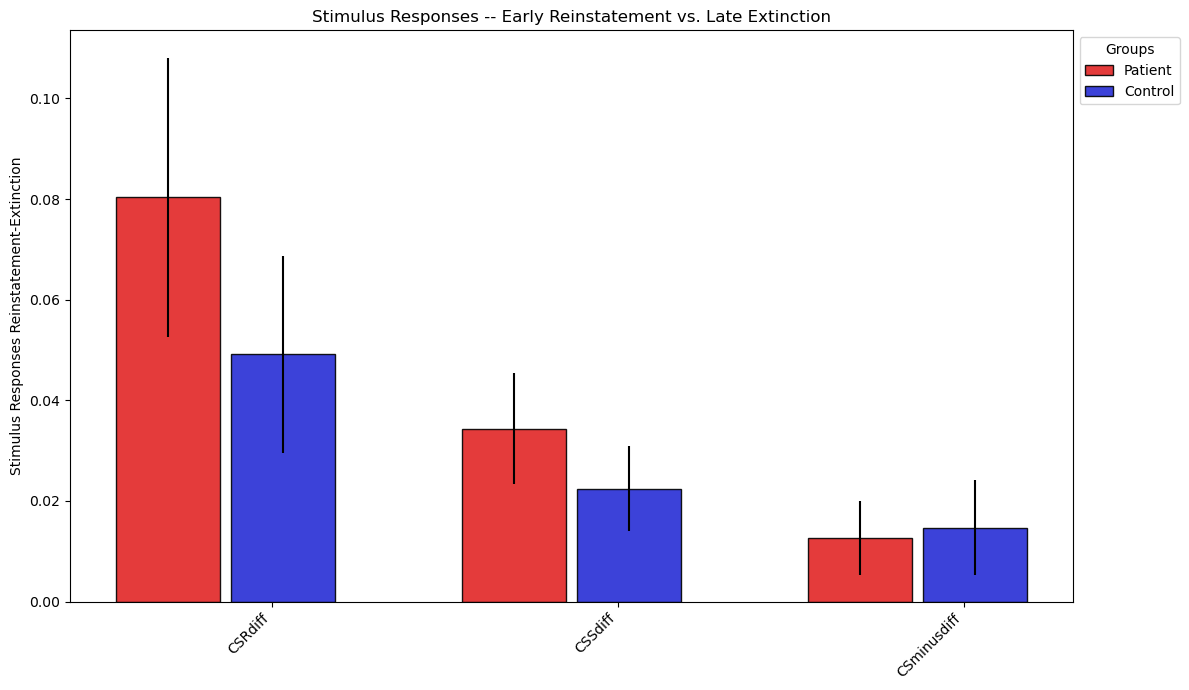

Statistical Test Results:


,Comparison,T-Stat,P-Value
0,Patient vs 0 (CSRdiff),2.895606,0.008650
1,Control vs 0 (CSRdiff),2.504232,0.018614
2,Patient vs Control (CSRdiff),0.945160,0.349311
3,Patient vs 0 (CSSdiff),3.098805,0.005438
4,Control vs 0 (CSSdiff),2.643973,0.013481
5,Patient vs Control (CSSdiff),0.866875,0.390323
6,Patient vs 0 (CSminusdiff),1.724239,0.099356
7,Control vs 0 (CSminusdiff),1.545705,0.133818
8,Patient vs Control (CSminusdiff),-0.163828,0.870554


In [61]:
# ✅ Build contrast data from raw all_data and all_stats
def build_contrast_data(all_data):
    contrast_all_data = {}
    contrast_all_stats = {}

    # Define contrasts
    contrasts = {
        "CSR-CSS": ("CSR", "CSS"),
        "CSR-CSminus": ("CSR", "CSminus"),
       "CSS-CSminus": ("CSS", "CSminus")
    }

# Now run plotting function with contrast data
title = 'Stimulus Responses'
plot_multibar_with_error_bars(all_stats, all_data, title)


#### w oxytocin 

In [62]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack early and late responses with a time variable
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR2_late', 'meanCSR3_early', 'meanCSS2_late', 'meanCSS3_early', 'meanCSminus2_late', 'meanCSminus3_early'], 
                    var_name='stim_type_time', 
                    value_name='response')

# Split 'stim_type_time' into separate 'stim_type' and 'time' columns
long_data['stim_type'] = long_data['stim_type_time'].str.extract(r'mean(\w+)_')[0]
long_data['time'] = long_data['stim_type_time'].str.extract(r'_(\w+)$')[0].map({'late': 1, 'early': 2})

# Map stim_type to numerical codes
long_data['stim_type'] = long_data['stim_type'].map({
    'CSR2': 1, 
    'CSS2': 2, 
    'CSminus2': 3
})

# Specify the model with time as a main effect
model_formula = 'response ~ patient_group * drug + drug * gender + stim_type * time'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     2.321
Date:                Fri, 24 Oct 2025   Prob (F-statistic):             0.0332
Time:                        11:27:17   Log-Likelihood:                 554.23
No. Observations:                 303   AIC:                            -1094.
Df Residuals:                     296   BIC:                            -1068.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0158      0

In [381]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Convert original list of dictionaries into a DataFrame
dat_df = pd.DataFrame(dat)

# Load drug/gender table
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge
merged_data = pd.merge(dat_df, drug_order, on='subID', how='inner')

# Prepare columns
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']
merged_data['drug'] = merged_data['drug_condition']

# --- Reshape into long trial-type × time format ---
long_data = pd.melt(
    merged_data,
    id_vars=['subID', 'patient_group', 'drug', 'gender'],
    value_vars=[
        'meanCSR2_late', 'meanCSR3_early',
        'meanCSS2_late', 'meanCSS3_early',
        'meanCSminus2_late', 'meanCSminus3_early'
    ],
    var_name='stim_type_time',
    value_name='response'
)

# Extract stim type
long_data['stim_type'] = long_data['stim_type_time'].str.extract(r'mean(\w+)_')[0]

# Extract time (early vs late)
long_data['time'] = (
    long_data['stim_type_time']
    .str.extract(r'_(\w+)$')[0]
    .map({'early': 0, 'late': 1})  # better coding for linear modeling
)

# Stim type numeric coding
long_data['stim_type'] = long_data['stim_type'].map({
    'CSR2': 1,
    'CSS2': 2,
    'CSminus2': 3,
    'CSR3': 1,
    'CSS3': 2,
    'CSminus3': 3,    
})

# ---------------------------------------------
# Mixed-effects model (random intercept for subject)
# ---------------------------------------------
model_formula = (
    "response ~ patient_group * drug + drug * gender + drug:gender:stim_type + stim_type * time"
)

model = smf.mixedlm(
    formula=model_formula,
    data=long_data,
    groups=long_data['subID'],        # random intercept per subject
).fit()

print(model.summary())


             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    response
No. Observations:     606        Method:                REML    
No. Groups:           101        Scale:                 0.0029  
Min. group size:      6          Log-Likelihood:        787.4288
Max. group size:      6          Converged:             Yes     
Mean group size:      6.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.102    0.015  6.591 0.000  0.072  0.132
patient_group         -0.007    0.016 -0.434 0.664 -0.038  0.024
drug                   0.007    0.019  0.389 0.697 -0.030  0.044
patient_group:drug     0.009    0.022  0.391 0.696 -0.035  0.052
gender                 0.028    0.016  1.801 0.072 -0.002  0.059
drug:gender           -0.034    0.026 -

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [377]:
long_data

,subID,patient_group,drug,gender,stim_type_time,response,stim_type,time
0,N101,1,0,0,meanCSR2_late,0.018800,1,1
1,N103,1,1,0,meanCSR2_late,0.029667,1,1
2,N104,1,1,1,meanCSR2_late,0.022000,1,1
3,N105,1,1,0,meanCSR2_late,0.023667,1,1
4,N106,1,1,0,meanCSR2_late,0.030667,1,1
...,...,...,...,...,...,...,...,...
601,N255,0,1,0,meanCSminus3_early,0.028500,3,0
602,N257,0,0,0,meanCSminus3_early,0.047500,3,0
603,N258,0,0,0,meanCSminus3_early,0.036500,3,0
604,N259,0,1,0,meanCSminus3_early,0.033500,3,0


In [334]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Convert original list of dictionaries into a DataFrame
dat_df = pd.DataFrame(dat)

# Load drug/gender table
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge
merged_data = pd.merge(dat_df, drug_order, on='subID', how='inner')

# Prepare columns
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']
merged_data['drug'] = merged_data['drug_condition']

# --- Reshape into long trial-type × time format ---
long_data = pd.melt(
    merged_data,
    id_vars=['subID', 'patient_group', 'drug', 'gender'],
    value_vars=[
        'meanCSR2_late', 'meanCSR3_early',
        'meanCSS2_late', 'meanCSS3_early',
        'meanCSminus2_late', 'meanCSminus3_early'
    ],
    var_name='stim_type_time',
    value_name='response'
)

# Extract stim type
long_data['stim_type'] = long_data['stim_type_time'].str.extract(r'mean(\w+)_')[0]

# Extract time (early vs late)
long_data['time'] = (
    long_data['stim_type_time']
    .str.extract(r'_(\w+)$')[0]
    .map({'early': 0, 'late': 1})  # better coding for linear modeling
)

# Stim type numeric coding
long_data['stim_type'] = long_data['stim_type'].map({
    'CSR2': 1,
    'CSS2': 2,
    'CSminus2': 3,
    'CSR3': 1,
    'CSS3': 2,
    'CSminus3': 3,    
})

# ---------------------------------------------
# Mixed-effects model (random intercept for subject)
# ---------------------------------------------
model_formula = (
    "response ~ patient_group * drug + drug * gender + drug:gender:stim_type + stim_type * time"
)

model = smf.mixedlm(
    formula=model_formula,
    data=long_data,
    groups=long_data['subID'],        # random intercept per subject
).fit()

print(model.summary())


             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    response
No. Observations:     606        Method:                REML    
No. Groups:           101        Scale:                 0.0029  
Min. group size:      6          Log-Likelihood:        787.4288
Max. group size:      6          Converged:             Yes     
Mean group size:      6.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.102    0.015  6.591 0.000  0.072  0.132
patient_group         -0.007    0.016 -0.434 0.664 -0.038  0.024
drug                   0.007    0.019  0.389 0.697 -0.030  0.044
patient_group:drug     0.009    0.022  0.391 0.696 -0.035  0.052
gender                 0.028    0.016  1.801 0.072 -0.002  0.059
drug:gender           -0.034    0.026 -

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
l

In [375]:
print(long_data)

    subID stim_type  response
0    N101       CSR   0.02300
1    N103       CSR   0.39050
2    N104       CSR   0.01700
3    N105       CSR   0.02675
4    N106       CSR   0.02775
..    ...       ...       ...
298  N255       CS−   0.02850
299  N257       CS−   0.04750
300  N258       CS−   0.03650
301  N259       CS−   0.03350
302  N260       CS−   0.05400

[303 rows x 3 columns]


##### group v drug (reinstatement-extinction diff)

In [63]:
import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx",'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID','drug_condition', 'gender_code']], on='subID', how='left')

data['CSRdiff'] = data['meanCSR3_early']-data['meanCSR2_late']
data['CSSdiff'] = data['meanCSS3_early']-data['meanCSS2_late']
data['CSminusdiff'] = data['meanCSminus3_early']-data['meanCSminus2_late']


# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        'patient_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
        'patient_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
        'control_drug' if row['subID'].startswith('N2') and row['drug_condition'] == 1 else
        'control_placebo'
    ), axis=1
)

# Initialize dictionary to store means and SEs
all_stats = {}

# Calculate means and SEs for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Early stage statistics for CSS2
    mean = group_data['CSSdiff'].mean()
    se = group_data['CSSdiff'].sem()
    all_stats[f'CSSdiff_{group}'] = (mean, se)
    

    # Early stage statistics for CSS2
    mean = group_data['CSRdiff'].mean()
    se = group_data['CSRdiff'].sem()
    all_stats[f'CSRdiff_{group}'] = (mean, se)
    
    # Early stage statistics for CSS2
    mean = group_data['CSminusdiff'].mean()
    se = group_data['CSminusdiff'].sem()
    all_stats[f'CSminusdiff_{group}'] = (mean, se)

    
import pandas as pd


# Initialize dictionary to store all data
all_data = {}

# Populate all_data with raw data for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Store early and late stage data for each stimulus type
    all_data[f'CSSdiff_{group}'] = group_data['CSSdiff'].values
    all_data[f'CSRdiff_{group}'] = group_data['CSRdiff'].values
    all_data[f'CSminusdiff_{group}'] = group_data['CSminusdiff'].values


In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_1samp

# ✅ Function to prepare data for multibar plot
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for contrast in ['CSRdiff','CSSdiff','CSminusdiff']:
        for group in ['patient_drug', 'patient_placebo', 'control_drug', 'control_placebo']:
            mean, se = all_stats[f'{contrast}_{group}']
            data.append({
                'Contrast': contrast,
                'Group': group.replace('_', ' ').title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(data)


# ✅ Function to perform post-hoc tests + average across stimulus types
def calculate_posthoc_tests(all_data):
    results = []
    contrasts = ['CSRdiff','CSSdiff','CSminusdiff']

    for contrast in contrasts:
        patient_drug = all_data[f'{contrast}_patient_drug']
        patient_placebo = all_data[f'{contrast}_patient_placebo']
        control_drug = all_data[f'{contrast}_control_drug']
        control_placebo = all_data[f'{contrast}_control_placebo']

        # --- 1) Within-group tests vs 0
        for group_name, data in {
            'Patient Drug': patient_drug,
            'Patient Placebo': patient_placebo,
            'Control Drug': control_drug,
            'Control Placebo': control_placebo
        }.items():
            if len(data) > 1:
                t_stat, p_value = ttest_1samp(data, 0)
            else:
                t_stat, p_value = (np.nan, np.nan)
            results.append({'Comparison': f'{group_name} vs 0 ({contrast})',
                            'T-Stat': t_stat, 'P-Value': p_value})

        # --- 2) Between-group comparisons
        for group_pair, (data1, data2) in {
            'Patient Drug vs Placebo': (patient_drug, patient_placebo),
            'Control Drug vs Placebo': (control_drug, control_placebo),
            'Patient vs Control Drug': (patient_drug, control_drug),
            'Patient vs Control Placebo': (patient_placebo, control_placebo)
        }.items():
            if len(data1) > 1 and len(data2) > 1:
                t_stat, p_value = ttest_ind(data1, data2)
            else:
                t_stat, p_value = (np.nan, np.nan)
            results.append({'Comparison': f'{group_pair} ({contrast})',
                            'T-Stat': t_stat, 'P-Value': p_value})

    # --- 3) Average across stimulus types (CSR, CSS, CSminus)
    avg_patient_drug = np.nanmean([all_data[f'{c}_patient_drug'] for c in contrasts], axis=0)
    avg_patient_placebo = np.nanmean([all_data[f'{c}_patient_placebo'] for c in contrasts], axis=0)
    avg_control_drug = np.nanmean([all_data[f'{c}_control_drug'] for c in contrasts], axis=0)
    avg_control_placebo = np.nanmean([all_data[f'{c}_control_placebo'] for c in contrasts], axis=0)

    # --- 4) Patient vs Control comparisons on averaged data
    for condition, (patient_data, control_data) in {
        'Drug': (avg_patient_drug, avg_control_drug),
        'Placebo': (avg_patient_placebo, avg_control_placebo)
    }.items():
        if len(patient_data) > 1 and len(control_data) > 1:
            t_stat, p_value = ttest_ind(patient_data, control_data)
        else:
            t_stat, p_value = (np.nan, np.nan)
        results.append({'Comparison': f'Patient vs Control ({condition}, Averaged)',
                        'T-Stat': t_stat, 'P-Value': p_value})

    return pd.DataFrame(results)


# ✅ Plot function
def plot_multibar_with_error_bars(all_stats, all_data, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)
    
    plt.figure(figsize=(12, 7))
    contrasts = df['Contrast'].unique()
    groups = df['Group'].unique()
    width = 0.9
    colors = ["#db6060", "#e22525", "#6e94db", "#272dd5"]

    # Plot each contrast
    for i, contrast in enumerate(contrasts):
        x_pos = np.arange(len(groups)) + i * (len(groups) + 1)
        
        for j, group in enumerate(groups):
            group_data = df[(df['Contrast'] == contrast) & (df['Group'] == group)]
            plt.bar(x_pos[j], group_data['Mean'].values[0],
                    yerr=group_data['SE'].values[0],
                    width=width, color=colors[j], alpha=0.9,
                    edgecolor='black', label=f'{group}' if i == 0 else "")

    # Customize plot
    tick_pos = [x + width for x in range(0, len(contrasts) * (len(groups) + 1), len(groups) + 1)]
    plt.xticks(tick_pos, contrasts, rotation=45, ha='right')
    plt.ylabel(f'{title} Reinstatement-Extinction')
    plt.title(f'{title} -- Early Reinstatement vs. Late Extinction')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups')
    plt.tight_layout()
    plt.show()

    print("Statistical Test Results:")
    display(stats_df)


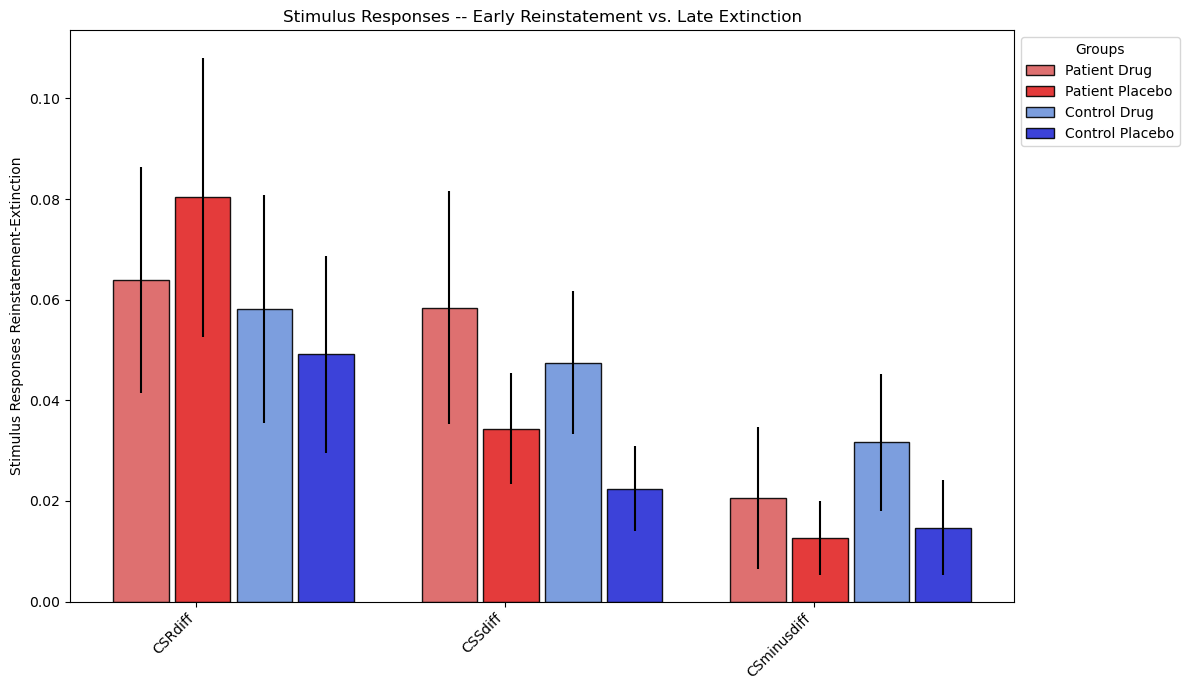

Statistical Test Results:


,Comparison,T-Stat,P-Value
0,Patient Drug vs 0 (CSRdiff),2.849236,0.008459
1,Patient Placebo vs 0 (CSRdiff),2.895606,0.008650
2,Control Drug vs 0 (CSRdiff),2.562296,0.017416
3,Control Placebo vs 0 (CSRdiff),2.504232,0.018614
4,Patient Drug vs Placebo (CSRdiff),-0.464644,0.644332
5,Control Drug vs Placebo (CSRdiff),0.303363,0.762872
6,Patient vs Control Drug (CSRdiff),0.181286,0.856891
7,Patient vs Control Placebo (CSRdiff),0.945160,0.349311
8,Patient Drug vs 0 (CSSdiff),2.528116,0.017880
9,Patient Placebo vs 0 (CSSdiff),3.098805,0.005438


In [65]:
# ✅ Build contrast data from raw all_data and all_stats
def build_contrast_data(all_data):
    contrast_all_data = {}
    contrast_all_stats = {}

    # Define contrasts
    contrasts = {
        "CSR-CSS": ("CSR", "CSS"),
        "CSR-CSminus": ("CSR", "CSminus"),
       "CSS-CSminus": ("CSS", "CSminus")
    }

    # for contrast_name, (stim1, stim2) in contrasts.items():
    #     for group in ['patient_drug', 'patient_placebo', 'control_drug', 'control_placebo']:
    #         # # Compute raw difference scores for each subject
    #         # data1 = np.array(all_data[f"{stim1}_{group}"])
    #         # data2 = np.array(all_data[f"{stim2}_{group}"])
    #         # diff_scores = data1 - data2

    #         # Store in contrast_all_data
    #         contrast_all_data[f"{contrast_name}_{group}"] = diff_scores

    #         # Compute mean and SE
    #         mean = np.nanmean(diff_scores)
    #         se = np.nanstd(diff_scores, ddof=1) / np.sqrt(len(diff_scores))
    #         contrast_all_stats[f"{contrast_name}_{group}"] = (mean, se)

    # return contrast_all_data, contrast_all_stats


# # ✅ Example usage before plotting
# contrast_all_data, contrast_all_stats = build_contrast_data(all_data)

# Now run plotting function with contrast data
title = 'Stimulus Responses'
plot_multibar_with_error_bars(all_stats, all_data, title)


##### gender post-hoc

In [355]:
import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx",'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID','drug_condition', 'gender_code']], on='subID', how='left')

data['CSRdiff'] = data['meanCSR3_early']-data['meanCSR2_late']
data['CSSdiff'] = data['meanCSS3_early']-data['meanCSS2_late']
data['CSminusdiff'] = data['meanCSminus3_early']-data['meanCSminus2_late']


# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        # 'female' if row['gender_code'] == 0 else
        # 'male'
        'female' if row['subID'].startswith('N1')  else
        'male'
    ), axis=1
)


# Initialize dictionary to store means and SEs
all_stats = {}

# Calculate means and SEs for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Early stage statistics for CSS2
    mean = group_data['CSSdiff'].mean()
    se = group_data['CSSdiff'].sem()
    all_stats[f'CSSdiff_{group}'] = (mean, se)
    

    # Early stage statistics for CSS2
    mean = group_data['CSRdiff'].mean()
    se = group_data['CSRdiff'].sem()
    all_stats[f'CSRdiff_{group}'] = (mean, se)
    
    # Early stage statistics for CSS2
    mean = group_data['CSminusdiff'].mean()
    se = group_data['CSminusdiff'].sem()
    all_stats[f'CSminusdiff_{group}'] = (mean, se)

    
import pandas as pd


# Initialize dictionary to store all data
all_data = {}

# Populate all_data with raw data for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Store early and late stage data for each stimulus type
    all_data[f'CSSdiff_{group}'] = group_data['CSSdiff'].values
    all_data[f'CSRdiff_{group}'] = group_data['CSRdiff'].values
    all_data[f'CSminusdiff_{group}'] = group_data['CSminusdiff'].values


In [358]:
from scipy.stats import ttest_ind, ttest_1samp

# ✅ Function to prepare data for multibar plot
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for contrast in ['CSRdiff','CSSdiff','CSminusdiff']:
        for group in ['female', 'male']:
            mean, se = all_stats[f'{contrast}_{group}']
            data.append({
                'Contrast': contrast,
                'Group': group.replace('_', ' ').title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(data)


# ✅ Function to perform post-hoc tests
def calculate_posthoc_tests(all_data):
    results = []
    
    for contrast in ['CSRdiff','CSSdiff','CSminusdiff']:
        female = all_data[f'{contrast}_female']
        male = all_data[f'{contrast}_male']

        # --- 1) Within-group tests vs 0
        for group_name, data in {
            'Female': female,
            'Male': male,
        }.items():
            if len(data) > 1:
                t_stat, p_value = ttest_1samp(data, 0)
            else:
                t_stat, p_value = (np.nan, np.nan)
            results.append({'Comparison': f'{group_name} vs 0 ({contrast})',
                            'T-Stat': t_stat, 'P-Value': p_value})

        # --- 2) Between-group comparisons
        for group_pair, (data1, data2) in {
            'Female vs Male': (female, male),
        }.items():
            if len(data1) > 1 and len(data2) > 1:
                t_stat, p_value = ttest_ind(data1, data2)
            else:
                t_stat, p_value = (np.nan, np.nan)
            results.append({'Comparison': f'{group_pair} ({contrast})',
                            'T-Stat': t_stat, 'P-Value': p_value})

    return pd.DataFrame(results)


# ✅ Plot function
def plot_multibar_with_error_bars(all_stats, all_data, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)
    
    plt.figure(figsize=(12, 7))
    contrasts = df['Contrast'].unique()
    groups = df['Group'].unique()
    width = 0.9
    colors = ["#e22525","#272dd5"]

    # Plot each contrast
    for i, contrast in enumerate(contrasts):
        x_pos = np.arange(len(groups)) + i * (len(groups) + 1)
        
        for j, group in enumerate(groups):
            group_data = df[(df['Contrast'] == contrast) & (df['Group'] == group)]
            
            plt.bar(x_pos[j], group_data['Mean'].values[0],
                    yerr=group_data['SE'].values[0],
                    width=width, color=colors[j], alpha=0.9,
                    edgecolor='black', label=f'{group}' if i == 0 else "")

    # Customize plot
    tick_pos = [x + width for x in range(0, len(contrasts) * (len(groups) + 1), len(groups) + 1)]
    plt.xticks(tick_pos, contrasts, rotation=45, ha='right')
    plt.ylabel(f'{title} Difference Score (vs CSminus)')
    plt.title(f'{title} -- CSR & CSS contrasts with CSminus')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups')
    plt.savefig("gender-vs-reinstatement-extinction.png",format='png', dpi=300)
    plt.tight_layout()
    plt.show()

    print("Statistical Test Results:")
    display(stats_df)



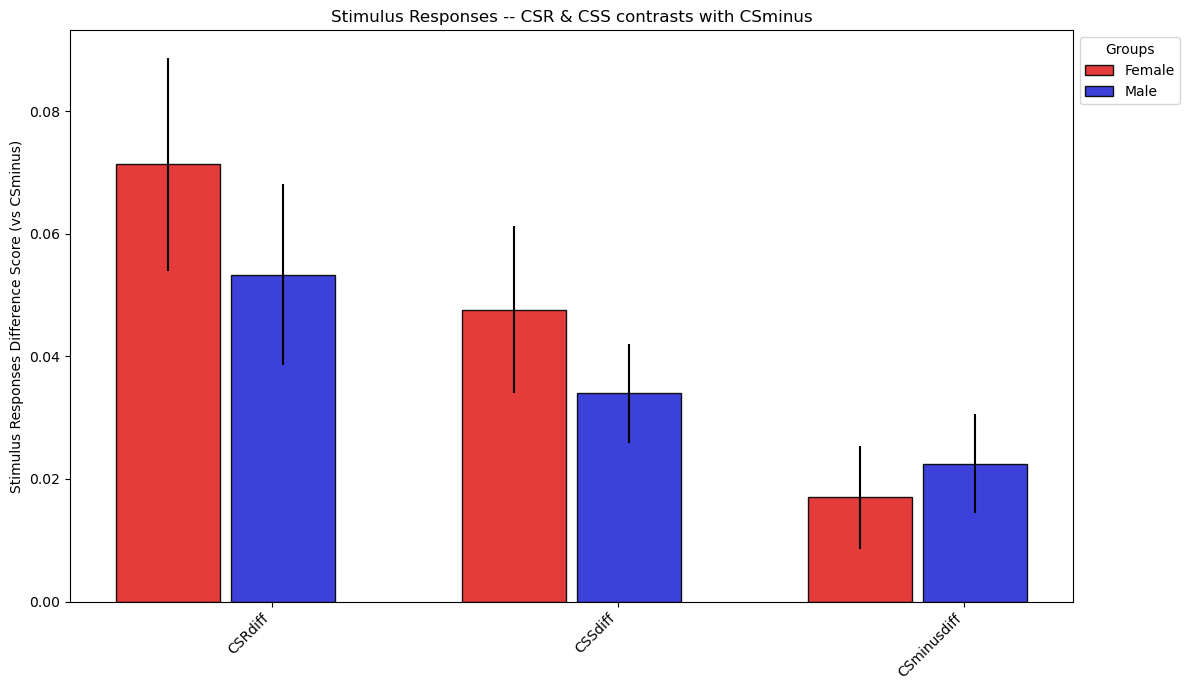

Statistical Test Results:


,Comparison,T-Stat,P-Value
0,Female vs 0 (CSRdiff),4.096884,0.000160
1,Male vs 0 (CSRdiff),3.615094,0.000687
2,Female vs Male (CSRdiff),0.794057,0.429061
3,Female vs 0 (CSSdiff),3.486297,0.001058
4,Male vs 0 (CSSdiff),4.198440,0.000108
5,Female vs Male (CSSdiff),0.870356,0.386211
6,Female vs 0 (CSminusdiff),2.029329,0.047989
7,Male vs 0 (CSminusdiff),2.778412,0.007627
8,Female vs Male (CSminusdiff),-0.474503,0.636186


In [360]:

# Now run plotting function with contrast data
title = 'Stimulus Responses'
plot_multibar_with_error_bars(all_stats, all_data, title)



One-sample t-tests vs 0 (All Subjects Combined):
CSRdiff: t=3.834, p=0.0004
CSSdiff: t=4.076, p=0.0002
CSminusdiff: t=2.236, p=0.0300


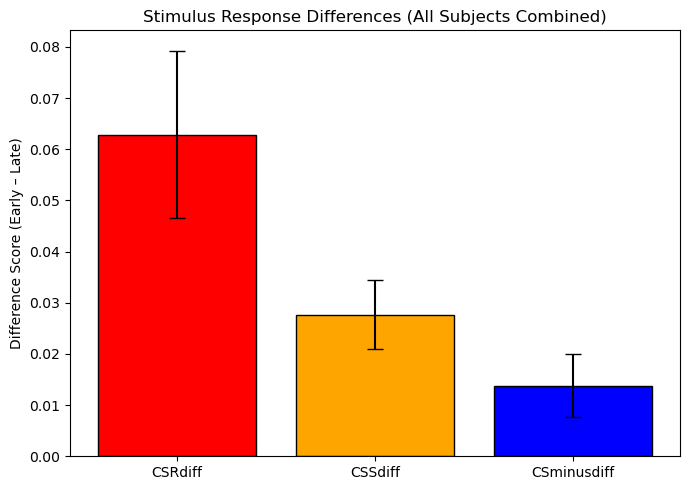

In [383]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx", 'drug_order')

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID','drug_condition','gender_code']], on='subID', how='left')
data = data[data['drug_condition'] == 0]

# Compute difference scores
data['CSRdiff']     = data['meanCSR3_early']     - data['meanCSR2_late']
data['CSSdiff']     = data['meanCSS3_early']     - data['meanCSS2_late']
data['CSminusdiff'] = data['meanCSminus3_early'] - data['meanCSminus2_late']

# -------------------------------------------------------------
# 📌 COLLAPSE ACROSS GROUPS — All subjects combined
# -------------------------------------------------------------

# Compute mean and SE for the full sample
collapsed_stats = {
    'CSRdiff':     (data['CSRdiff'].mean(),     data['CSRdiff'].sem()),
    'CSSdiff':     (data['CSSdiff'].mean(),     data['CSSdiff'].sem()),
    'CSminusdiff': (data['CSminusdiff'].mean(), data['CSminusdiff'].sem())
}

# Store raw arrays for statistical testing
collapsed_data = {
    'CSRdiff':     data['CSRdiff'].values,
    'CSSdiff':     data['CSSdiff'].values,
    'CSminusdiff': data['CSminusdiff'].values
}

# -------------------------------------------------------------
# 📌 One-sample t-tests (contrast vs 0)
# -------------------------------------------------------------
print("\nOne-sample t-tests vs 0 (All Subjects Combined):")
test_results = []
for contrast, values in collapsed_data.items():
    t, p = ttest_1samp(values, 0)
    test_results.append([contrast, t, p])
    print(f"{contrast}: t={t:.3f}, p={p:.4f}")

# -------------------------------------------------------------
# 📌 Plot: 3-bar plot for all subjects combined
# -------------------------------------------------------------
plt.figure(figsize=(7,5))

contrasts = ['CSRdiff','CSSdiff','CSminusdiff']
means = [collapsed_stats[c][0] for c in contrasts]
ses   = [collapsed_stats[c][1] for c in contrasts]
colors = ["red", "orange", "blue"]

xpos = np.arange(len(contrasts))

plt.bar(xpos, means, yerr=ses, capsize=6, color=colors, edgecolor='black')

plt.xticks(xpos, contrasts)
plt.ylabel("Difference Score (Early – Late)")
plt.title("Stimulus Response Differences (All Subjects Combined)")
filename = 'reinstatement-extinction_allsubjects.png'
plt.savefig(filename, format='png', dpi=300)
plt.tight_layout()
plt.show()


In [384]:
import numpy as np
from scipy import stats
import pandas as pd

# collapsed_data already exists:
# collapsed_data = {
#     'CSRdiff':     data['CSRdiff'].values,
#     'CSSdiff':     data['CSSdiff'].values,
#     'CSminusdiff': data['CSminusdiff'].values
# }

# Convert to DataFrame for convenience
df = pd.DataFrame(collapsed_data)

# Define all pairwise comparisons
pairs = [
    ('CSRdiff', 'CSSdiff'),
    ('CSRdiff', 'CSminusdiff'),
    ('CSSdiff', 'CSminusdiff')
]

results = []

for a, b in pairs:
    # Paired t-test
    t, p = stats.ttest_rel(df[a], df[b], nan_policy='omit')
    results.append({
        'Comparison': f'{a} vs {b}',
        't-value': t,
        'p-value': p
    })

# Make results table
results_df = pd.DataFrame(results)
print(results_df)


               Comparison   t-value   p-value
0      CSRdiff vs CSSdiff  2.899903  0.005573
1  CSRdiff vs CSminusdiff  3.935449  0.000262
2  CSSdiff vs CSminusdiff  2.246786  0.029192



Paired t-tests between contrast difference scores:
CSRdiff vs CSSdiff: t=2.709, p=0.0079
CSRdiff vs CSminusdiff: t=5.027, p=0.0000
CSSdiff vs CSminusdiff: t=3.229, p=0.0017


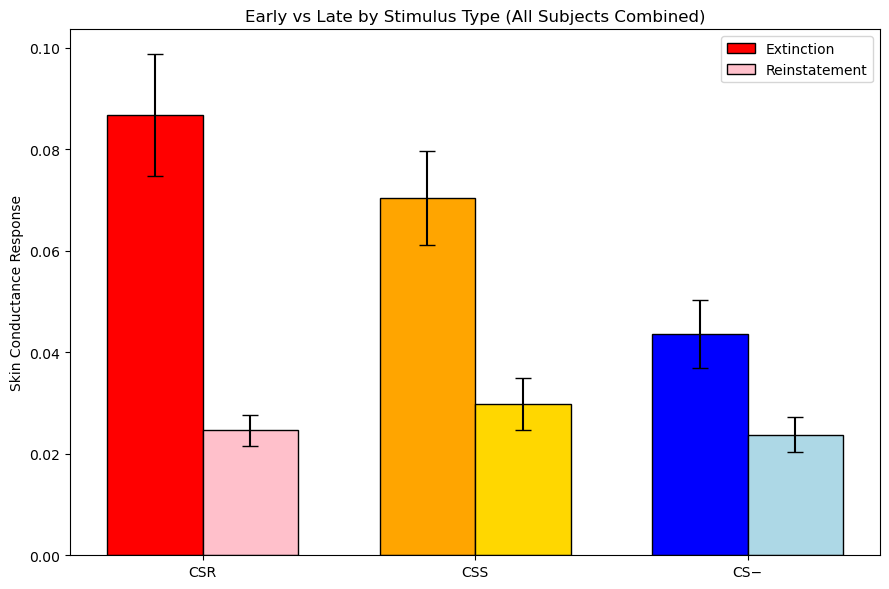

In [340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, ttest_rel

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx", 'drug_order')

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID','drug_condition','gender_code']], 
                on='subID', how='left')

# -------------------------------------------------------------
# 📌 Compute EARLY and LATE means separately for each stimulus
# -------------------------------------------------------------
stim_early = {
    'CSR_early':     data['meanCSR3_early'].values,
    'CSS_early':     data['meanCSS3_early'].values,
    'CSminus_early': data['meanCSminus3_early'].values
}

stim_late = {
    'CSR_late':     data['meanCSR2_late'].values,
    'CSS_late':     data['meanCSS2_late'].values,
    'CSminus_late': data['meanCSminus2_late'].values
}

# -------------------------------------------------------------
# 📌 Compute difference scores (unchanged)
# -------------------------------------------------------------
data['CSRdiff']     = data['meanCSR3_early']     - data['meanCSR2_late']
data['CSSdiff']     = data['meanCSS3_early']     - data['meanCSS2_late']
data['CSminusdiff'] = data['meanCSminus3_early'] - data['meanCSminus2_late']

collapsed_stats = {
    'CSRdiff':     (data['CSRdiff'].mean(),     data['CSRdiff'].sem()),
    'CSSdiff':     (data['CSSdiff'].mean(),     data['CSSdiff'].sem()),
    'CSminusdiff': (data['CSminusdiff'].mean(), data['CSminusdiff'].sem())
}

collapsed_data = {
    'CSRdiff':     data['CSRdiff'].values,
    'CSSdiff':     data['CSSdiff'].values,
    'CSminusdiff': data['CSminusdiff'].values
}

# -------------------------------------------------------------
# 📌 Pairwise paired t-tests between diff scores
# -------------------------------------------------------------
print("\nPaired t-tests between contrast difference scores:")
pairs = [
    ('CSRdiff', 'CSSdiff'),
    ('CSRdiff', 'CSminusdiff'),
    ('CSSdiff', 'CSminusdiff')
]

for a, b in pairs:
    t, p = ttest_rel(collapsed_data[a], collapsed_data[b], nan_policy='omit')
    print(f"{a} vs {b}: t={t:.3f}, p={p:.4f}")

# -------------------------------------------------------------
# 📌 Grouped Plot: Early vs Late for each stimulus type
# -------------------------------------------------------------
plt.figure(figsize=(9,6))

stimuli = ["CSR", "CSS", "CS−"]
late_means = [
    data['meanCSR2_late'].mean(),
    data['meanCSS2_late'].mean(),
    data['meanCSminus2_late'].mean()
]
early_means = [
    data['meanCSR3_early'].mean(),
    data['meanCSS3_early'].mean(),
    data['meanCSminus3_early'].mean()
]
late_ses = [
    data['meanCSR2_late'].sem(),
    data['meanCSS2_late'].sem(),
    data['meanCSminus2_late'].sem()
]
early_ses = [
    data['meanCSR3_early'].sem(),
    data['meanCSS3_early'].sem(),
    data['meanCSminus3_early'].sem()
]

x = np.arange(len(stimuli))          # 0,1,2
bar_width = 0.35

# Colors
early_color = ['red','orange','blue']
late_color  = ['pink','gold','lightblue']

# Plot Early bars
plt.bar(x - bar_width/2, early_means, 
        yerr=early_ses, capsize=6,
        width=bar_width, color=early_color, edgecolor='black',
        label="Extinction")

# Plot Late bars
plt.bar(x + bar_width/2, late_means, 
        yerr=late_ses, capsize=6,
        width=bar_width, color=late_color, edgecolor='black',
        label="Reinstatement")

# Formatting
plt.xticks(x, stimuli)
plt.ylabel("Skin Conductance Response")
plt.title("Early vs Late by Stimulus Type (All Subjects Combined)")
plt.legend()
plt.tight_layout()
plt.savefig("grouped_early_late_stimulus_plot.png", dpi=300)
plt.show()
